In [1]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from scipy.stats import entropy
import torch
from torch.utils.data import DataLoader, TensorDataset

In [4]:
!ls

BatchTopK.ipynb		  notebook_logs.txt  SAE.ipynb		 TopK.ipynb
JumpRelu.ipynb		  random_sae.ipynb   SAE_Training.ipynb  Topk_SAE.ipynb
LogisticClassifier.ipynb  SAE_ALL.ipynb      Test.ipynb		 VSAE.ipynb


In [2]:
pkl_path = '../logs_vanilla_sae/new_initialized_sae.pkl'

In [1]:
with open(pkl_path, "rb") as f:
    all_results = pickle.load(f)

pure_digit_coverage = {}

for sae_name, results in all_results.items():
    auc_matrix = results["auc_matrix"]
    neuron_df = results["per_neuron_df"]
    
    count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
    
    pure_neurons = count_per_neuron[count_per_neuron == 1].index
    
    digits_represented = neuron_df.loc[pure_neurons, "best_digit"]
    
    digit_counts = digits_represented.value_counts().sort_index()
    
    pure_digit_coverage[sae_name] = {
        "n_digits_represented": digit_counts.count(),
        "digit_counts": digit_counts.to_dict()
    }

for sae, info in pure_digit_coverage.items():
    print(f"\n{sae}:")
    print(f"  Unique digits with ≥1 pure neuron: {info['n_digits_represented']}")
    print(f"  Digit breakdown: {info['digit_counts']}")


In [6]:
all_results.keys()

dict_keys(['256', '512'])

In [7]:
sae_digit_counts = {}
auc_matrix = all_results['256']['auc_matrix']
neuron_df = all_results['256']['per_neuron_df']
summary_df = all_results['256']['sae_summary']

In [8]:
count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
pure_neurons = count_per_neuron[count_per_neuron == 1].index

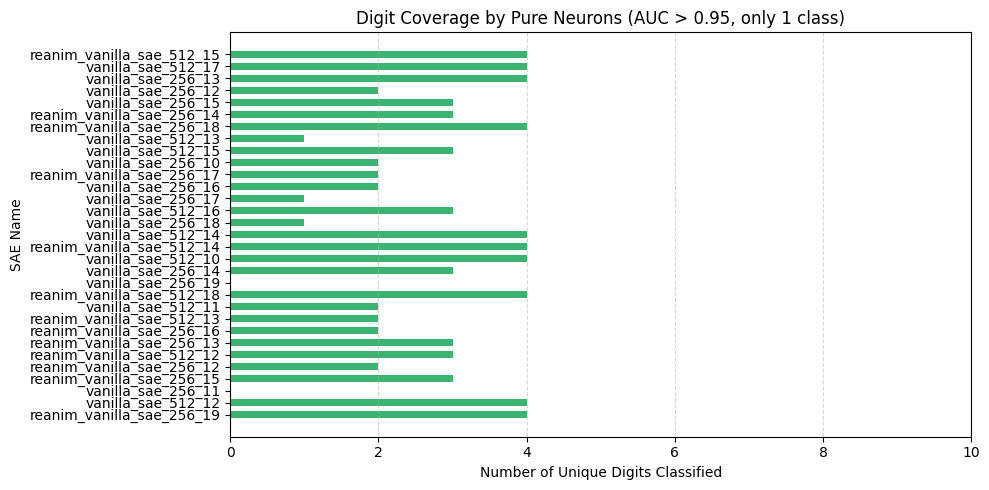

In [15]:
with open(pkl_path, "rb") as f:
    all_results = pickle.load(f)

sae_digit_counts = {}

for sae_name, results in all_results.items():
    
    auc_matrix = results["auc_matrix"]
    neuron_df = results["per_neuron_df"]

    count_per_neuron = (auc_matrix > 0.95).sum(axis=1)

    pure_neurons = count_per_neuron[count_per_neuron == 1].index

    digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

    if digits_represented.nunique() <= 4:
        grouped_name = sae_name.split("_best")[0]
        sae_digit_counts[grouped_name] = digits_represented.nunique()

plt.figure(figsize=(10, 5))
plt.barh(list(sae_digit_counts.keys()), list(sae_digit_counts.values()), color="mediumseagreen", height=0.6)
plt.xlabel("Number of Unique Digits Classified")
plt.ylabel("SAE Name")
plt.title(f"Digit Coverage by Pure Neurons (AUC > 0.95, only 1 class)")
plt.xlim(0, 10)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.subplots_adjust(left=0.2)  
plt.tight_layout()
plt.show()

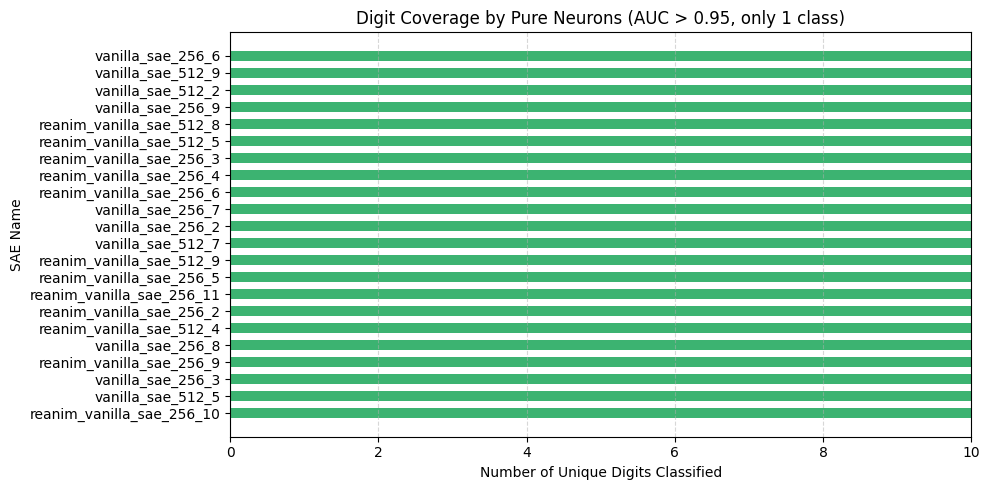

In [16]:
with open(pkl_path, "rb") as f:
    all_results = pickle.load(f)

sae_digit_counts = {}

for sae_name, results in all_results.items():
    
    auc_matrix = results["auc_matrix"]
    neuron_df = results["per_neuron_df"]

    count_per_neuron = (auc_matrix > 0.95).sum(axis=1)

    pure_neurons = count_per_neuron[count_per_neuron == 1].index

    digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

    if digits_represented.nunique() >= 10:
        grouped_name = sae_name.split("_best")[0]
        sae_digit_counts[grouped_name] = digits_represented.nunique()

plt.figure(figsize=(10, 5))
plt.barh(list(sae_digit_counts.keys()), list(sae_digit_counts.values()), color="mediumseagreen", height=0.6)
plt.xlabel("Number of Unique Digits Classified")
plt.ylabel("SAE Name")
plt.title(f"Digit Coverage by Pure Neurons (AUC > 0.95, only 1 class)")
plt.xlim(0, 10)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.subplots_adjust(left=0.2)  
plt.tight_layout()
plt.show()

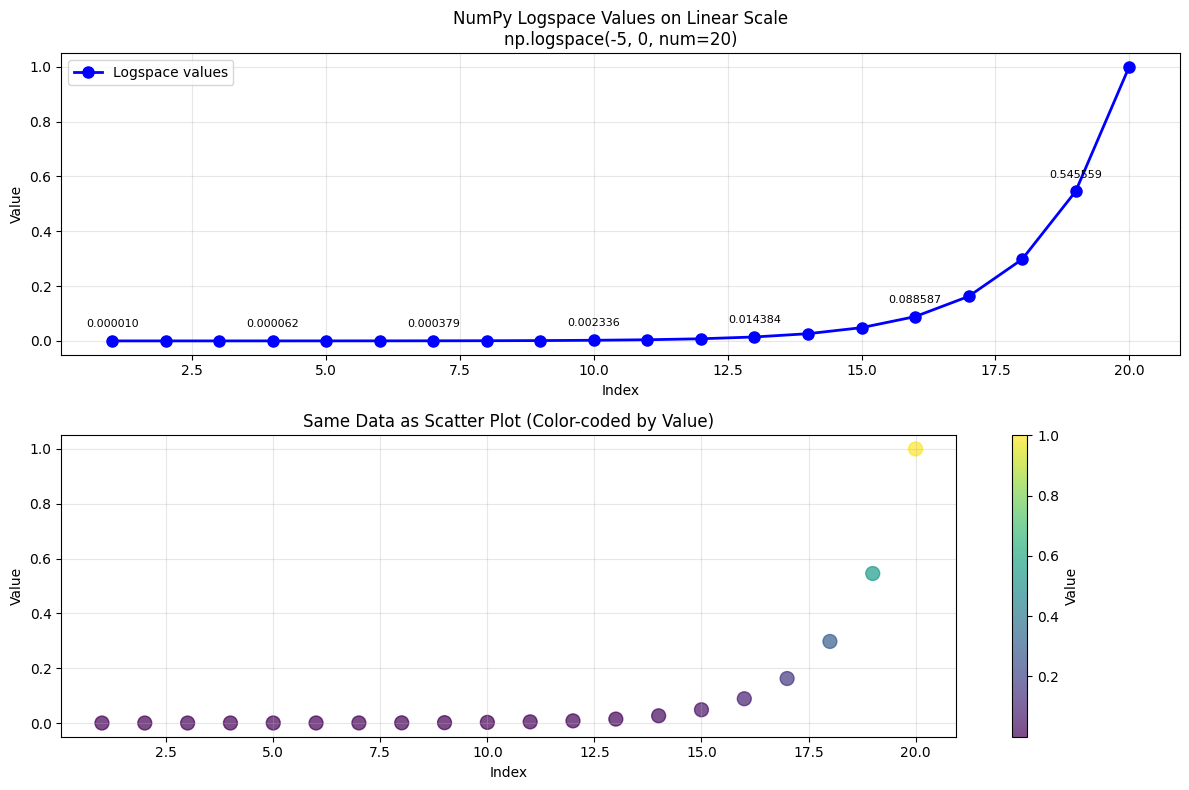

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate the logspace values
values = [round(val, 6) for val in np.logspace(-5, 0, num=20)]

# Create indices for x-axis
indices = range(1, len(values) + 1)

# Create the plot
plt.figure(figsize=(12, 8))

# Main plot - linear scale
plt.subplot(2, 1, 1)
plt.plot(indices, values, 'bo-', markersize=8, linewidth=2, label='Logspace values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('NumPy Logspace Values on Linear Scale\nnp.logspace(-5, 0, num=20)')
plt.grid(True, alpha=0.3)
plt.legend()

# Add value annotations for clarity
for i, v in enumerate(values):
    if i % 3 == 0:  # Annotate every 3rd point to avoid clutter
        plt.annotate(f'{v:.6f}', (i+1, v), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=8)

# Secondary plot - scatter plot for better visibility of individual points
plt.subplot(2, 1, 2)
plt.scatter(indices, values, c=values, cmap='viridis', s=100, alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Same Data as Scatter Plot (Color-coded by Value)')
plt.colorbar(label='Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


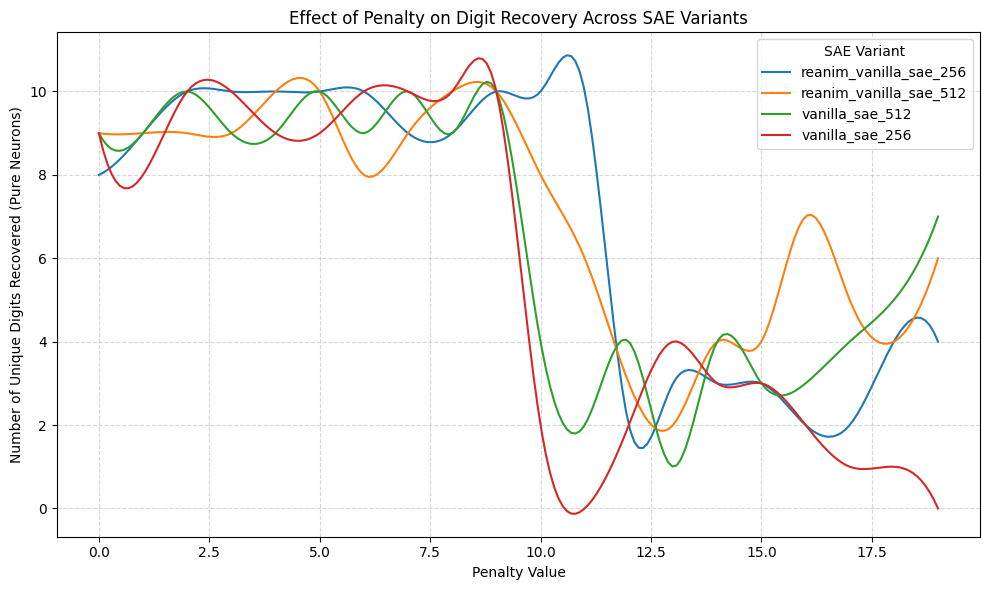

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict
from scipy.interpolate import make_interp_spline  # smooth curves

grouped_digit_counts = defaultdict(dict)

# Step 1: Parse and group
for sae_name, results in all_results.items():
    if "auc_matrix" not in results or "per_neuron_df" not in results:
        continue

    # Clean up sae_name
    sae_name = sae_name.split('_best_loss')[0]

    try:
        penalty = float(sae_name.split('_')[-1])
        variant = "_".join(sae_name.split('_')[:-1])
    except ValueError:
        continue

    auc_matrix = results["auc_matrix"]
    neuron_df = results["per_neuron_df"]
    count_per_neuron = (auc_matrix > 0.95).sum(axis=1)
    pure_neurons = count_per_neuron[count_per_neuron == 1].index
    digits_represented = neuron_df.loc[pure_neurons, "best_digit"]

    grouped_digit_counts[variant][penalty] = digits_represented.nunique()

# Step 2: Plot
plt.figure(figsize=(10, 6))

for variant, penalty_dict in grouped_digit_counts.items():
    penalties = sorted(penalty_dict.keys())
    digits = [penalty_dict[p] for p in penalties]

    # Smooth curve using cubic spline (only if more than 3 points)
    if len(penalties) > 3:
        penalties_np = np.array(penalties)
        digits_np = np.array(digits)
        spline = make_interp_spline(penalties_np, digits_np, k=3)  # cubic
        x_smooth = np.linspace(min(penalties_np), max(penalties_np), 200)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=variant)
    else:
        # Not enough points to smooth — plot raw
        plt.plot(penalties, digits, marker='o', label=variant)

plt.xlabel("Penalty Value")
plt.ylabel("Number of Unique Digits Recovered (Pure Neurons)")
plt.title("Effect of Penalty on Digit Recovery Across SAE Variants")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="SAE Variant")
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import pickle

def parse_sae_name(sae_name):
    """Parse SAE name to extract configuration parameters."""
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]
    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == 'vanilla' and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return has_reanim, None, None

def plot_encoder_decoder_stable_rank(all_stable_rank_results, 
                                   figsize=(15, 10), 
                                   rank_type='stable_rank',
                                   use_frobenius=True,
                                   threshold=0.01):
    """
    Plot encoder and decoder stable/effective ranks vs penalty.
    
    Args:
        all_stable_rank_results: Dictionary of SAE results
        figsize: Figure size tuple
        rank_type: 'stable_rank', 'effective_rank', or 'both'
        use_frobenius: Whether to use frobenius-based calculation
        threshold: Threshold value if not using frobenius
    """
    if rank_type == 'both':
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Encoder & Decoder Rank Analysis vs Penalty', fontsize=16, fontweight='bold')
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        rank_name = 'Stable' if rank_type == 'stable_rank' else 'Effective'
        fig.suptitle(f'Encoder & Decoder {rank_name} Rank vs Penalty', fontsize=14, fontweight='bold')
    
    # Group data by SAE configuration
    grouped_data = {}
    for sae_name, sae_results in all_stable_rank_results.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        if dict_size is None or penalty is None:
            continue
        
        key = (has_reanim, dict_size)
        if key not in grouped_data:
            grouped_data[key] = {
                'penalties': [], 
                'enc_stable_ranks': [], 
                'dec_stable_ranks': [],
                'enc_effective_ranks': [],
                'dec_effective_ranks': [],
                'enc_total_ranks': [],
                'dec_total_ranks': []
            }
        
        # Extract rank values based on method
        if use_frobenius:
            enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
            dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
        else:
            threshold_key = f'threshold_{threshold}'
            enc_data = sae_results.get('encoder_analysis', {}).get(threshold_key, {})
            dec_data = sae_results.get('decoder_analysis', {}).get(threshold_key, {})
        
        # Get stable rank (always available)
        enc_stable = enc_data.get('stable_rank')
        dec_stable = dec_data.get('stable_rank')
        
        # Get effective rank (available when using frobenius method)
        enc_effective = enc_data.get('effective_rank')
        dec_effective = dec_data.get('effective_rank')
        
        # Get total rank for reference
        enc_total = enc_data.get('total_rank')
        dec_total = dec_data.get('total_rank')
        
        if enc_stable is not None and dec_stable is not None:
            grouped_data[key]['penalties'].append(penalty)
            grouped_data[key]['enc_stable_ranks'].append(enc_stable)
            grouped_data[key]['dec_stable_ranks'].append(dec_stable)
            grouped_data[key]['enc_effective_ranks'].append(enc_effective if enc_effective else 0)
            grouped_data[key]['dec_effective_ranks'].append(dec_effective if dec_effective else 0)
            grouped_data[key]['enc_total_ranks'].append(enc_total if enc_total else 0)
            grouped_data[key]['dec_total_ranks'].append(dec_total if dec_total else 0)
    
    # Plot data
    colors = plt.cm.tab10(np.linspace(0, 1, len(grouped_data)))
    
    for i, ((has_reanim, dict_size), data) in enumerate(grouped_data.items()):
        penalties = np.array(data['penalties'])
        
        # Sort by penalty
        sort_idx = np.argsort(penalties)
        penalties = penalties[sort_idx]
        
        label = f"{'Reanim' if has_reanim else 'Vanilla'} SAE {dict_size}"
        color = colors[i]
        
        if rank_type == 'both':
            # Plot both stable and effective ranks
            enc_stable = np.array(data['enc_stable_ranks'])[sort_idx]
            dec_stable = np.array(data['dec_stable_ranks'])[sort_idx]
            enc_effective = np.array(data['enc_effective_ranks'])[sort_idx]
            dec_effective = np.array(data['dec_effective_ranks'])[sort_idx]
            
            # Stable ranks
            axes[0].plot(penalties, enc_stable, marker='o', label=label, color=color)
            axes[1].plot(penalties, dec_stable, marker='s', label=label, color=color)
            
            # Effective ranks (only plot if available)
            if np.any(enc_effective > 0):
                axes[2].plot(penalties, enc_effective, marker='^', label=label, color=color)
            if np.any(dec_effective > 0):
                axes[3].plot(penalties, dec_effective, marker='v', label=label, color=color)
            
        else:
            # Plot single rank type
            if rank_type == 'stable_rank':
                enc_ranks = np.array(data['enc_stable_ranks'])[sort_idx]
                dec_ranks = np.array(data['dec_stable_ranks'])[sort_idx]
                marker_enc, marker_dec = 'o', 's'
            else:  # effective_rank
                enc_ranks = np.array(data['enc_effective_ranks'])[sort_idx]
                dec_ranks = np.array(data['dec_effective_ranks'])[sort_idx]
                marker_enc, marker_dec = '^', 'v'
                
                # Skip if no effective rank data
                if not np.any(enc_ranks > 0) or not np.any(dec_ranks > 0):
                    continue
            
            axes[0].plot(penalties, enc_ranks, marker=marker_enc, label=label, color=color)
            axes[1].plot(penalties, dec_ranks, marker=marker_dec, label=label, color=color)
    
    # Configure axes
    if rank_type == 'both':
        titles = ["Encoder Stable Rank", "Decoder Stable Rank", 
                 "Encoder Effective Rank", "Decoder Effective Rank"]
        for i, (ax, title) in enumerate(zip(axes, titles)):
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel("Penalty")
            ax.set_ylabel("Rank")
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    else:
        rank_name = 'Stable' if rank_type == 'stable_rank' else 'Effective'
        axes[0].set_title(f"Encoder {rank_name} Rank", fontweight='bold')
        axes[1].set_title(f"Decoder {rank_name} Rank", fontweight='bold')
        
        for ax in axes:
            ax.set_xlabel("Penalty")
            ax.set_ylabel(f"{rank_name} Rank")
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_rank_comparison(all_stable_rank_results, figsize=(12, 8)):
    """
    Compare stable rank, effective rank, and total rank for encoders.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Rank Comparison: Stable vs Effective vs Total', fontsize=14, fontweight='bold')
    
    # Collect all data points
    stable_ranks = []
    effective_ranks = []
    total_ranks = []
    sae_labels = []
    
    for sae_name, sae_results in all_stable_rank_results.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        if dict_size is None or penalty is None:
            continue
            
        enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
        dec_data = sae_results.get('decoder_analysis', {}).get('frobenius', {})
        
        for data, prefix in [(enc_data, 'Enc'), (dec_data, 'Dec')]:
            stable = data.get('stable_rank')
            effective = data.get('effective_rank')
            total = data.get('total_rank')
            
            if stable is not None and effective is not None and total is not None:
                stable_ranks.append(stable)
                effective_ranks.append(effective)
                total_ranks.append(total)
                label = f"{prefix} {'R' if has_reanim else 'V'}{dict_size}_{penalty}"
                sae_labels.append(label)
    
    # Scatter plot: Stable vs Effective
    ax1.scatter(stable_ranks, effective_ranks, alpha=0.6, s=50)
    ax1.plot([0, max(max(stable_ranks), max(effective_ranks))], 
             [0, max(max(stable_ranks), max(effective_ranks))], 
             'r--', alpha=0.5, label='y=x')
    ax1.set_xlabel('Stable Rank')
    ax1.set_ylabel('Effective Rank')
    ax1.set_title('Stable Rank vs Effective Rank')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Scatter plot: Total vs Effective
    ax2.scatter(total_ranks, effective_ranks, alpha=0.6, s=50, color='orange')
    ax2.plot([0, max(total_ranks)], [0, max(total_ranks)], 'r--', alpha=0.5, label='y=x')
    ax2.set_xlabel('Total Rank')
    ax2.set_ylabel('Effective Rank')
    ax2.set_title('Total Rank vs Effective Rank')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def plot_spectral_entropy_analysis(all_stable_rank_results, figsize=(15, 5)):
    """
    Plot spectral entropy and its relationship with ranks.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle('Spectral Entropy Analysis', fontsize=14, fontweight='bold')
    
    # Collect data
    entropies = []
    effective_ranks = []
    stable_ranks = []
    penalties = []
    
    grouped_data = {}
    for sae_name, sae_results in all_stable_rank_results.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        if dict_size is None or penalty is None:
            continue
        
        key = (has_reanim, dict_size)
        if key not in grouped_data:
            grouped_data[key] = {'penalties': [], 'entropies': []}
        
        enc_data = sae_results.get('encoder_analysis', {}).get('frobenius', {})
        entropy = enc_data.get('spectral_entropy')
        effective = enc_data.get('effective_rank')
        stable = enc_data.get('stable_rank')
        
        if entropy is not None and effective is not None and stable is not None:
            entropies.append(entropy)
            effective_ranks.append(effective)
            stable_ranks.append(stable)
            penalties.append(penalty)
            
            grouped_data[key]['penalties'].append(penalty)
            grouped_data[key]['entropies'].append(entropy)
    
    # Plot 1: Entropy vs Penalty
    for (has_reanim, dict_size), data in grouped_data.items():
        penalties_sorted = np.array(data['penalties'])
        entropies_sorted = np.array(data['entropies'])
        
        sort_idx = np.argsort(penalties_sorted)
        penalties_sorted = penalties_sorted[sort_idx]
        entropies_sorted = entropies_sorted[sort_idx]
        
        label = f"{'Reanim' if has_reanim else 'Vanilla'} SAE {dict_size}"
        axes[0].plot(penalties_sorted, entropies_sorted, marker='o', label=label)
    
    axes[0].set_xlabel('Penalty')
    axes[0].set_ylabel('Spectral Entropy')
    axes[0].set_title('Spectral Entropy vs Penalty')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: Entropy vs Effective Rank
    axes[1].scatter(entropies, effective_ranks, alpha=0.6)
    axes[1].set_xlabel('Spectral Entropy')
    axes[1].set_ylabel('Effective Rank')
    axes[1].set_title('Entropy vs Effective Rank')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Effective Rank vs exp(Entropy) (should be identity)
    exp_entropies = np.exp(entropies)
    axes[2].scatter(exp_entropies, effective_ranks, alpha=0.6)
    axes[2].plot([min(exp_entropies), max(exp_entropies)], 
                 [min(exp_entropies), max(exp_entropies)], 
                 'r--', alpha=0.5, label='y=x')
    axes[2].set_xlabel('exp(Spectral Entropy)')
    axes[2].set_ylabel('Effective Rank')
    axes[2].set_title('Verification: Effective Rank = exp(Entropy)')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig


with open('../logs_vanilla_sae/stable_rank_results.pkl', 'rb') as f: 
    data = pickle.load(f)

# plot_encoder_decoder_stable_rank(data, rank_type='stable_rank')

# plot_encoder_decoder_stable_rank(data, rank_type='effective_rank')

plot_encoder_decoder_stable_rank(data, rank_type='both')

# plot_rank_comparison(data)

# plot_spectral_entropy_analysis(data)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Loaded concept paths for 80 SAEs

reanim_vanilla_sae_256_10_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

reanim_vanilla_sae_512_6_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

reanim_vanilla_sae_256_19_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

vanilla_sae_512_12_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

vanilla_sae_256_11_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

reanim_vanilla_sae_512_19_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

vanilla_sae_512_4_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

reanim_vanilla_sae_256_1_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

reanim_vanilla_sae_256_0_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'std_threshold_1.5']

reanim_vanilla_sae_512_17_best_loss: ['top_k_10', 'top_k_20', 'percentile_90', 'st

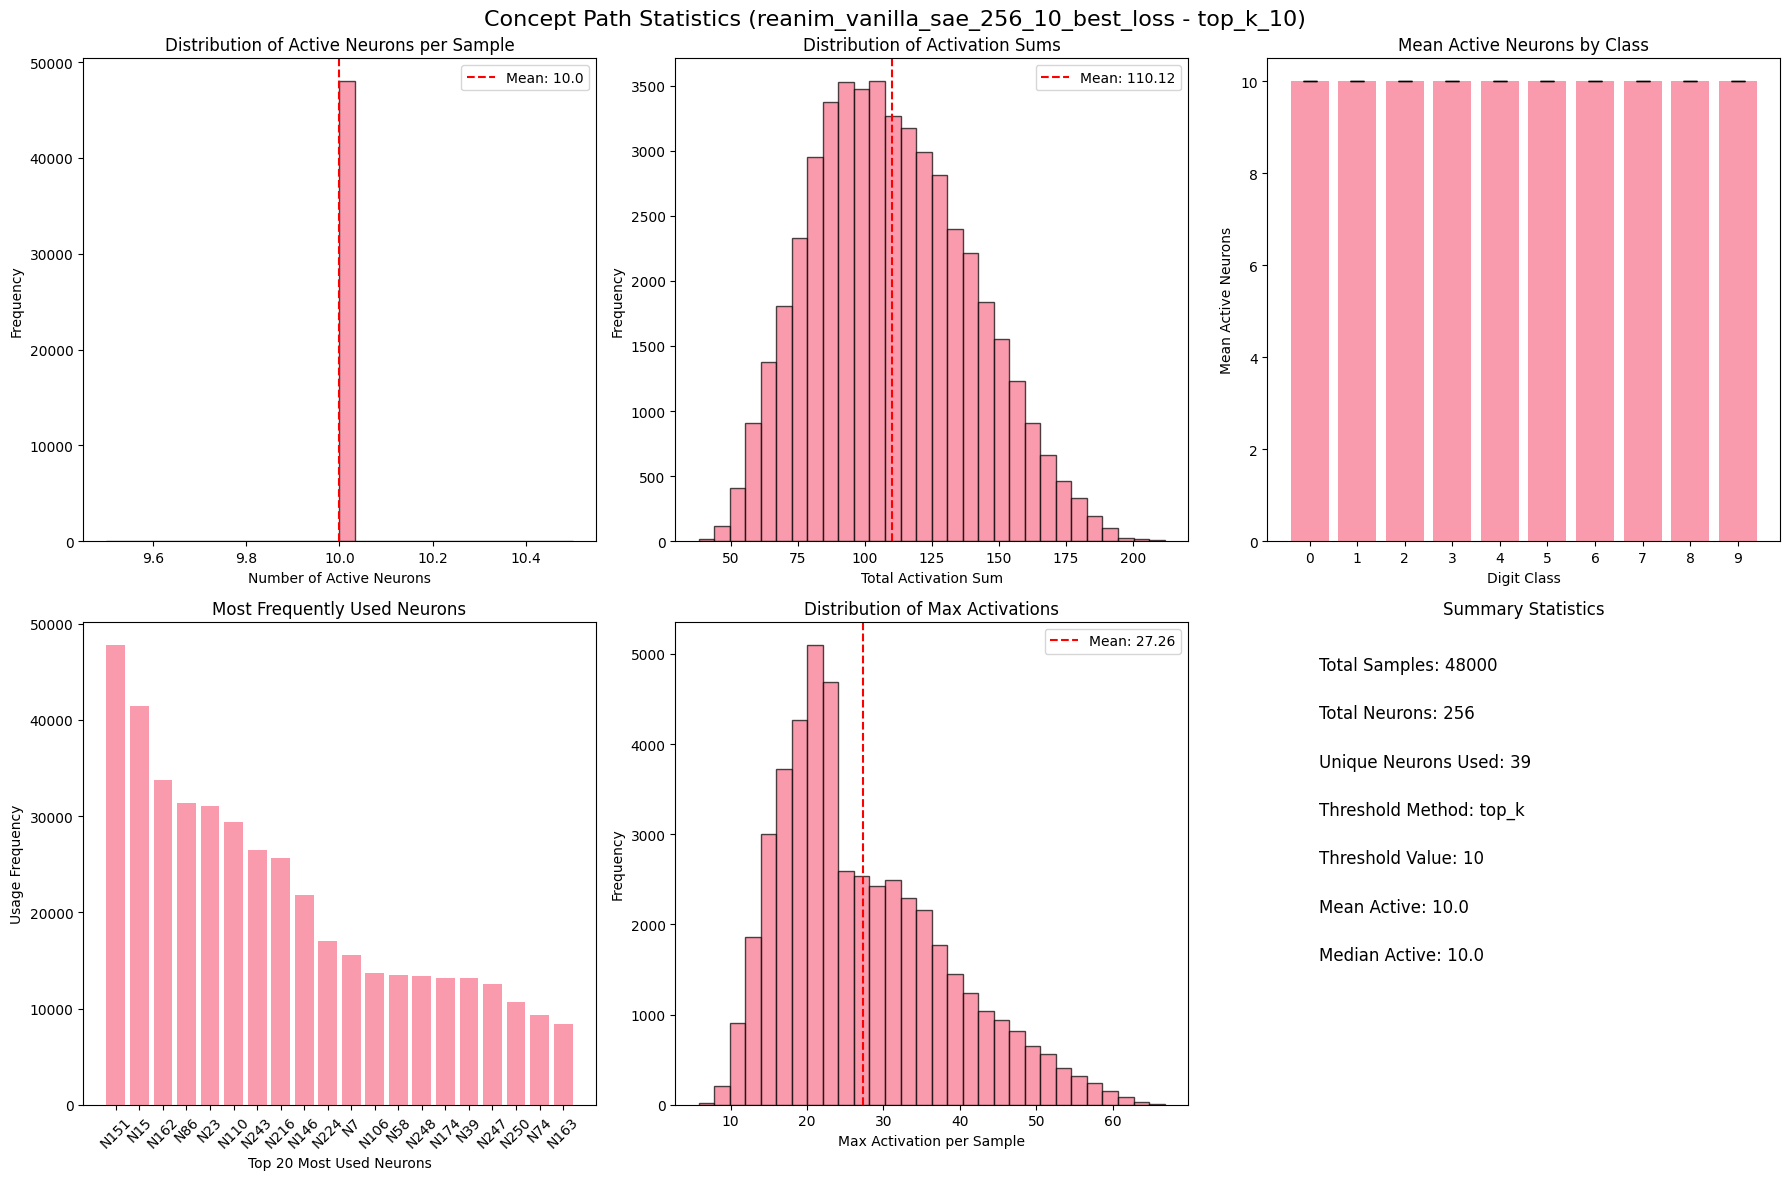


--- Analyzing config: top_k_20 ---


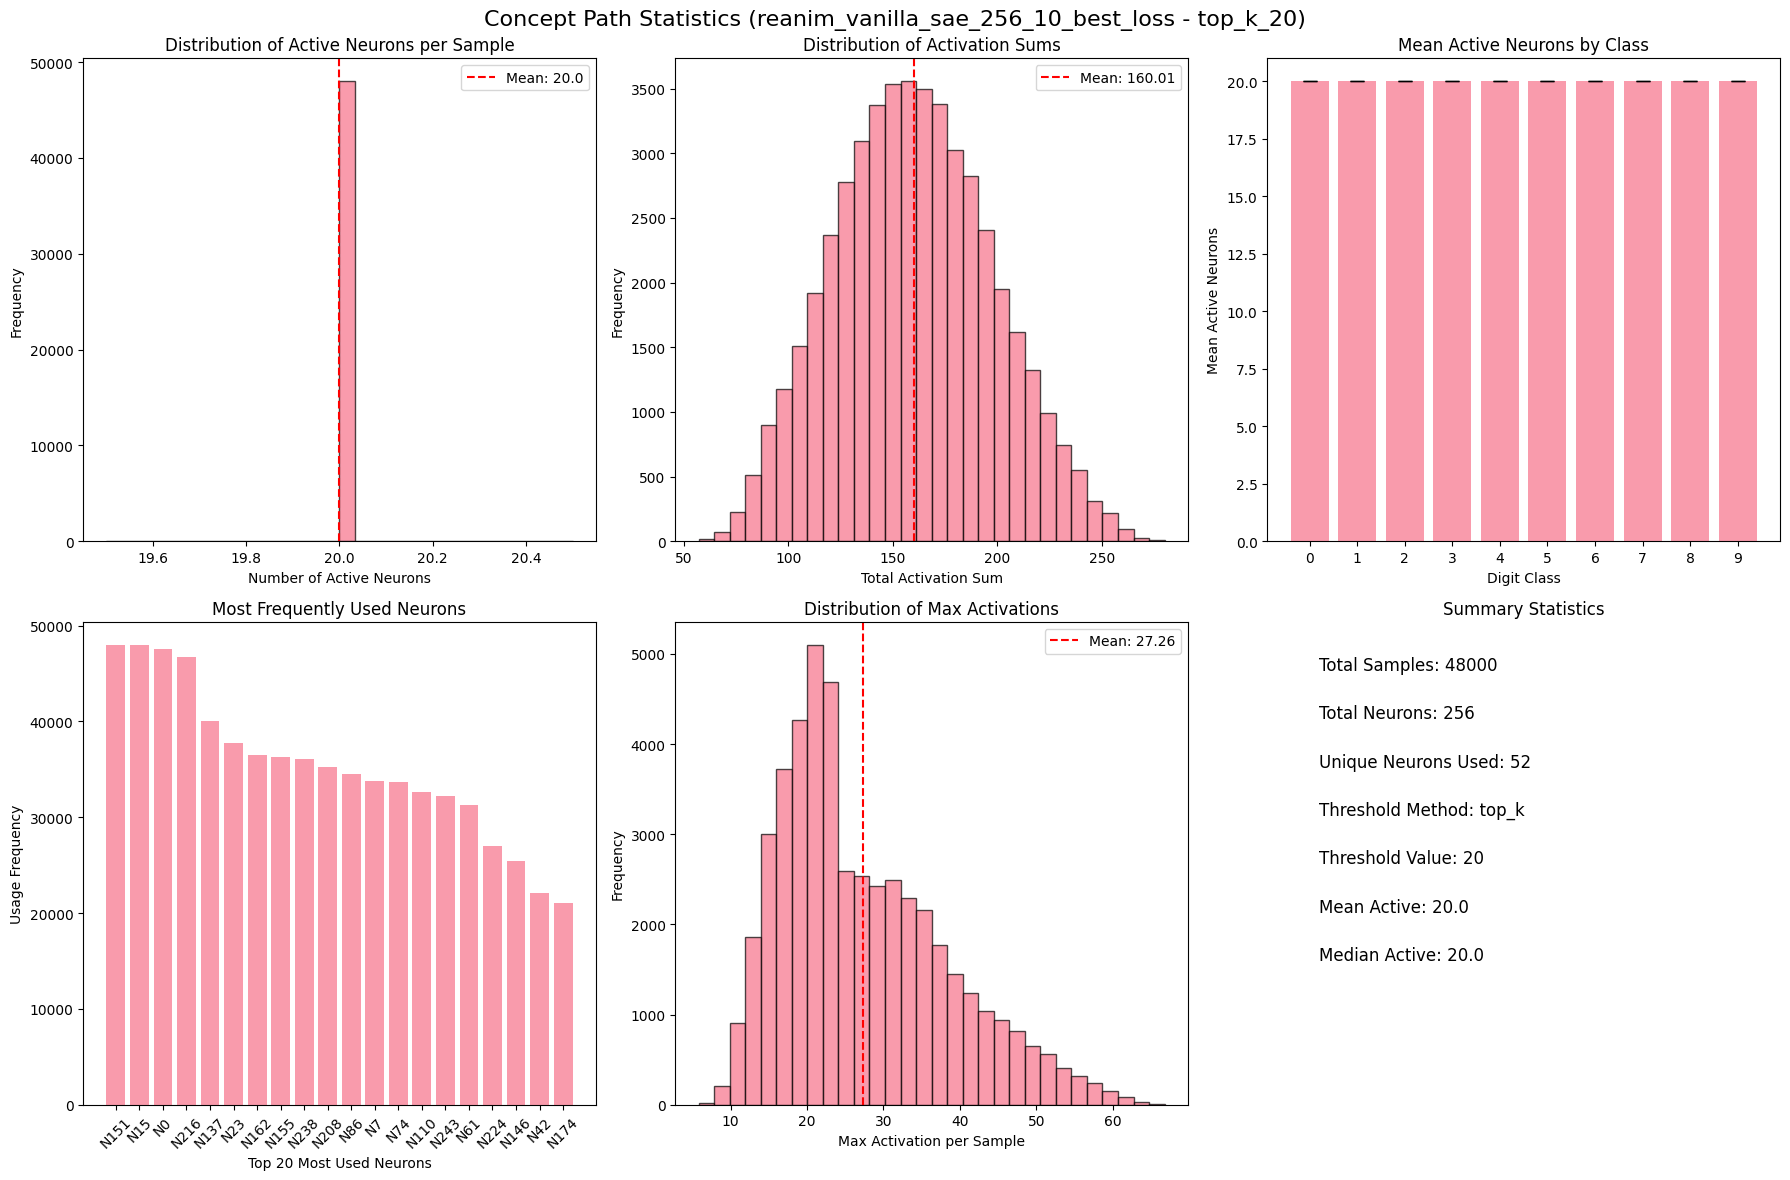


--- Analyzing config: percentile_90 ---


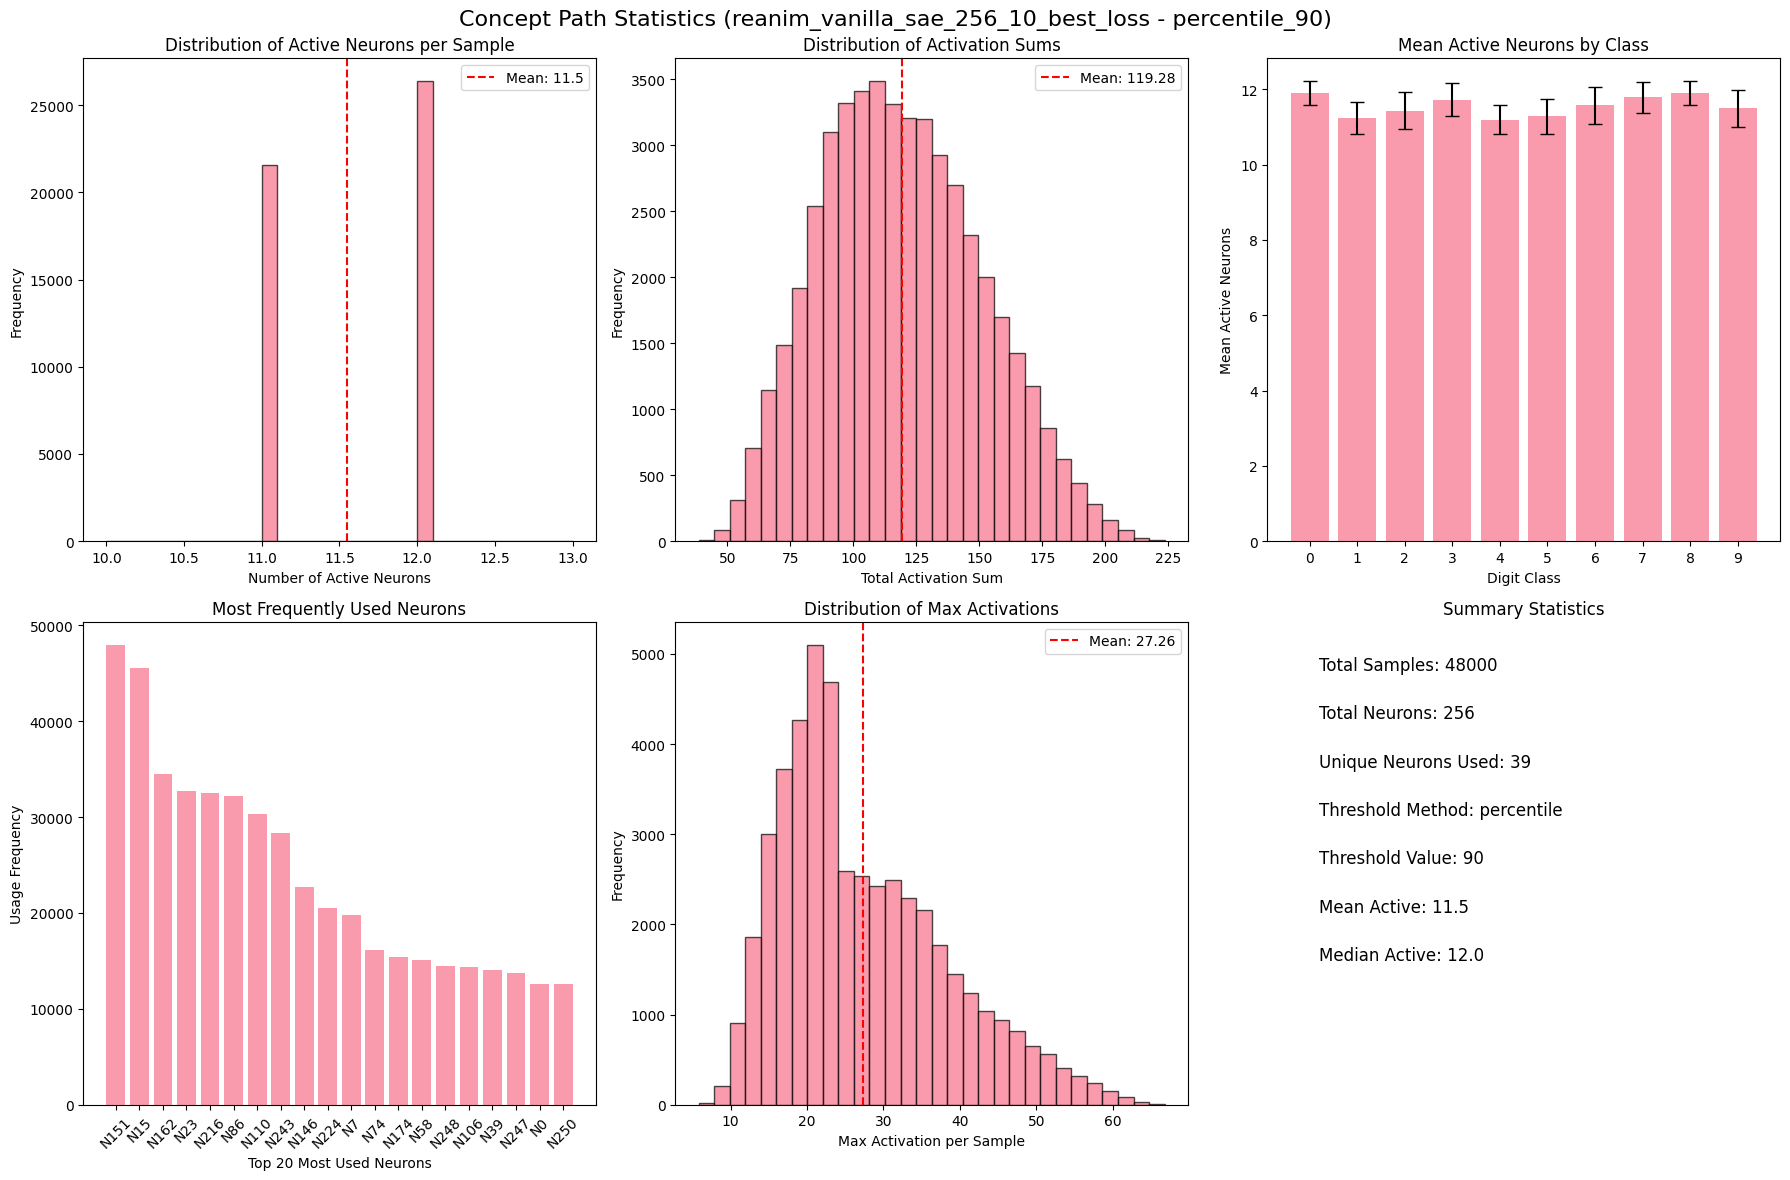


--- Analyzing config: std_threshold_1.5 ---


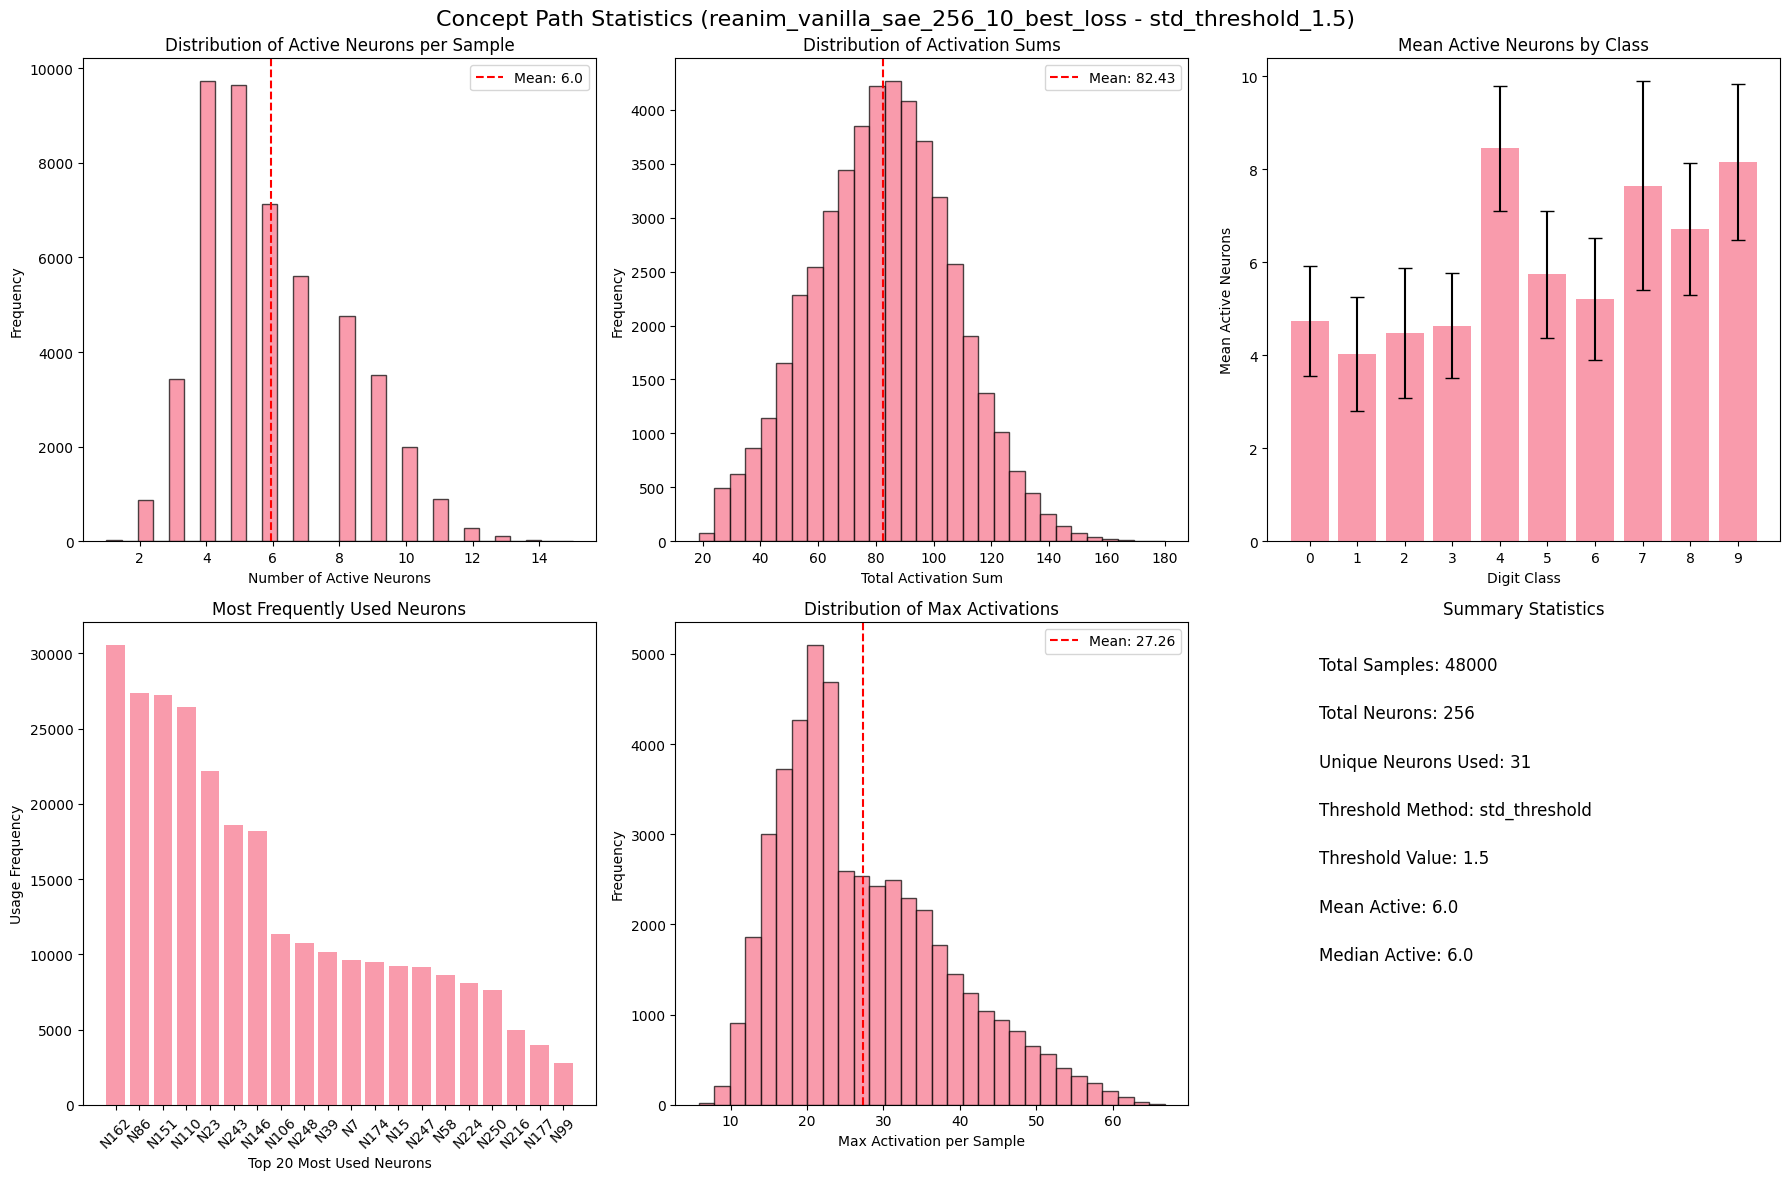


--- Comparing extraction methods for reanim_vanilla_sae_256_10_best_loss ---


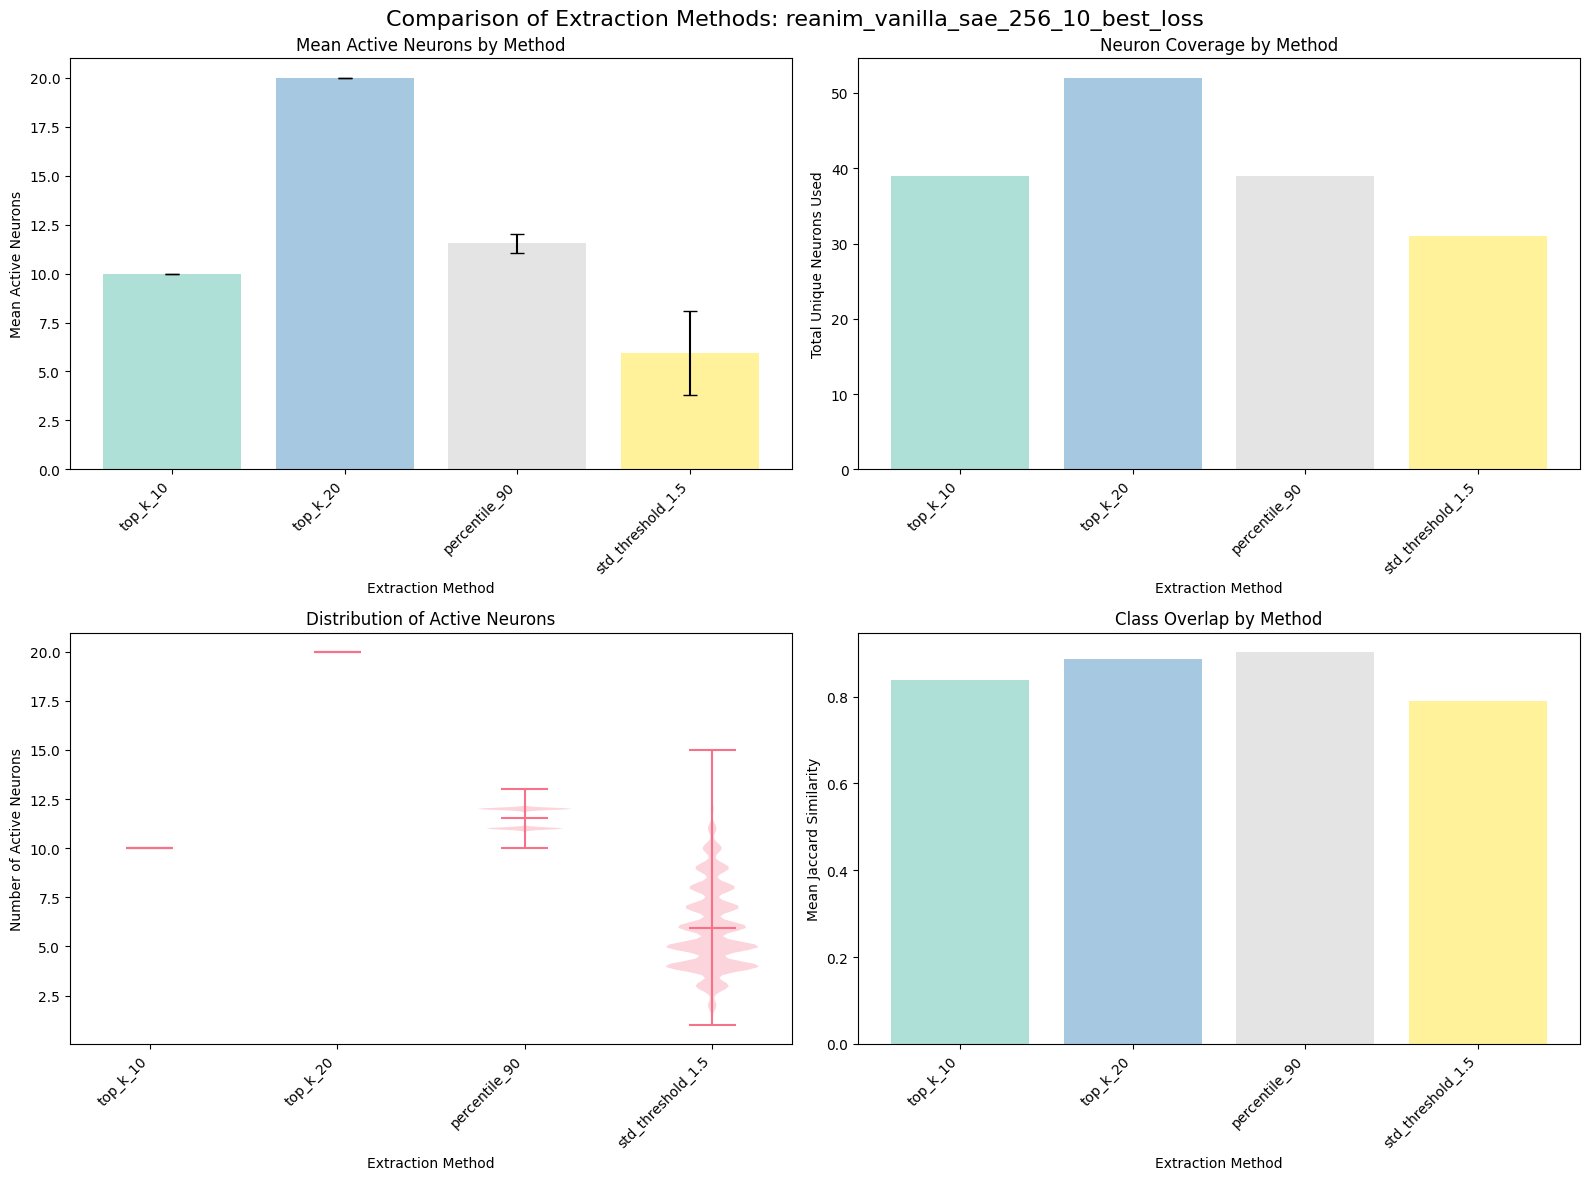


--- Summary across all SAEs ---


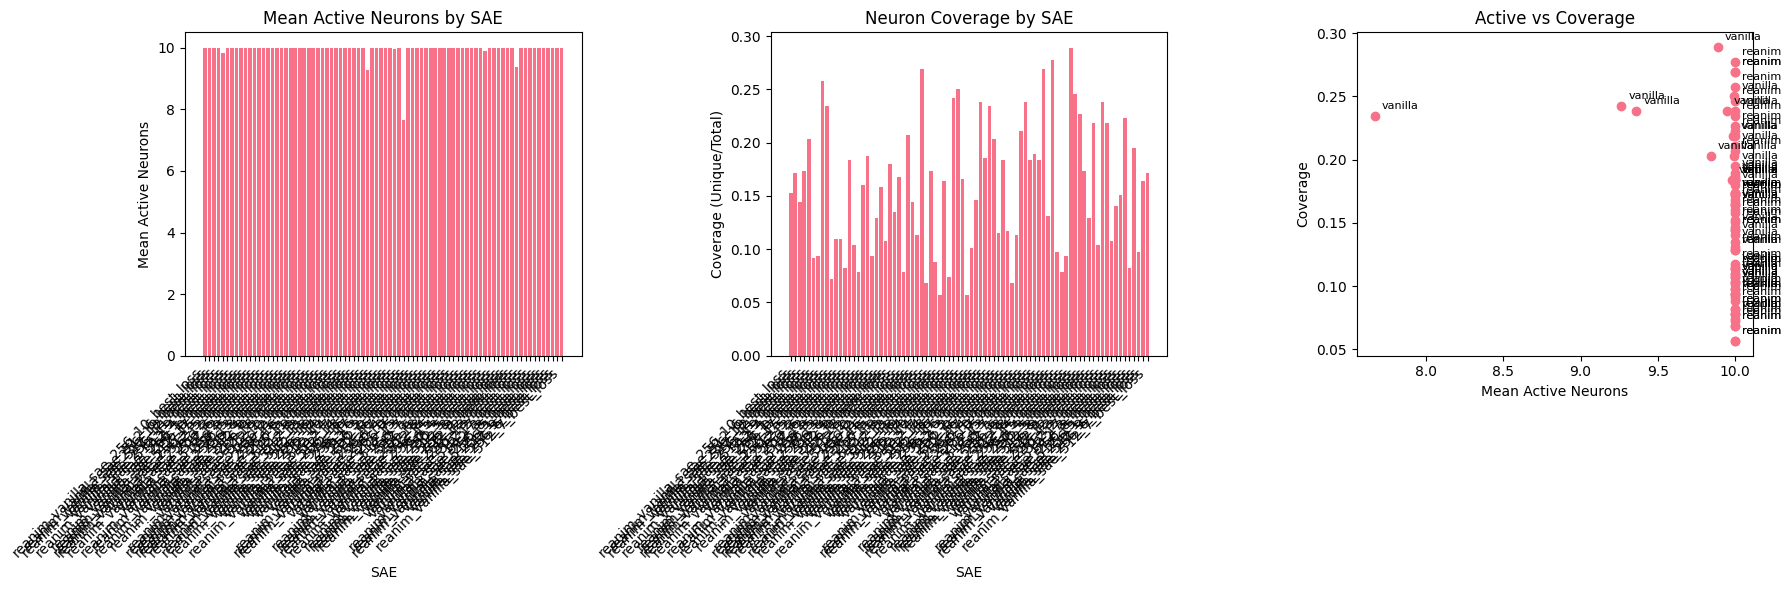


Summary Table:
                                    SAE    Config  Mean_Active  \
0   reanim_vanilla_sae_256_10_best_loss  top_k_10       10.000   
1    reanim_vanilla_sae_512_6_best_loss  top_k_10       10.000   
2   reanim_vanilla_sae_256_19_best_loss  top_k_10       10.000   
3          vanilla_sae_512_12_best_loss  top_k_10       10.000   
4          vanilla_sae_256_11_best_loss  top_k_10        9.842   
..                                  ...       ...          ...   
75  reanim_vanilla_sae_512_15_best_loss  top_k_10       10.000   
76          vanilla_sae_256_1_best_loss  top_k_10       10.000   
77          vanilla_sae_512_9_best_loss  top_k_10       10.000   
78          vanilla_sae_256_6_best_loss  top_k_10       10.000   
79   reanim_vanilla_sae_512_7_best_loss  top_k_10       10.000   

    Unique_Neurons  Total_Neurons  Coverage  
0               39            256     0.152  
1               88            512     0.172  
2               37            256     0.145  
3      

In [2]:
# ===== CONCEPT PATHS VISUALIZATION =====
# Run this cell to visualize concept paths from your SAE analysis

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

concept_paths_file = "../logs_vanilla_sae/concept_path_results.pkl"

try:
    with open(concept_paths_file, 'rb') as f:
        all_concept_paths = pickle.load(f)
    print(f"Loaded concept paths for {len(all_concept_paths)} SAEs")
    
    # Display available SAEs and configs
    for sae_name, configs in all_concept_paths.items():
        print(f"\n{sae_name}: {list(configs.keys())}")
        
except FileNotFoundError:
    print(f"File not found: {concept_paths_file}")
    print("Please update the concept_paths_file path above")
    # Create dummy data for demonstration
    all_concept_paths = {}

# ===== HELPER FUNCTIONS =====

def plot_concept_path_statistics(concept_paths_data, title_suffix=""):
    """Plot basic statistics about concept paths."""
    
    concept_paths = concept_paths_data['concept_paths']
    summary = concept_paths_data['summary']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Concept Path Statistics {title_suffix}', fontsize=16)
    
    num_active = [path['num_active'] for path in concept_paths]
    axes[0, 0].hist(num_active, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(np.mean(num_active), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(num_active):.1f}')
    axes[0, 0].set_xlabel('Number of Active Neurons')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Active Neurons per Sample')
    axes[0, 0].legend()
    
    # 2. Distribution of activation sums
    activation_sums = [path['activation_sum'] for path in concept_paths]
    axes[0, 1].hist(activation_sums, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(np.mean(activation_sums), color='red', linestyle='--',
                      label=f'Mean: {np.mean(activation_sums):.2f}')
    axes[0, 1].set_xlabel('Total Activation Sum')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Activation Sums')
    axes[0, 1].legend()
    
    # 3. Per-class statistics (if labels available)
    if 'class_statistics' in summary:
        class_stats = summary['class_statistics']
        classes = sorted(class_stats.keys())
        
        class_means = [class_stats[c]['mean_active_neurons'] for c in classes]
        class_stds = [class_stats[c]['std_active_neurons'] for c in classes]
        
        axes[0, 2].bar(classes, class_means, yerr=class_stds, capsize=5, alpha=0.7)
        axes[0, 2].set_xlabel('Digit Class')
        axes[0, 2].set_ylabel('Mean Active Neurons')
        axes[0, 2].set_title('Mean Active Neurons by Class')
        axes[0, 2].set_xticks(classes)
    
    # 4. Neuron usage frequency
    all_neurons = []
    for path in concept_paths:
        all_neurons.extend(path['active_neurons'])
    
    neuron_counts = Counter(all_neurons)
    top_neurons = dict(sorted(neuron_counts.items(), key=lambda x: x[1], reverse=True)[:20])
    
    axes[1, 0].bar(range(len(top_neurons)), list(top_neurons.values()), alpha=0.7)
    axes[1, 0].set_xlabel('Top 20 Most Used Neurons')
    axes[1, 0].set_ylabel('Usage Frequency')
    axes[1, 0].set_title('Most Frequently Used Neurons')
    axes[1, 0].set_xticks(range(len(top_neurons)))
    axes[1, 0].set_xticklabels([f'N{k}' for k in top_neurons.keys()], rotation=45)
    
    # 5. Max activation distribution
    max_activations = [path['max_activation'] for path in concept_paths]
    axes[1, 1].hist(max_activations, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(np.mean(max_activations), color='red', linestyle='--',
                      label=f'Mean: {np.mean(max_activations):.2f}')
    axes[1, 1].set_xlabel('Max Activation per Sample')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Max Activations')
    axes[1, 1].legend()
    
    # 6. Summary text
    axes[1, 2].text(0.1, 0.9, f"Total Samples: {summary['n_samples']}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.8, f"Total Neurons: {summary['n_neurons']}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.7, f"Unique Neurons Used: {summary['total_unique_neurons_used']}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.6, f"Threshold Method: {summary['threshold_method']}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.5, f"Threshold Value: {summary['threshold_value']}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.4, f"Mean Active: {summary['mean_active_neurons']:.1f}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].text(0.1, 0.3, f"Median Active: {summary['median_active_neurons']:.1f}", transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].set_title('Summary Statistics')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_class_overlap_heatmap(concept_paths_data, title_suffix=""):
    """Plot heatmap of class overlaps."""
    
    if 'overlap_analysis' not in concept_paths_data:
        print("No overlap analysis found in concept paths data")
        return
    
    overlap_data = concept_paths_data['overlap_analysis']['overlap_analysis']
    
    # Extract classes from overlap keys
    classes = set()
    for key in overlap_data.keys():
        parts = key.split('_')
        classes.add(int(parts[1]))
        classes.add(int(parts[3]))
    classes = sorted(classes)
    
    # Create matrices for different overlap metrics
    jaccard_matrix = np.zeros((len(classes), len(classes)))
    shared_neurons_matrix = np.zeros((len(classes), len(classes)))
    
    for key, data in overlap_data.items():
        parts = key.split('_')
        i, j = int(parts[1]), int(parts[3])
        i_idx, j_idx = classes.index(i), classes.index(j)
        
        jaccard_matrix[i_idx, j_idx] = data['jaccard_similarity']
        jaccard_matrix[j_idx, i_idx] = data['jaccard_similarity']  # Symmetric
        
        shared_neurons_matrix[i_idx, j_idx] = data['shared_neurons']
        shared_neurons_matrix[j_idx, i_idx] = data['shared_neurons']
    
    # Set diagonal to 1 for Jaccard (self-similarity)
    np.fill_diagonal(jaccard_matrix, 1.0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Jaccard similarity heatmap
    sns.heatmap(jaccard_matrix, 
                xticklabels=classes, yticklabels=classes,
                annot=True, fmt='.2f', cmap='Blues',
                ax=ax1, cbar_kws={'label': 'Jaccard Similarity'})
    ax1.set_title(f'Class Overlap: Jaccard Similarity {title_suffix}')
    ax1.set_xlabel('Digit Class')
    ax1.set_ylabel('Digit Class')
    
    # Shared neurons heatmap
    sns.heatmap(shared_neurons_matrix,
                xticklabels=classes, yticklabels=classes,
                annot=True, fmt='.0f', cmap='Reds',
                ax=ax2, cbar_kws={'label': 'Shared Neurons'})
    ax2.set_title(f'Class Overlap: Shared Neurons {title_suffix}')
    ax2.set_xlabel('Digit Class')
    ax2.set_ylabel('Digit Class')
    
    plt.tight_layout()
    plt.show()

def plot_neuron_class_specialization(concept_paths_data, top_n=20, title_suffix=""):
    """Plot which neurons are most specialized for each class."""
    
    concept_paths = concept_paths_data['concept_paths']
    summary = concept_paths_data['summary']
    
    if 'class_statistics' not in summary:
        print("No class statistics available")
        return
    
    # Count neuron usage per class
    class_neuron_usage = defaultdict(lambda: defaultdict(int))
    
    for path in concept_paths:
        if 'label' in path:
            label = path['label']
            for neuron_idx in path['active_neurons']:
                class_neuron_usage[label][neuron_idx] += 1
    
    # Find most specialized neurons for each class
    classes = sorted(class_neuron_usage.keys())
    n_classes = len(classes)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, class_label in enumerate(classes):
        if i >= len(axes):
            break
            
        neuron_counts = class_neuron_usage[class_label]
        
        # Get top neurons for this class
        top_neurons = sorted(neuron_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        if not top_neurons:
            continue
            
        neurons, counts = zip(*top_neurons)
        
        axes[i].bar(range(len(neurons)), counts, alpha=0.7)
        axes[i].set_title(f'Class {class_label}: Top {top_n} Neurons')
        axes[i].set_xlabel('Neuron Rank')
        axes[i].set_ylabel('Usage Count')
        axes[i].set_xticks(range(min(10, len(neurons))))
        axes[i].set_xticklabels([f'N{n}' for n in neurons[:10]], rotation=45)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    fig.suptitle(f'Neuron Specialization by Class {title_suffix}', fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_extraction_methods(sae_concept_paths, sae_name):
    """Compare different concept path extraction methods for the same SAE."""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Comparison of Extraction Methods: {sae_name}', fontsize=16)
    
    methods = list(sae_concept_paths.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    
    # 1. Mean active neurons comparison
    method_names = []
    mean_active = []
    std_active = []
    
    for method in methods:
        data = sae_concept_paths[method]
        method_names.append(method)
        mean_active.append(data['summary']['mean_active_neurons'])
        std_active.append(data['summary']['std_active_neurons'])
    
    bars = axes[0, 0].bar(range(len(method_names)), mean_active, 
                         yerr=std_active, capsize=5, alpha=0.7, color=colors)
    axes[0, 0].set_xlabel('Extraction Method')
    axes[0, 0].set_ylabel('Mean Active Neurons')
    axes[0, 0].set_title('Mean Active Neurons by Method')
    axes[0, 0].set_xticks(range(len(method_names)))
    axes[0, 0].set_xticklabels(method_names, rotation=45, ha='right')
    
    # 2. Total unique neurons used
    unique_neurons = [sae_concept_paths[method]['summary']['total_unique_neurons_used'] 
                     for method in methods]
    
    axes[0, 1].bar(range(len(method_names)), unique_neurons, alpha=0.7, color=colors)
    axes[0, 1].set_xlabel('Extraction Method')
    axes[0, 1].set_ylabel('Total Unique Neurons Used')
    axes[0, 1].set_title('Neuron Coverage by Method')
    axes[0, 1].set_xticks(range(len(method_names)))
    axes[0, 1].set_xticklabels(method_names, rotation=45, ha='right')
    
    # 3. Distribution of active neurons (violin plot)
    all_num_active = []
    method_labels = []
    
    for method in methods:
        concept_paths = sae_concept_paths[method]['concept_paths']
        num_active = [path['num_active'] for path in concept_paths]
        all_num_active.extend(num_active)
        method_labels.extend([method] * len(num_active))
    
    # Create dataframe for seaborn
    df = pd.DataFrame({'Method': method_labels, 'Active_Neurons': all_num_active})
    
    # Use matplotlib for violin plot instead of seaborn to avoid dependency issues
    method_data = [df[df['Method'] == method]['Active_Neurons'].values for method in methods]
    
    parts = axes[1, 0].violinplot(method_data, positions=range(len(methods)), showmeans=True)
    axes[1, 0].set_xlabel('Extraction Method')
    axes[1, 0].set_ylabel('Number of Active Neurons')
    axes[1, 0].set_title('Distribution of Active Neurons')
    axes[1, 0].set_xticks(range(len(method_names)))
    axes[1, 0].set_xticklabels(method_names, rotation=45, ha='right')
    
    # 4. Mean overlap between classes (if available)
    mean_overlaps = []
    for method in methods:
        if 'overlap_analysis' in sae_concept_paths[method]:
            overlap_data = sae_concept_paths[method]['overlap_analysis']
            if 'summary' in overlap_data:
                mean_overlaps.append(overlap_data['summary']['mean_jaccard'])
            else:
                mean_overlaps.append(0)
        else:
            mean_overlaps.append(0)
    
    if any(overlap > 0 for overlap in mean_overlaps):
        axes[1, 1].bar(range(len(method_names)), mean_overlaps, alpha=0.7, color=colors)
        axes[1, 1].set_xlabel('Extraction Method')
        axes[1, 1].set_ylabel('Mean Jaccard Similarity')
        axes[1, 1].set_title('Class Overlap by Method')
        axes[1, 1].set_xticks(range(len(method_names)))
        axes[1, 1].set_xticklabels(method_names, rotation=45, ha='right')
    else:
        axes[1, 1].text(0.5, 0.5, 'No overlap data available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Class Overlap by Method')
    
    plt.tight_layout()
    plt.show()

# ===== MAIN VISUALIZATION CODE =====

if all_concept_paths:
    print("=== CONCEPT PATHS VISUALIZATION ===\n")
    
    # Select which SAE and config to visualize
    sae_names = list(all_concept_paths.keys())
    print("Available SAEs:")
    for i, name in enumerate(sae_names):
        print(f"{i}: {name}")
    
    # Visualize the first SAE (change index as needed)
    selected_sae_idx = 0
    selected_sae = sae_names[selected_sae_idx]
    
    print(f"\nVisualizing: {selected_sae}")
    
    # Get available configs for this SAE
    configs = list(all_concept_paths[selected_sae].keys())
    print(f"Available configs: {configs}")
    
    # Visualize each config
    for config in configs:
        print(f"\n--- Analyzing config: {config} ---")
        concept_paths_data = all_concept_paths[selected_sae][config]
        
        # Basic statistics
        plot_concept_path_statistics(concept_paths_data, f"({selected_sae} - {config})")
        
        # Class overlap heatmap
        # plot_class_overlap_heatmap(concept_paths_data, f"({selected_sae} - {config})")
        
        # # Neuron specialization
        # plot_neuron_class_specialization(concept_paths_data, f"({selected_sae} - {config})")
    
    # Compare different extraction methods for the same SAE
    print(f"\n--- Comparing extraction methods for {selected_sae} ---")
    compare_extraction_methods(all_concept_paths[selected_sae], selected_sae)
    
    # Summary comparison across all SAEs (first config only)
    print("\n--- Summary across all SAEs ---")
    
    summary_data = []
    for sae_name, configs in all_concept_paths.items():
        first_config = list(configs.keys())[0]
        summary = configs[first_config]['summary']
        summary_data.append({
            'SAE': sae_name,
            'Config': first_config,
            'Mean_Active': summary['mean_active_neurons'],
            'Unique_Neurons': summary['total_unique_neurons_used'],
            'Total_Neurons': summary['n_neurons'],
            'Coverage': summary['total_unique_neurons_used'] / summary['n_neurons']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Plot summary comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].bar(range(len(summary_df)), summary_df['Mean_Active'])
    axes[0].set_title('Mean Active Neurons by SAE')
    axes[0].set_xlabel('SAE')
    axes[0].set_ylabel('Mean Active Neurons')
    axes[0].set_xticks(range(len(summary_df)))
    axes[0].set_xticklabels(summary_df['SAE'], rotation=45, ha='right')
    
    axes[1].bar(range(len(summary_df)), summary_df['Coverage'])
    axes[1].set_title('Neuron Coverage by SAE')
    axes[1].set_xlabel('SAE')
    axes[1].set_ylabel('Coverage (Unique/Total)')
    axes[1].set_xticks(range(len(summary_df)))
    axes[1].set_xticklabels(summary_df['SAE'], rotation=45, ha='right')
    
    axes[2].scatter(summary_df['Mean_Active'], summary_df['Coverage'])
    axes[2].set_xlabel('Mean Active Neurons')
    axes[2].set_ylabel('Coverage')
    axes[2].set_title('Active vs Coverage')
    
    # Add SAE names as labels
    for i, sae in enumerate(summary_df['SAE']):
        axes[2].annotate(sae.split('_')[0], 
                        (summary_df['Mean_Active'].iloc[i], summary_df['Coverage'].iloc[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary Table:")
    print(summary_df.round(3))

else:
    print("No concept paths data loaded. Please check the file path and run the cell again.")


In [2]:
import pickle 

concept_paths_file = "../logs_vanilla_sae/concept_path_results.pkl"

with open(concept_paths_file, 'rb') as f:
    all_concept_paths = pickle.load(f)

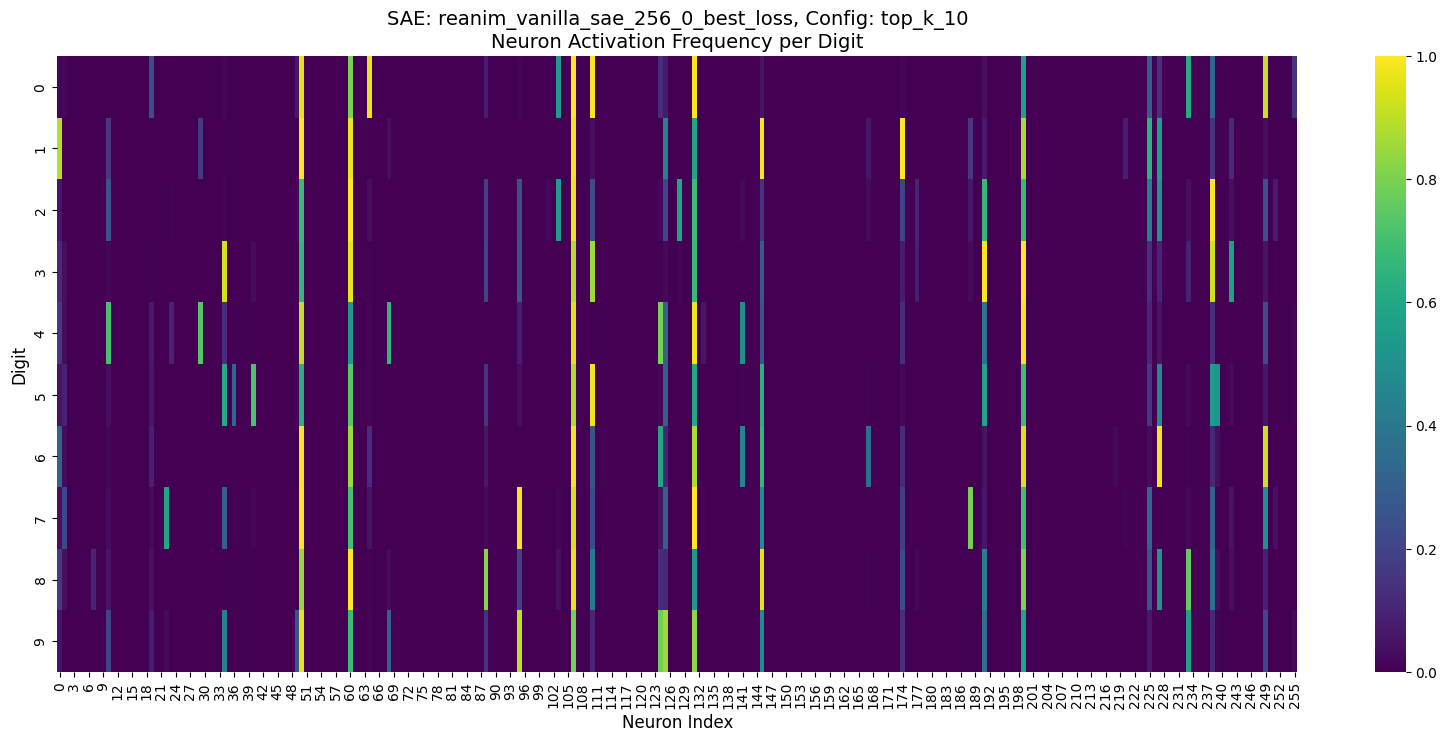

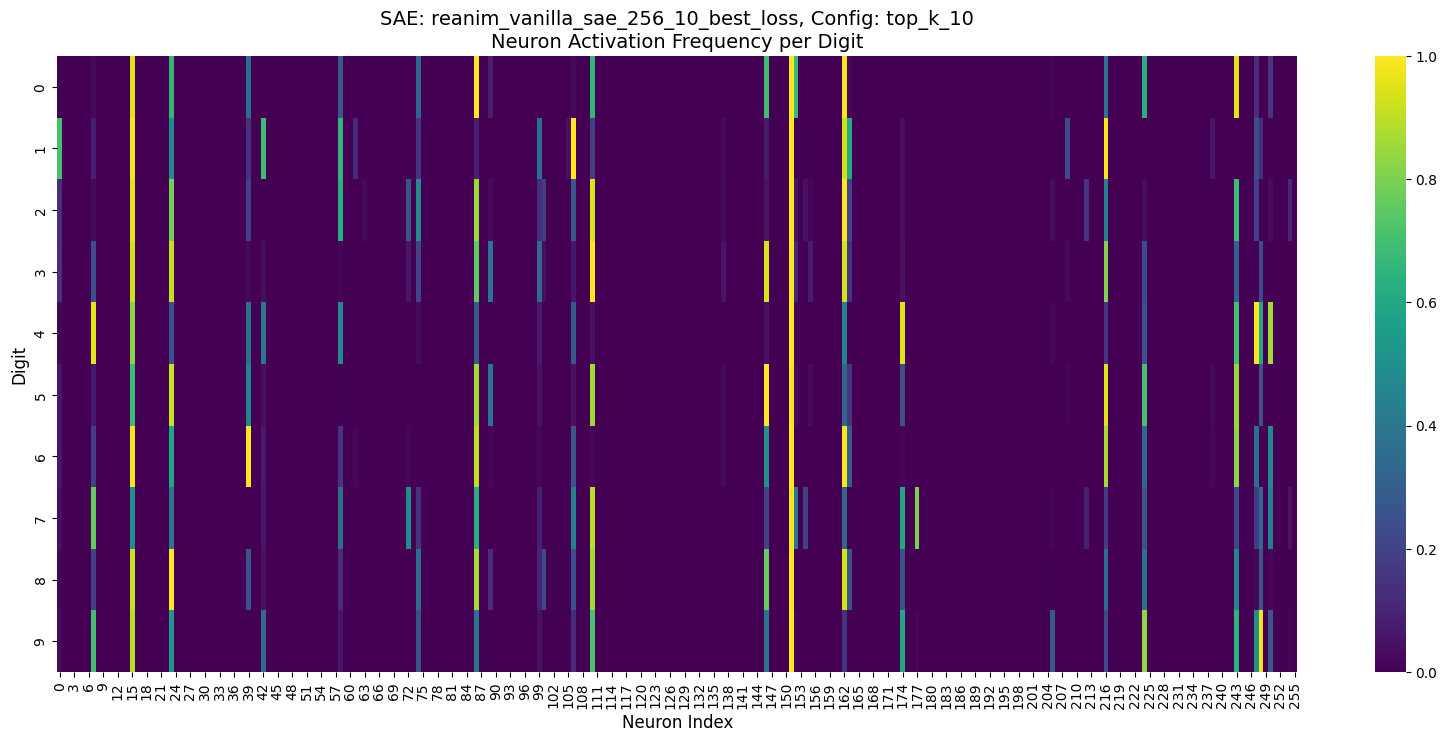

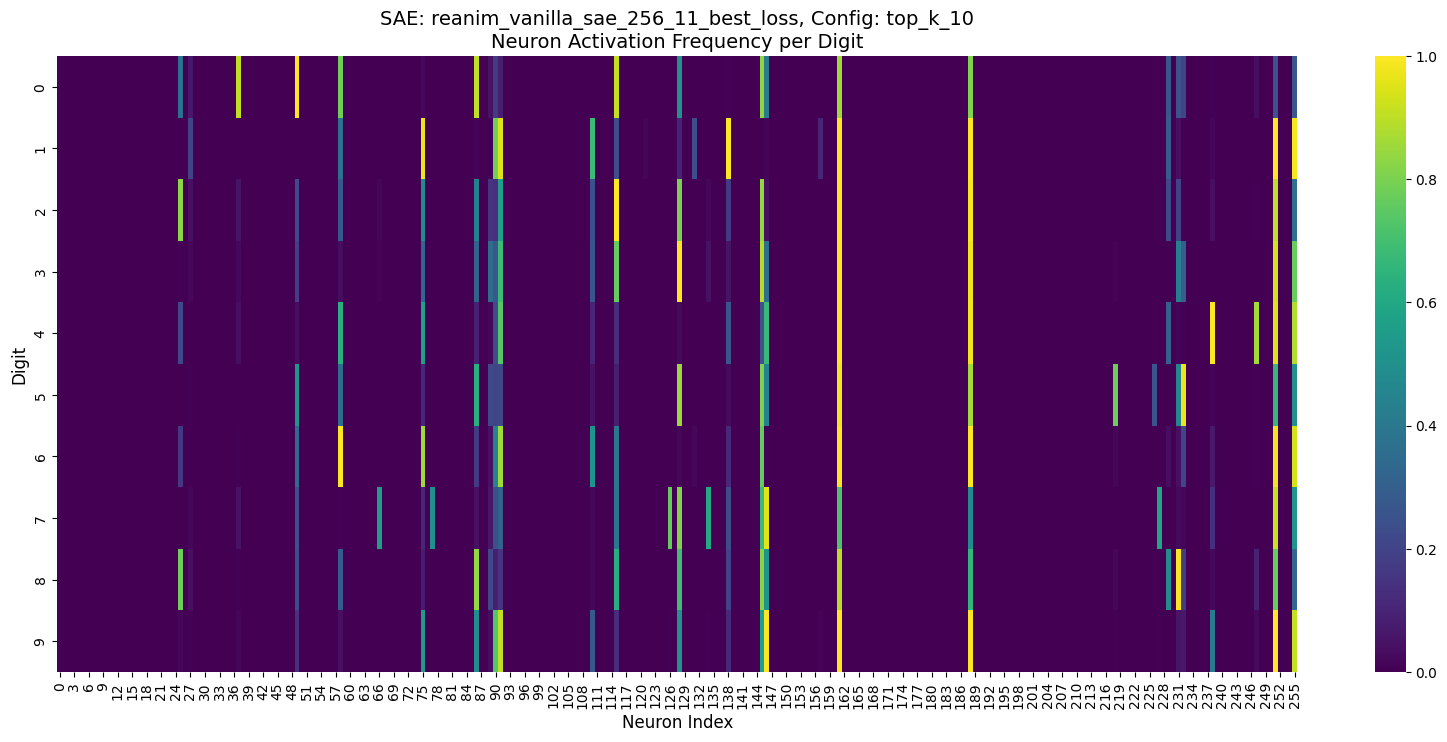

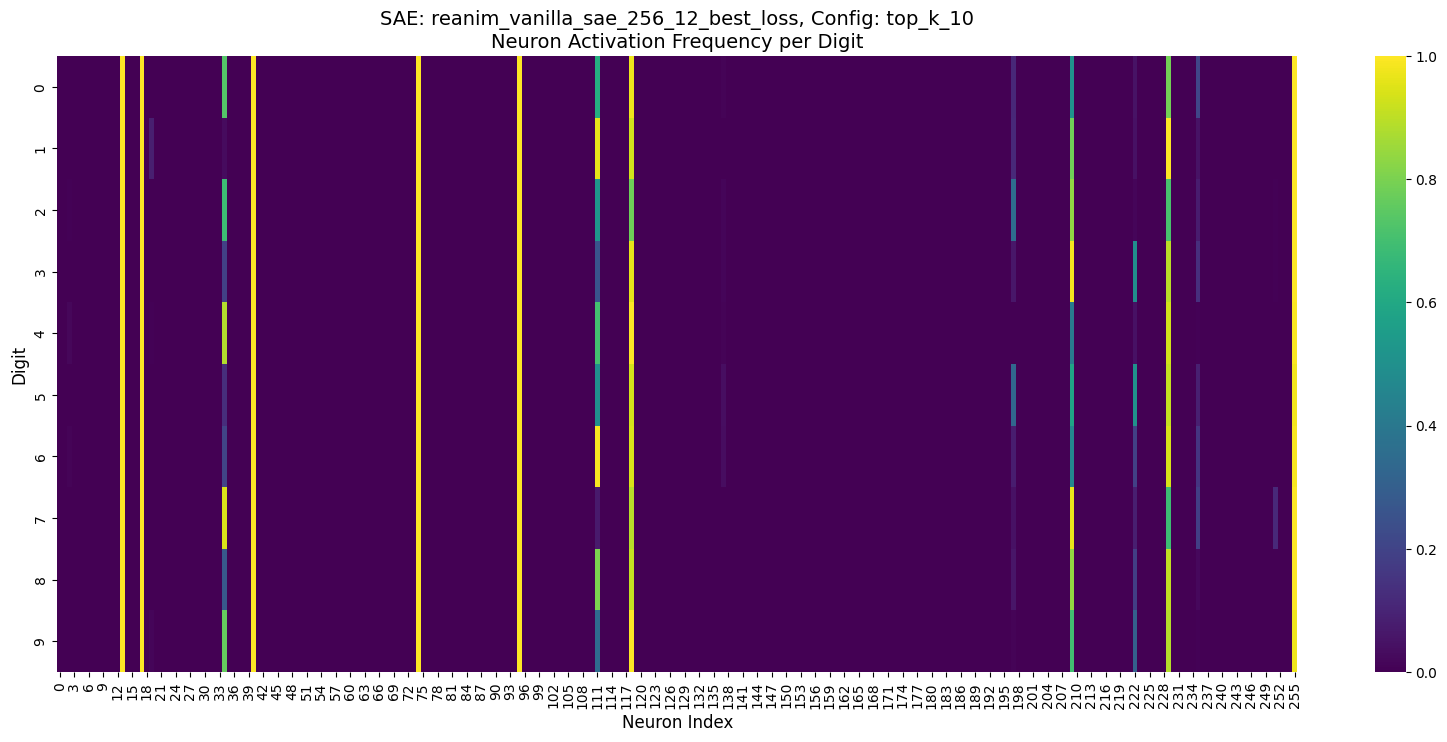

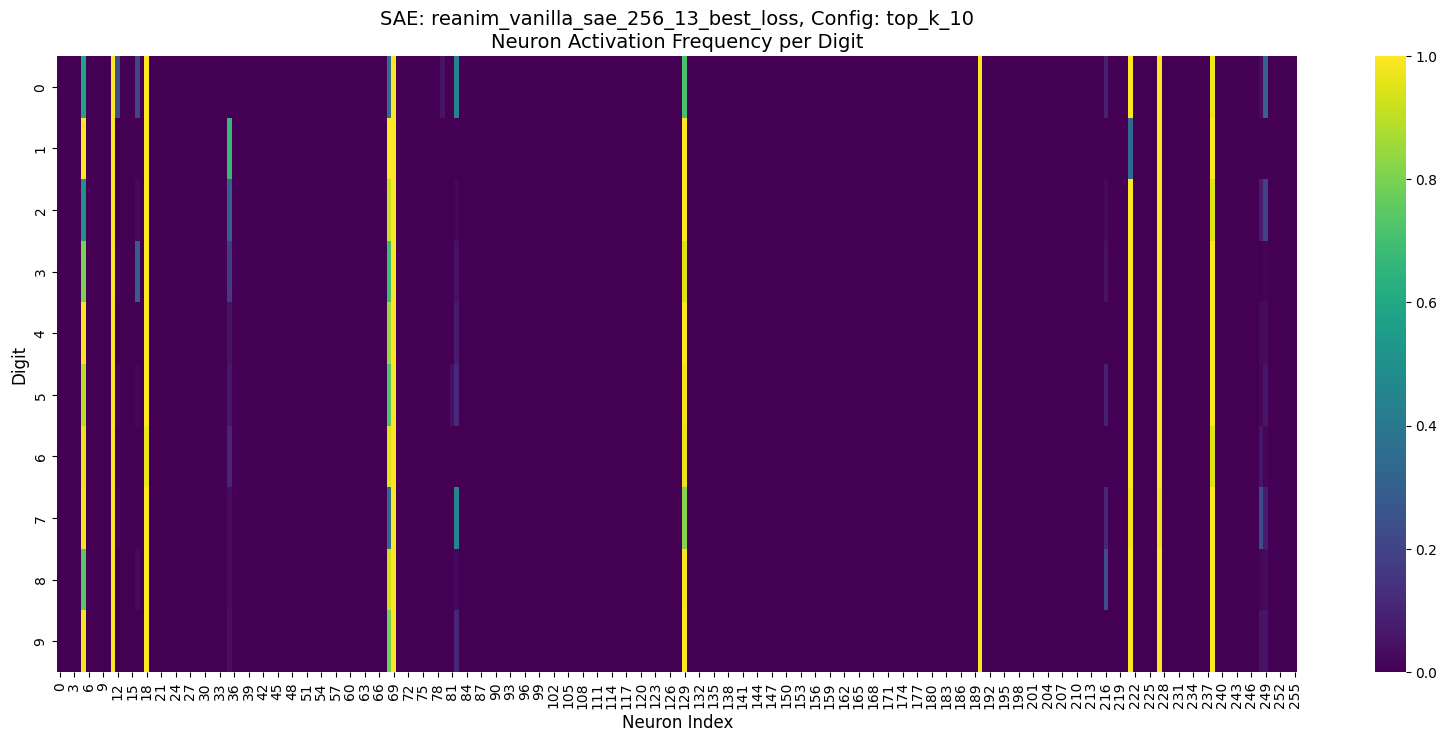

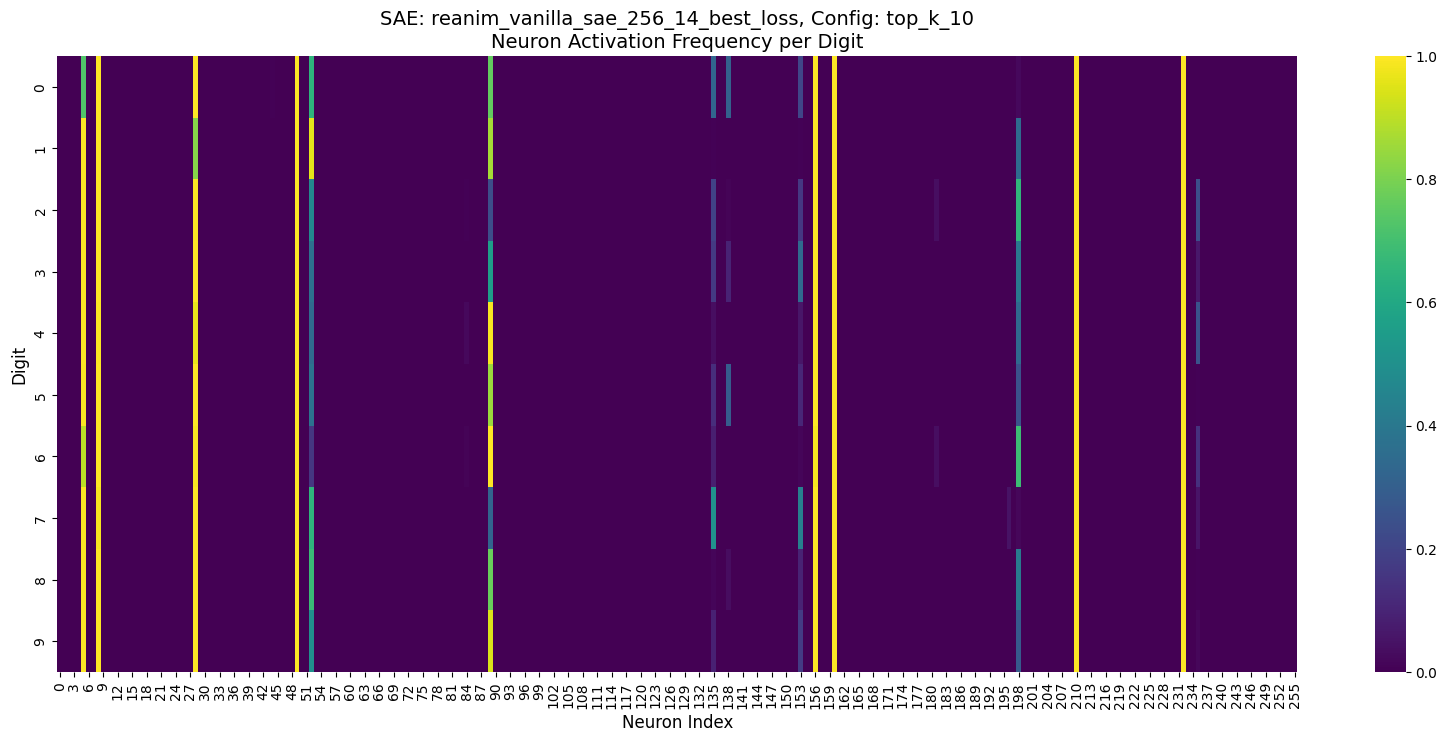

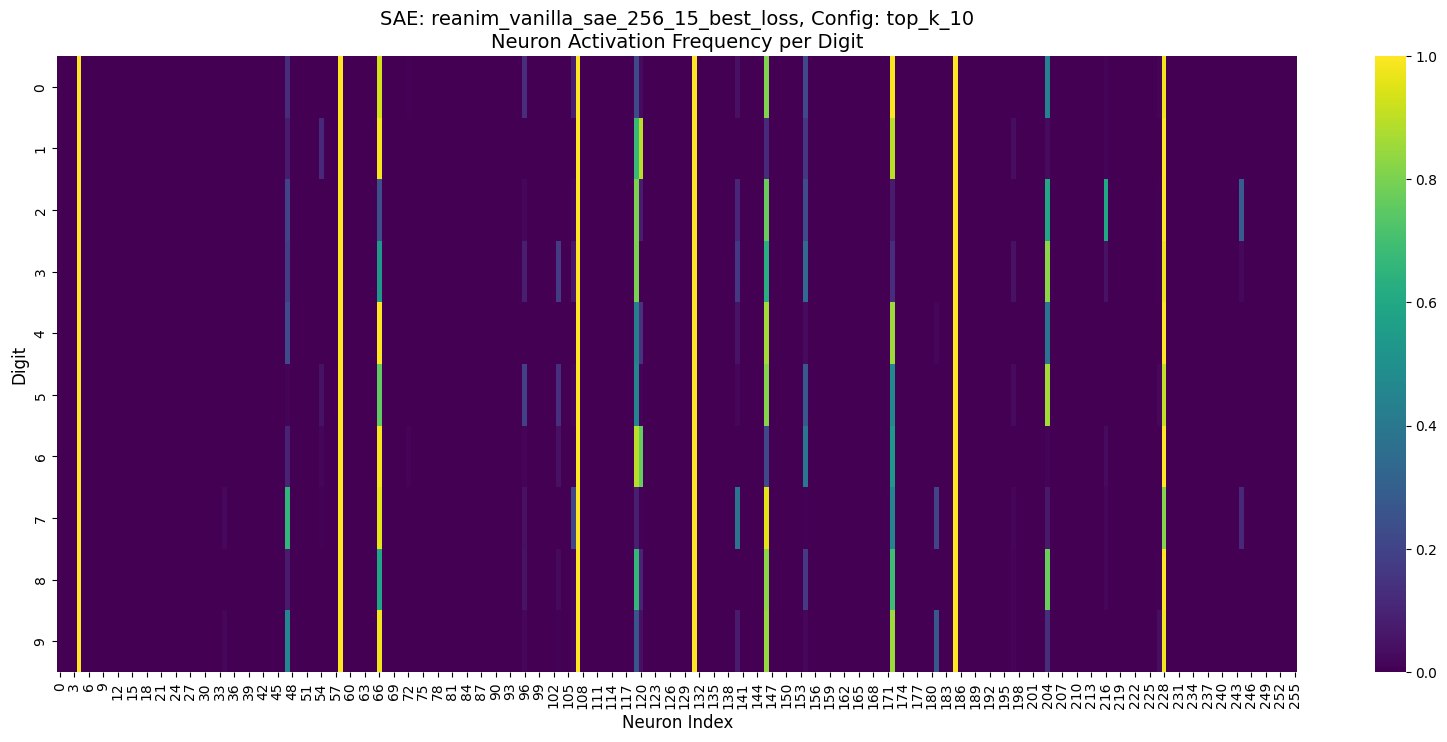

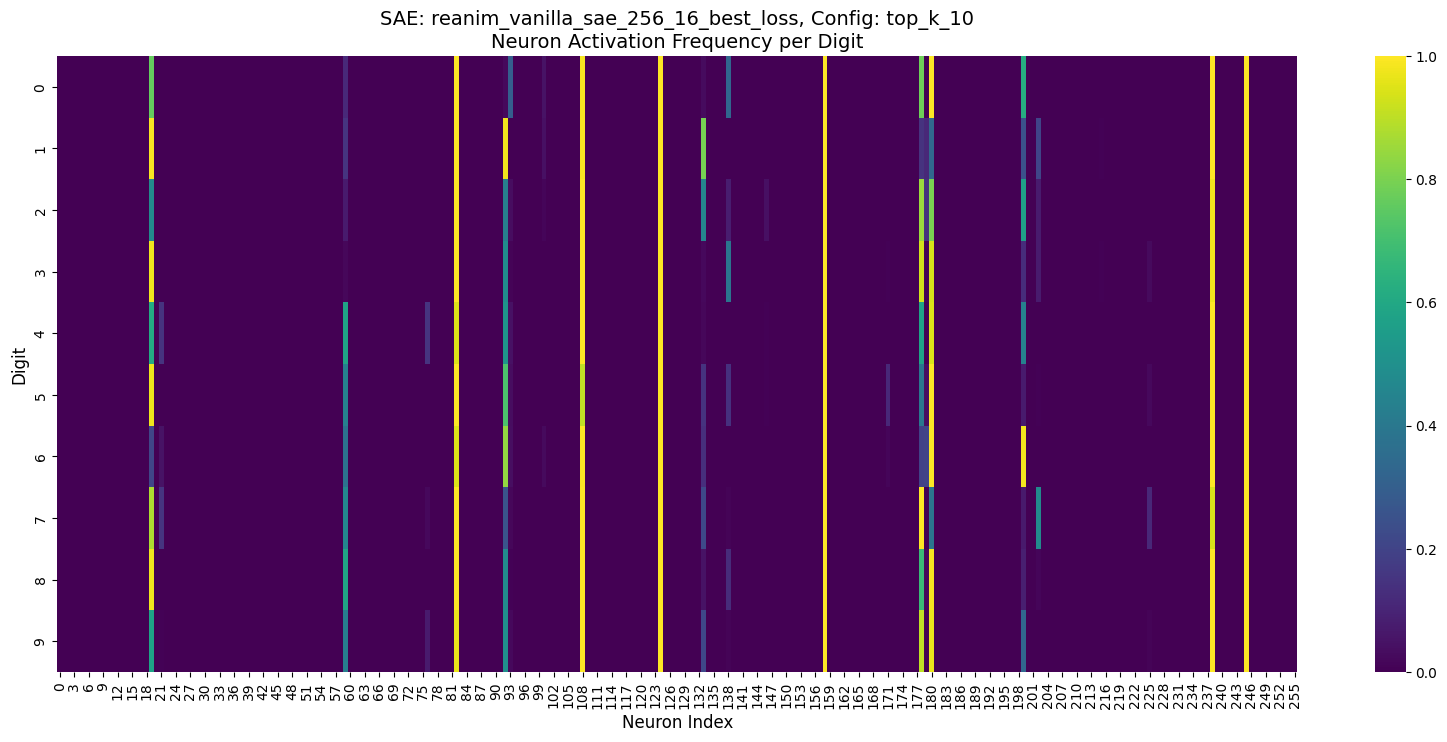

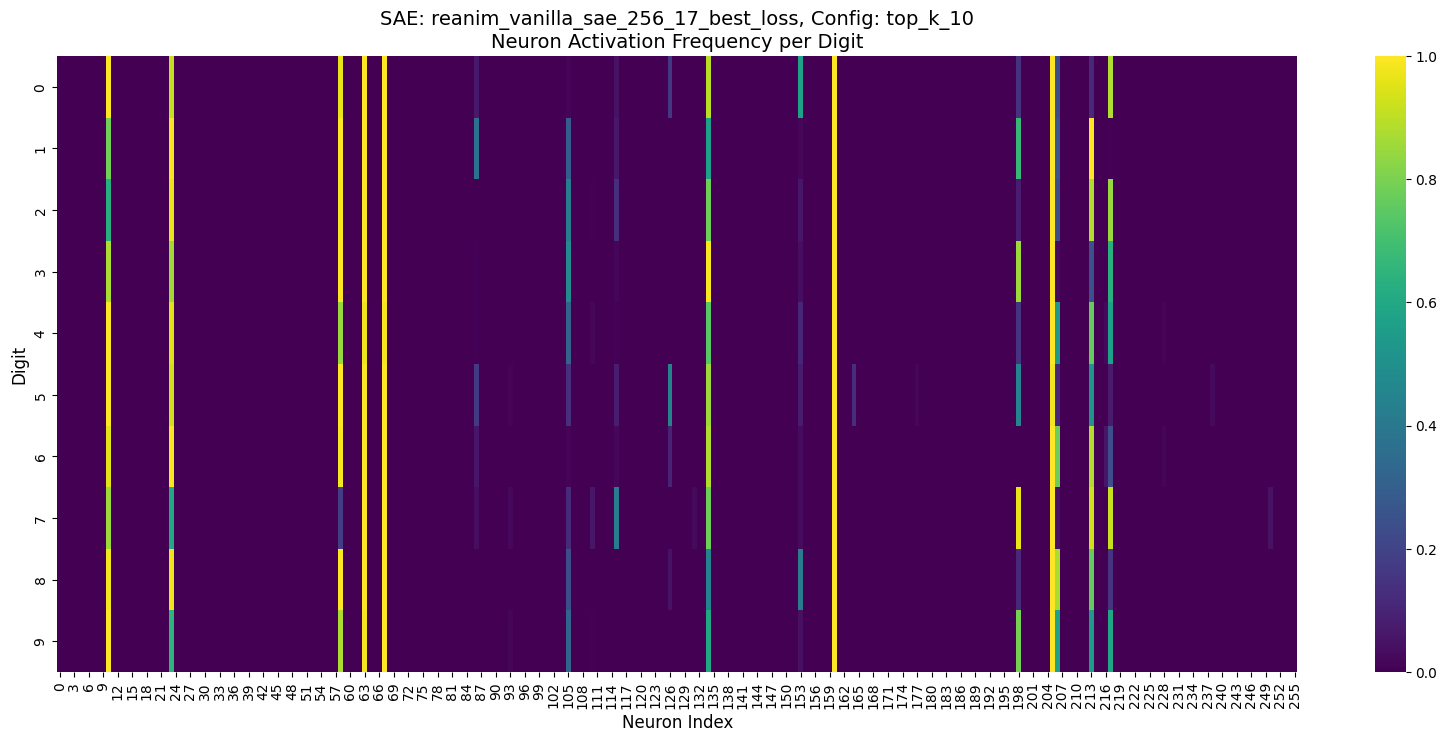

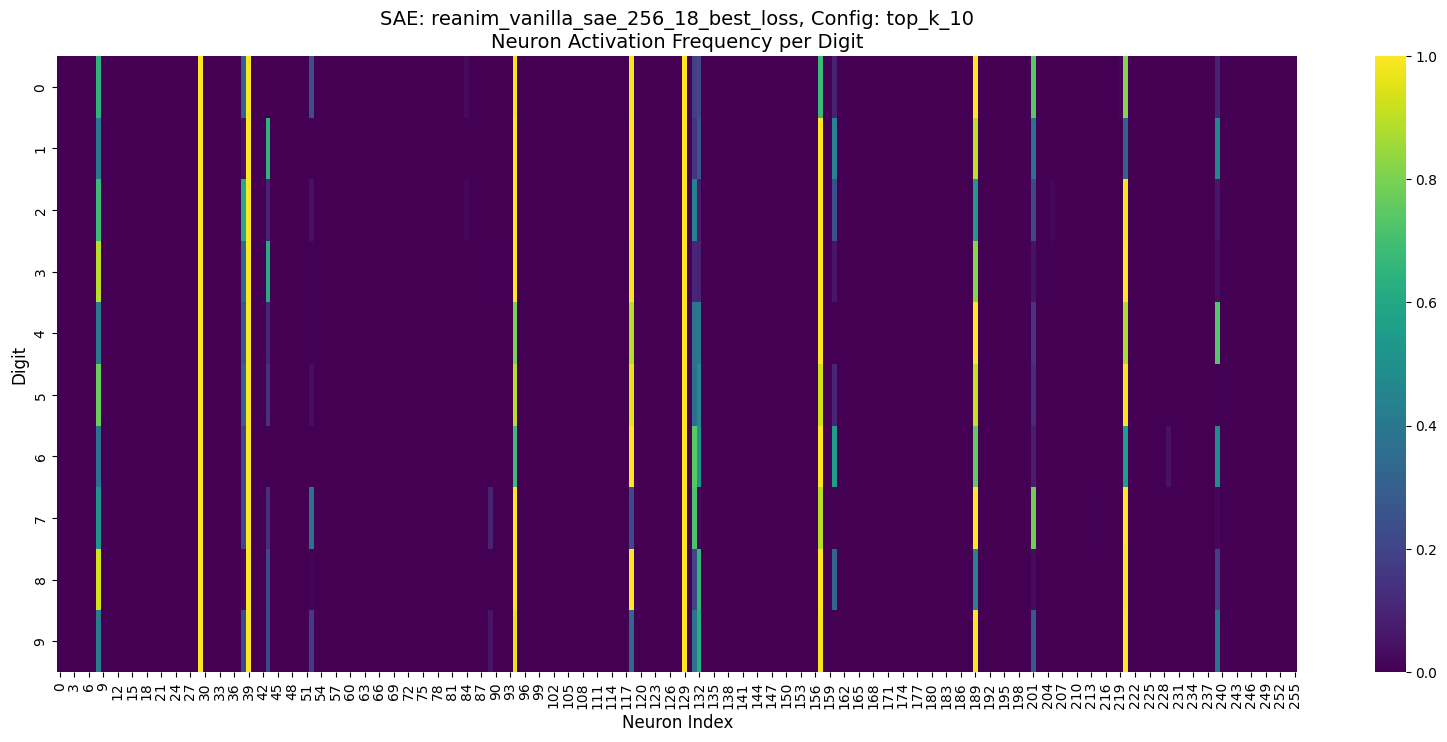

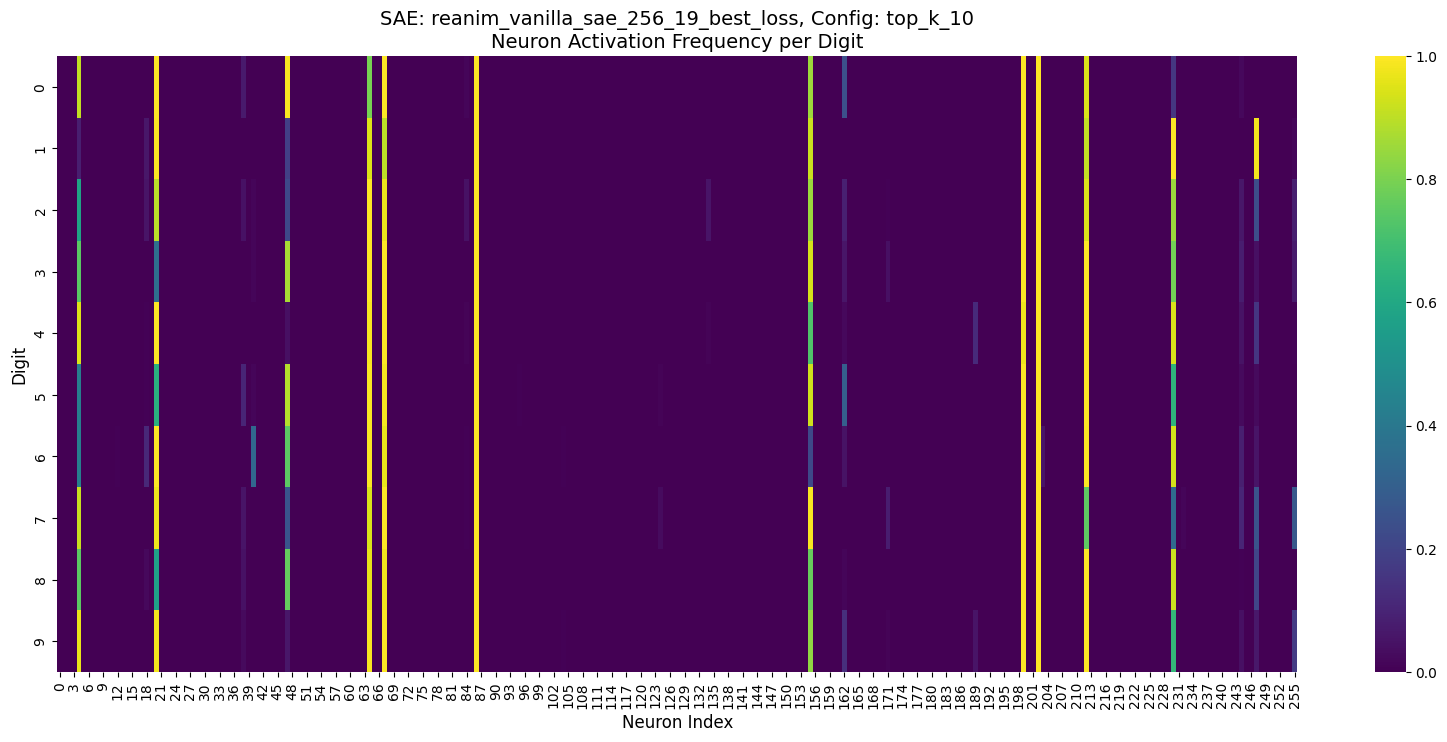

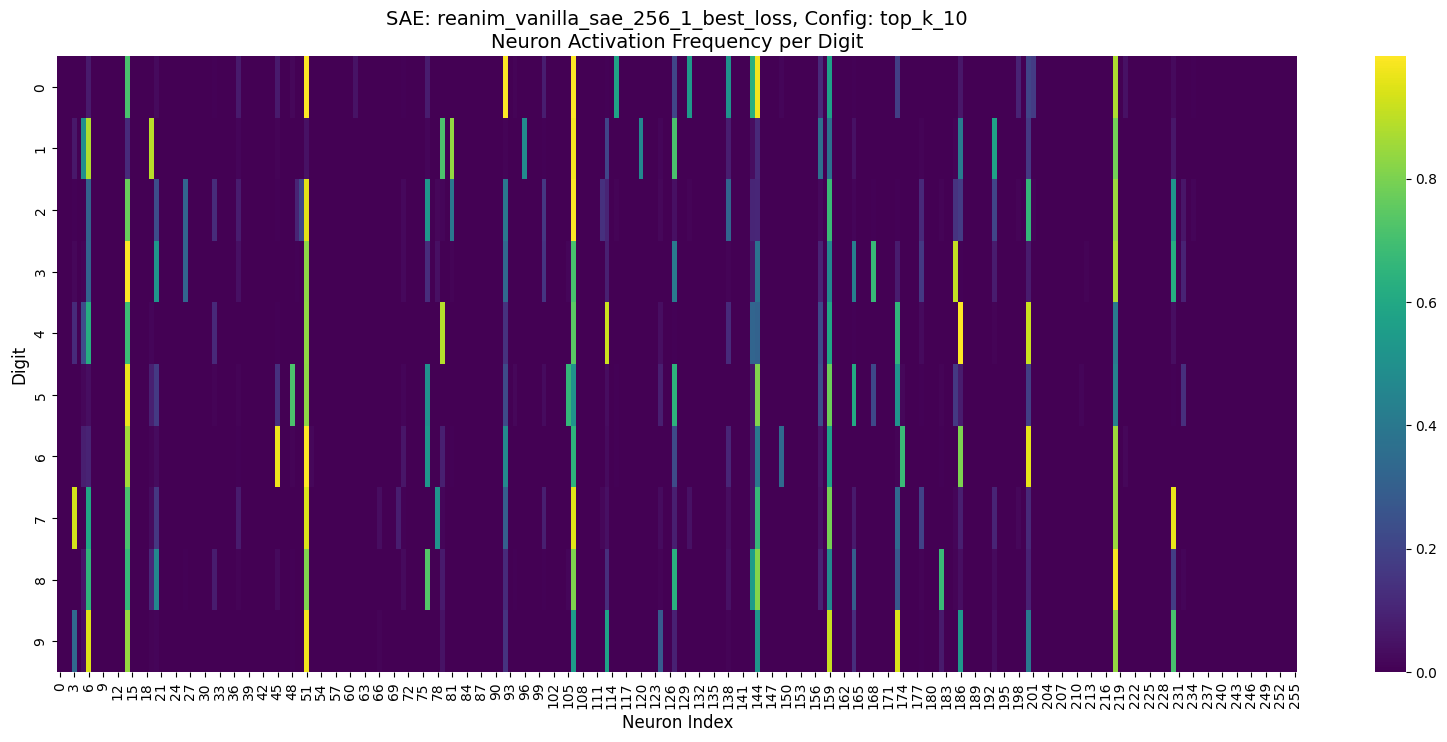

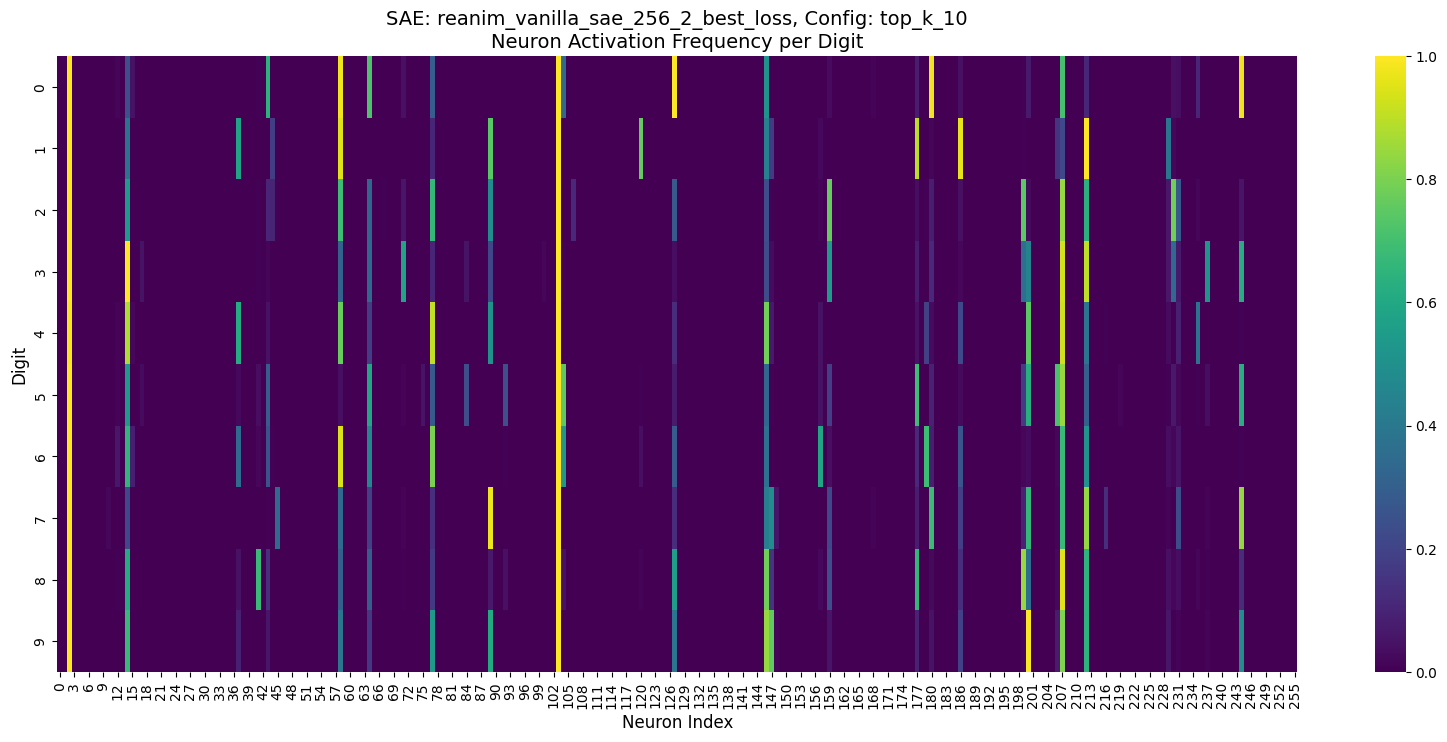

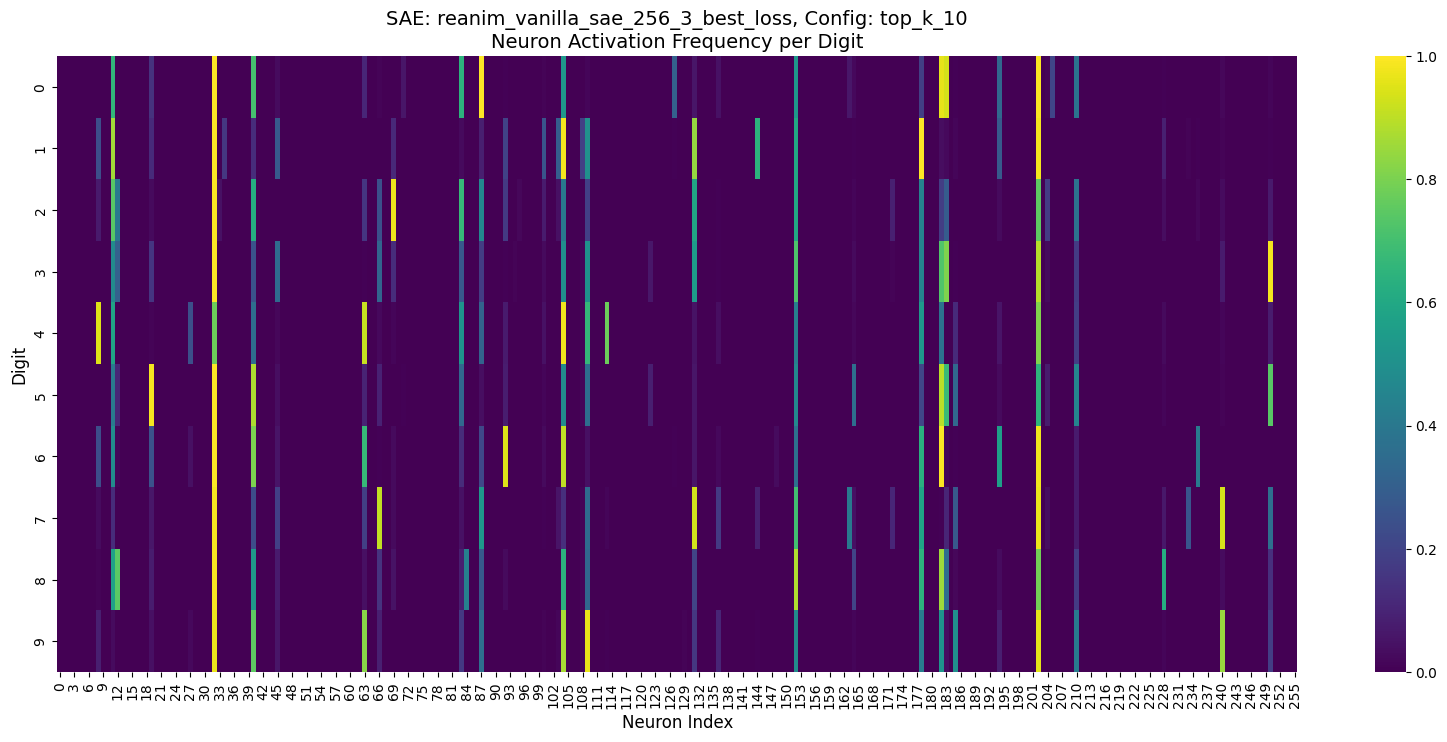

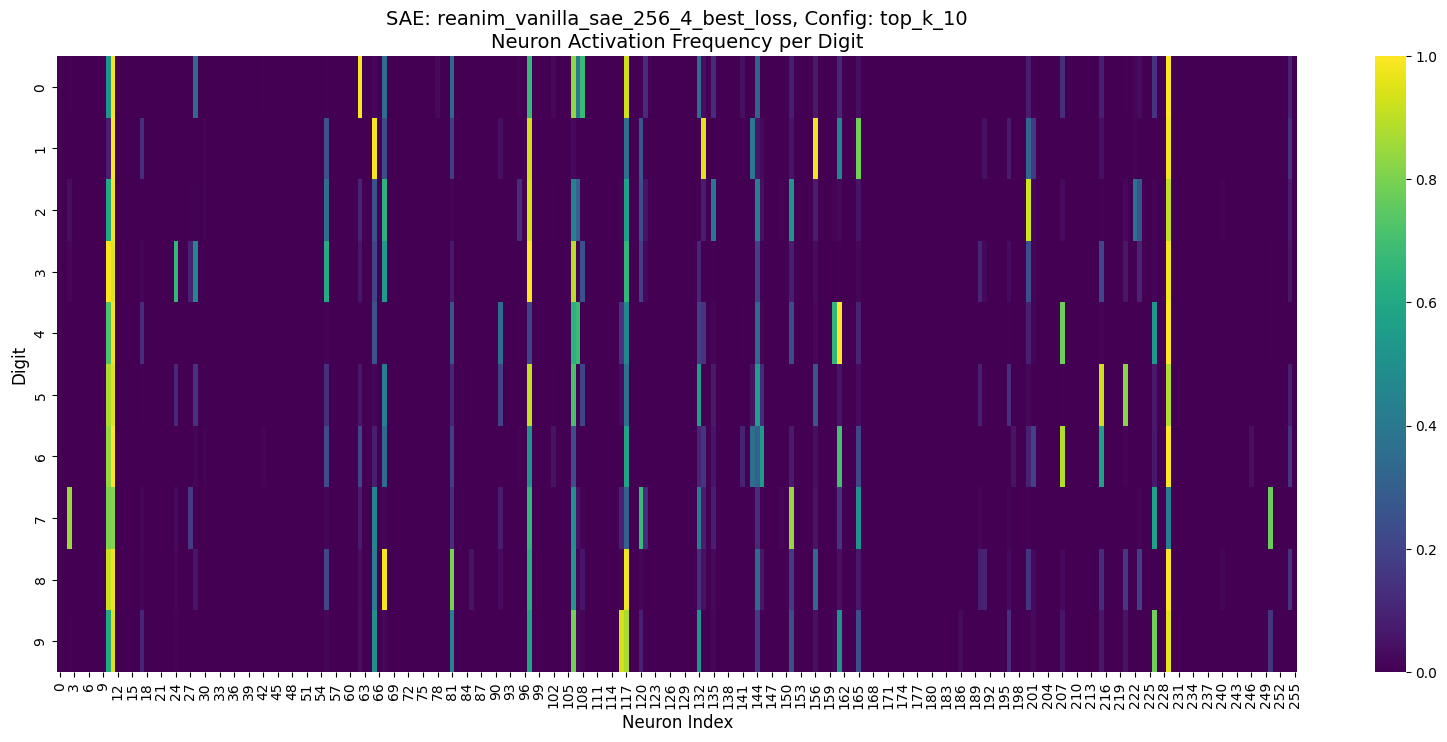

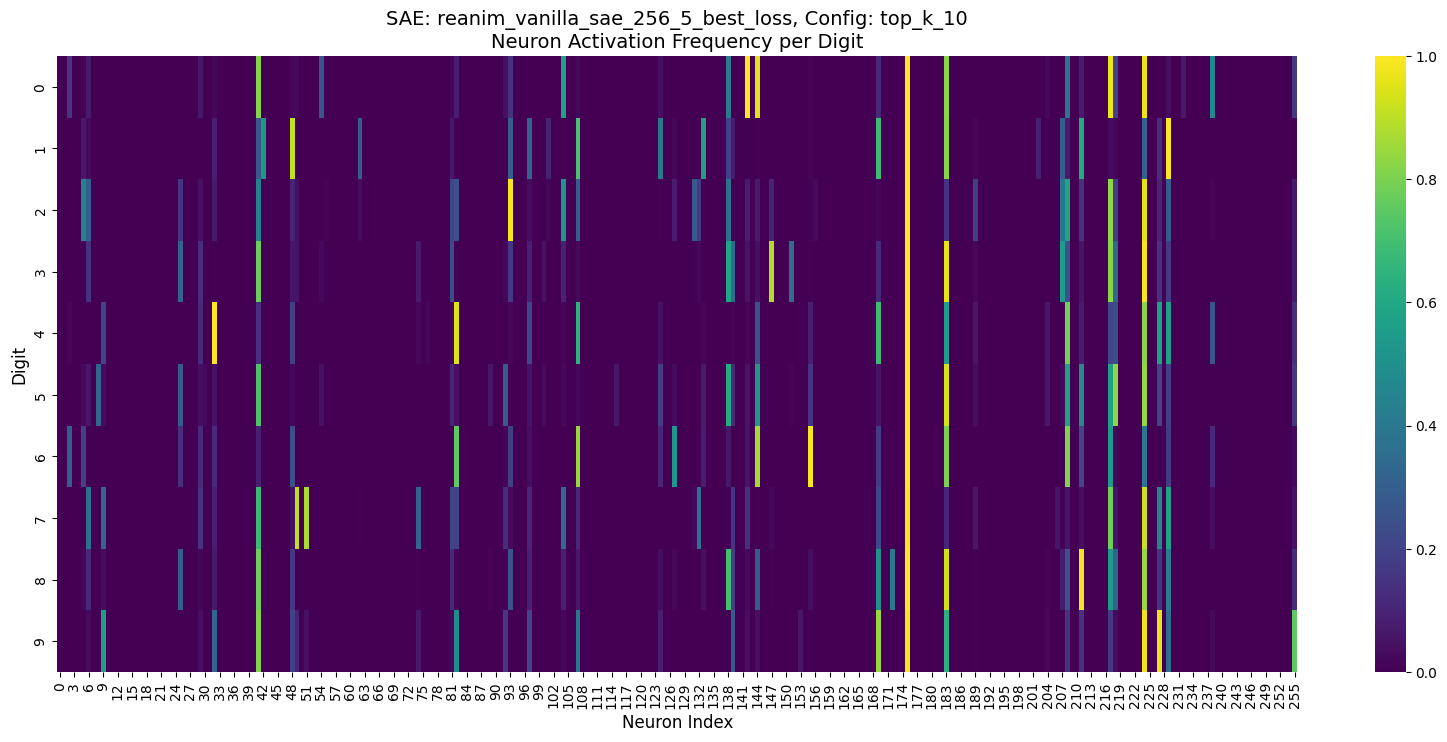

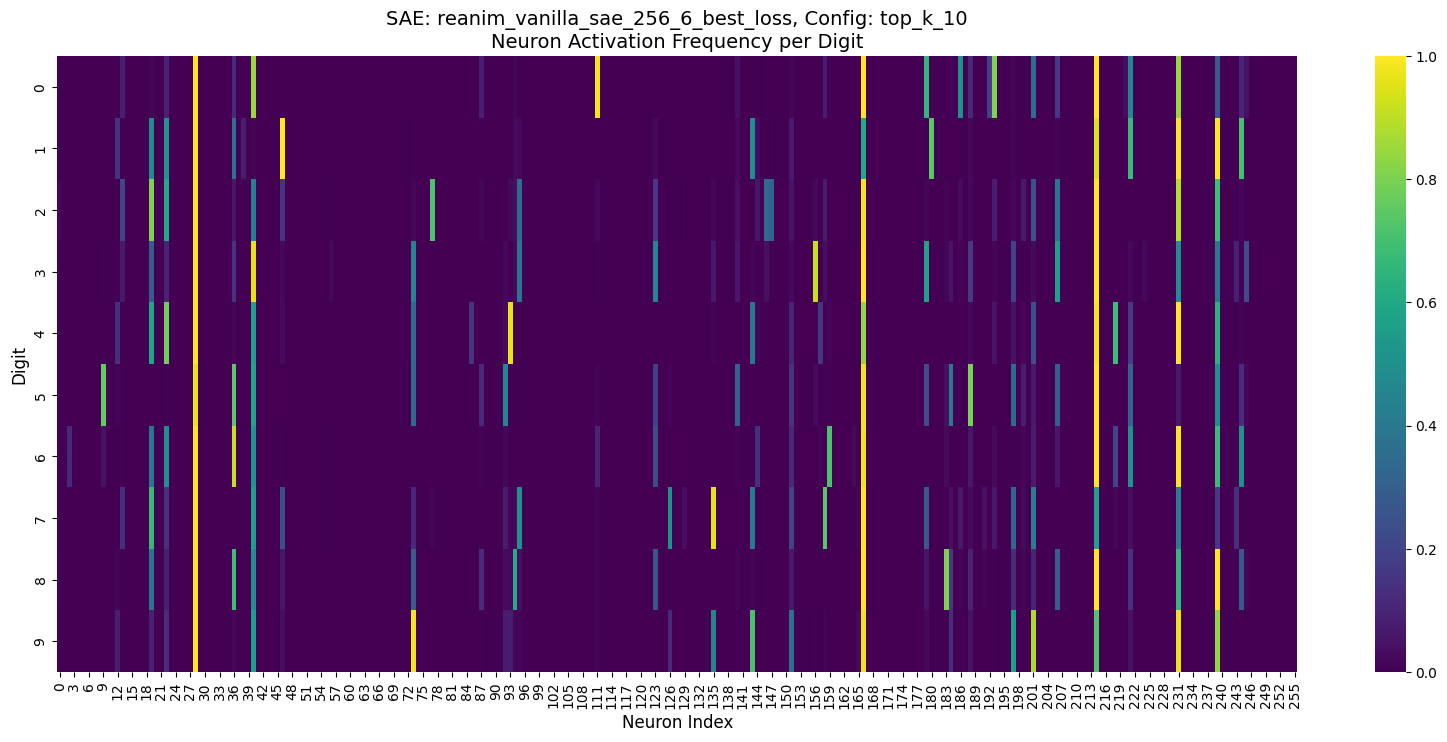

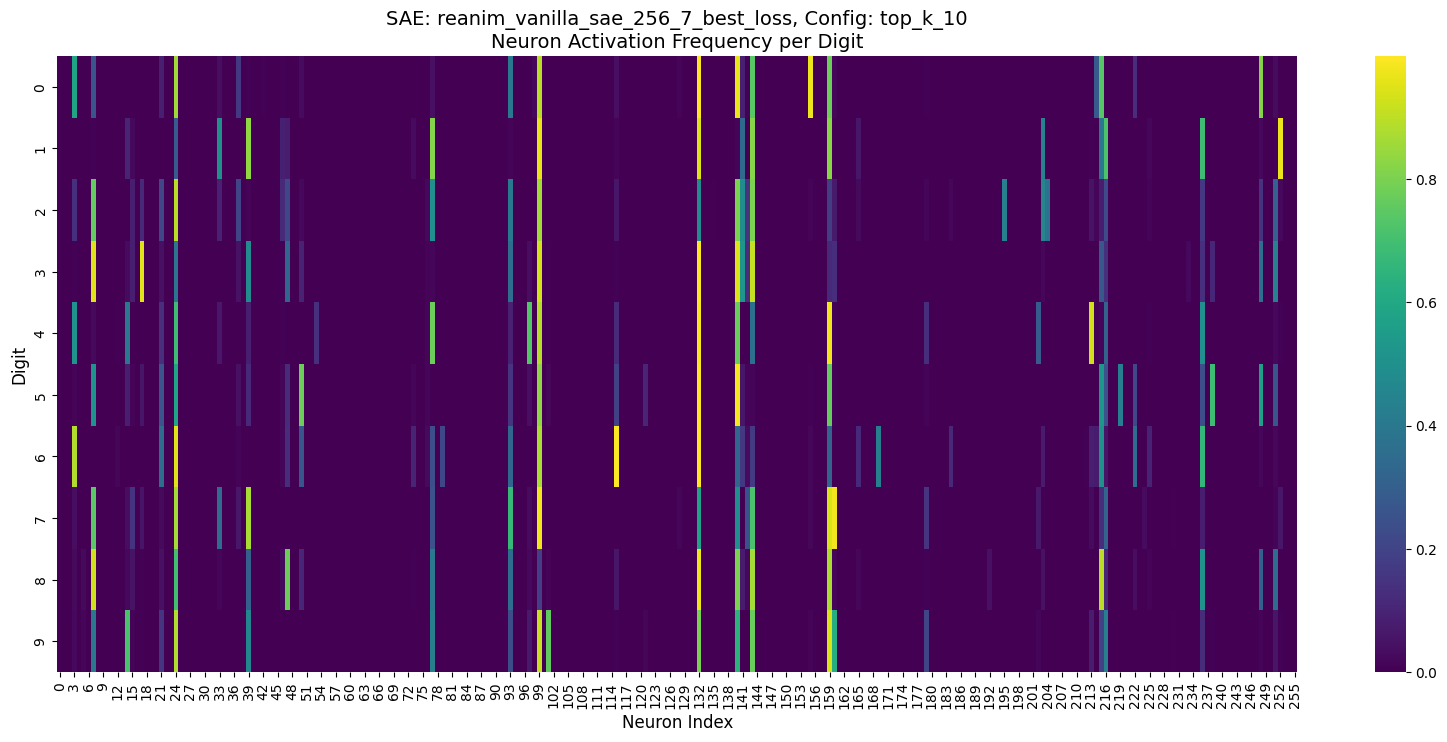

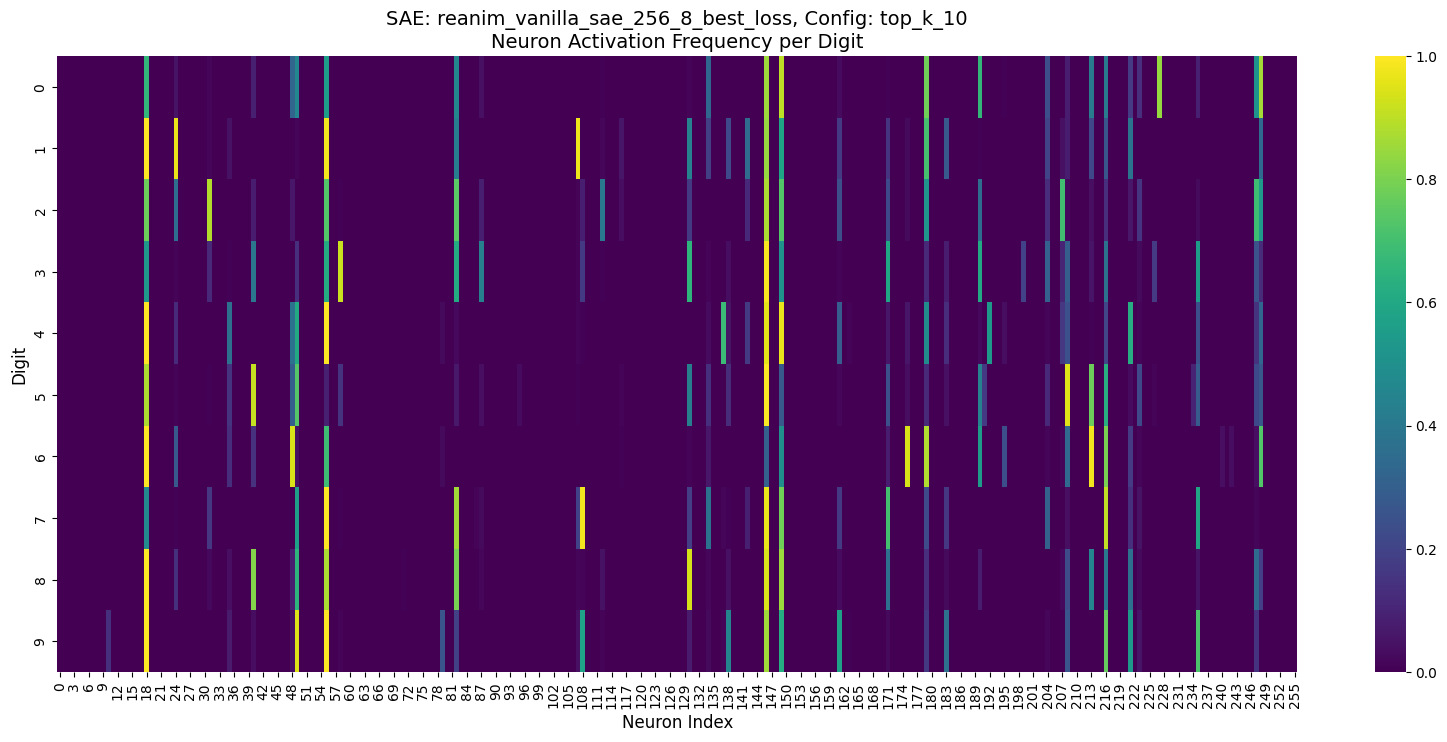

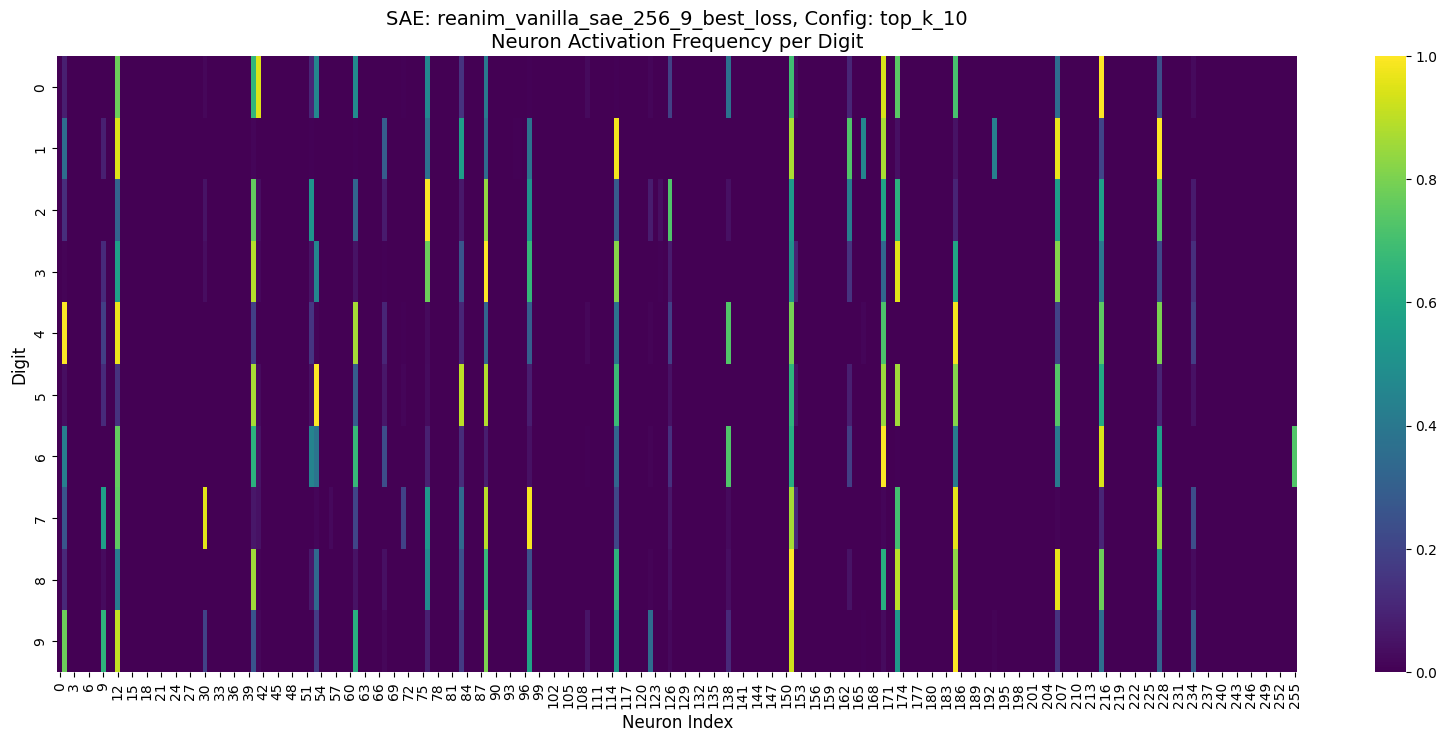

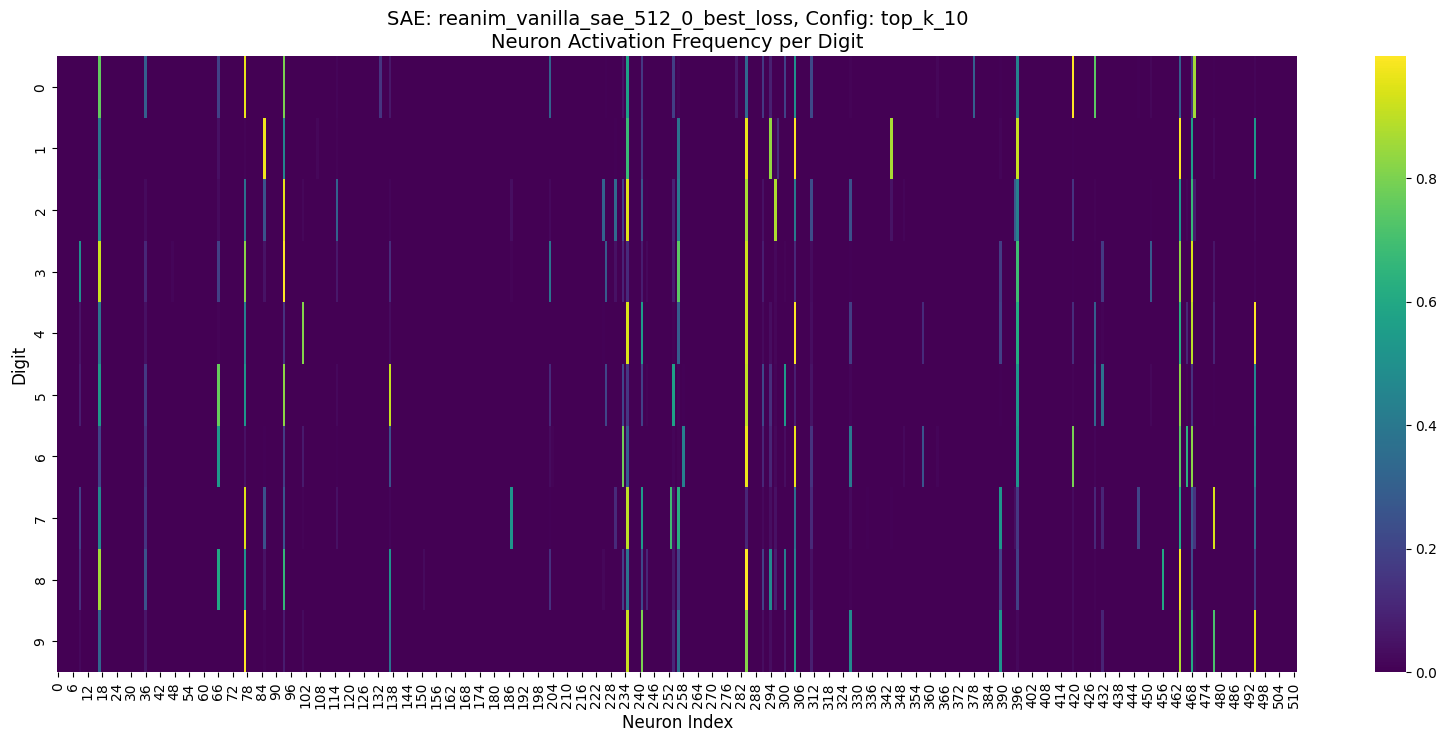

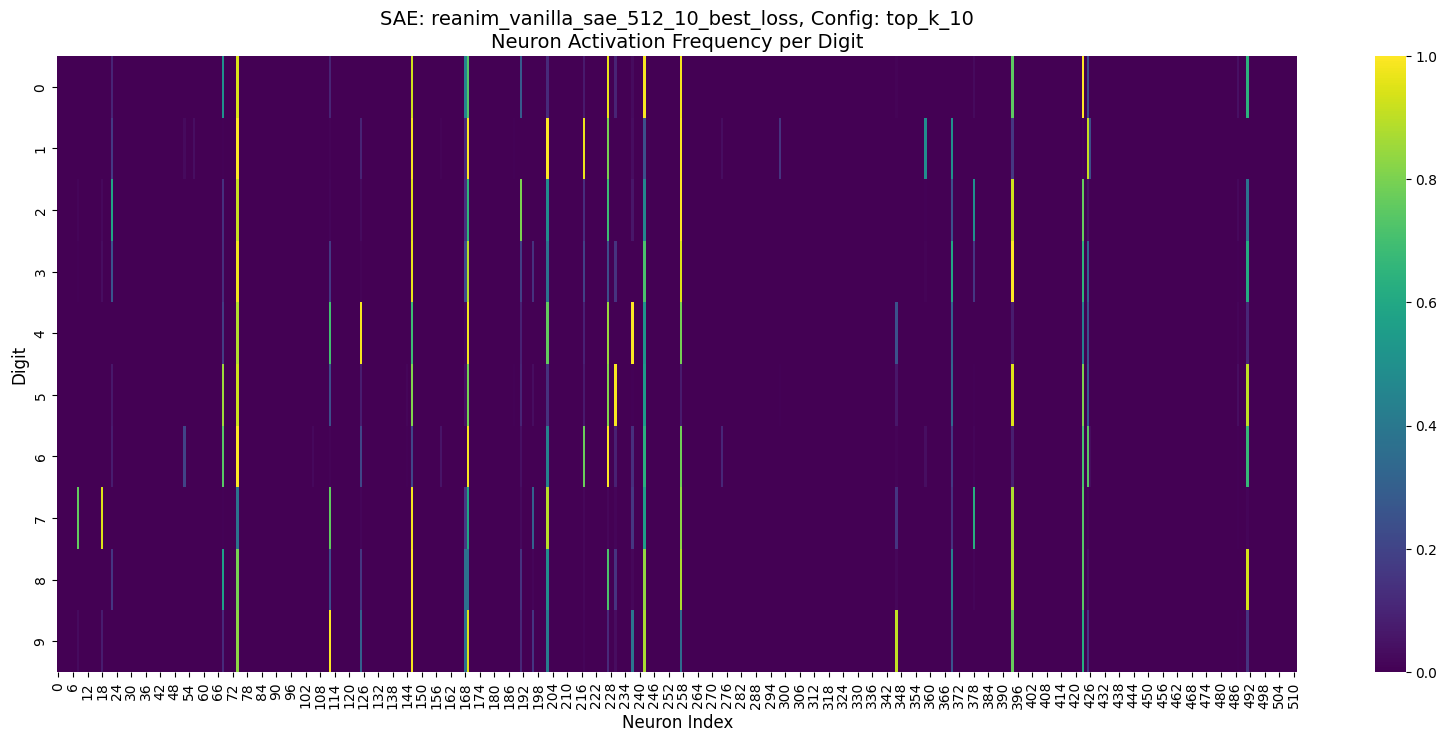

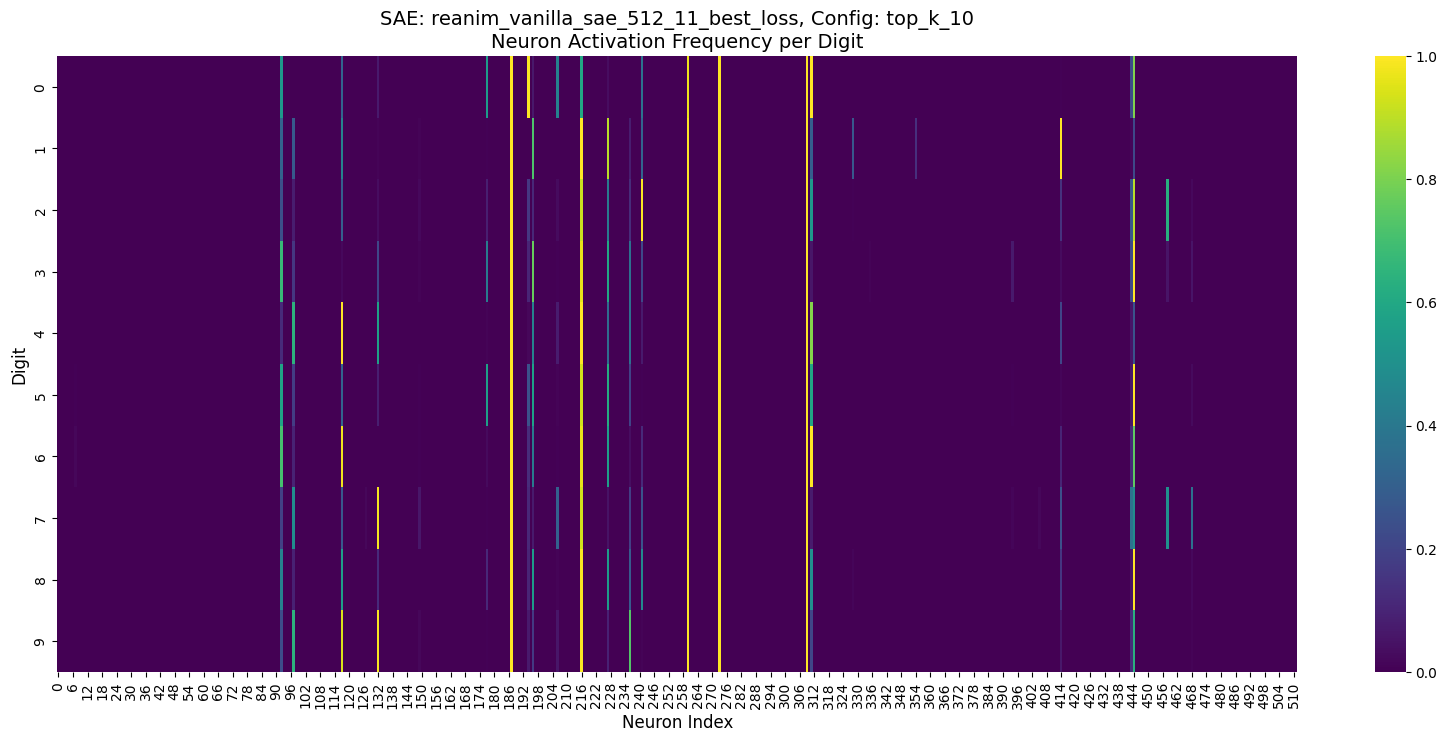

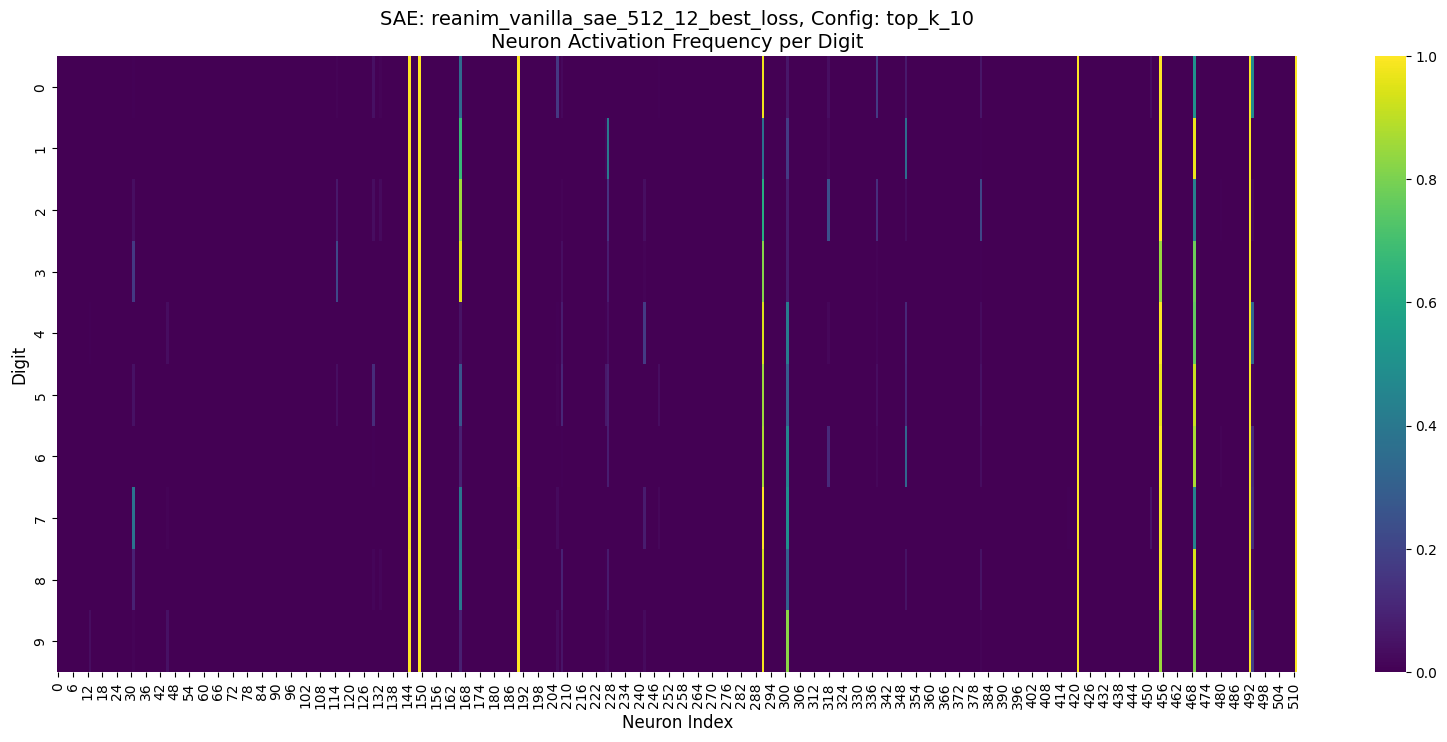

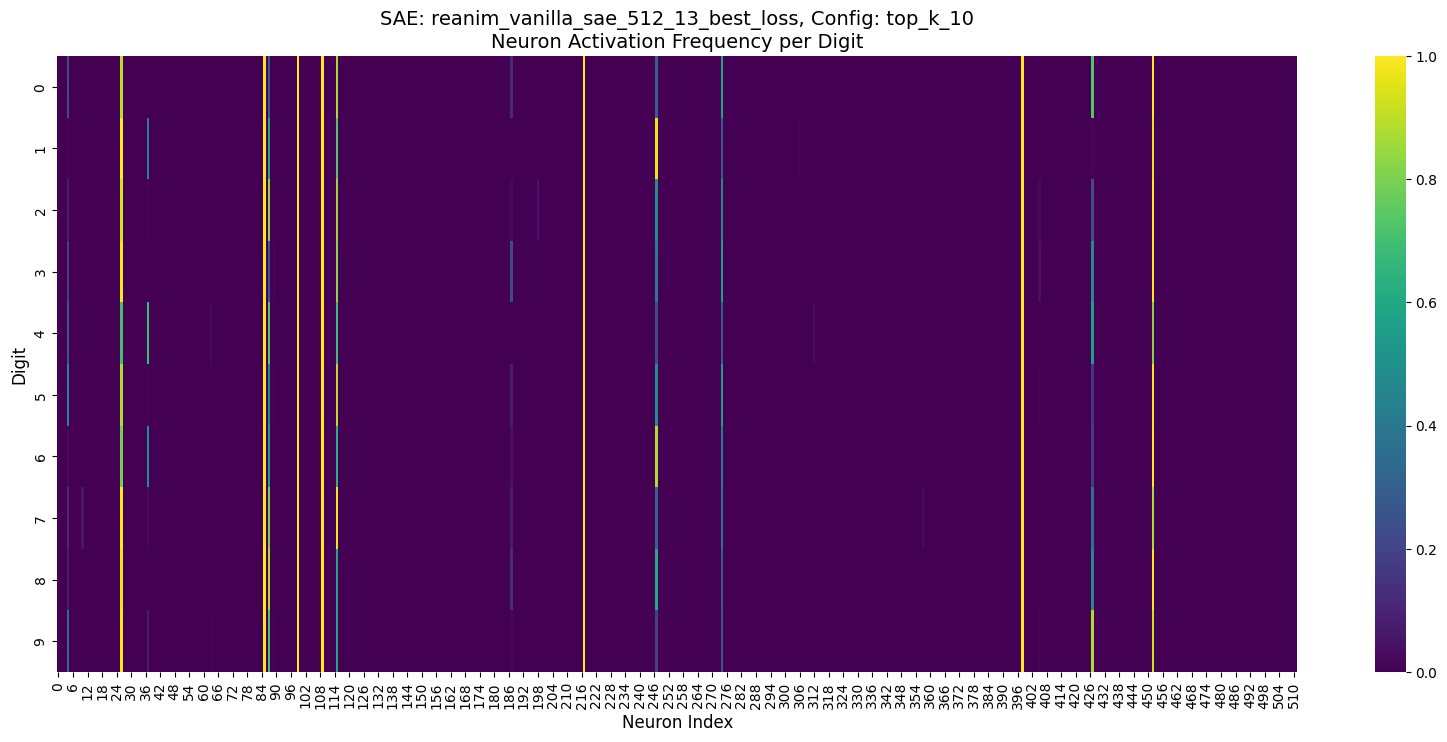

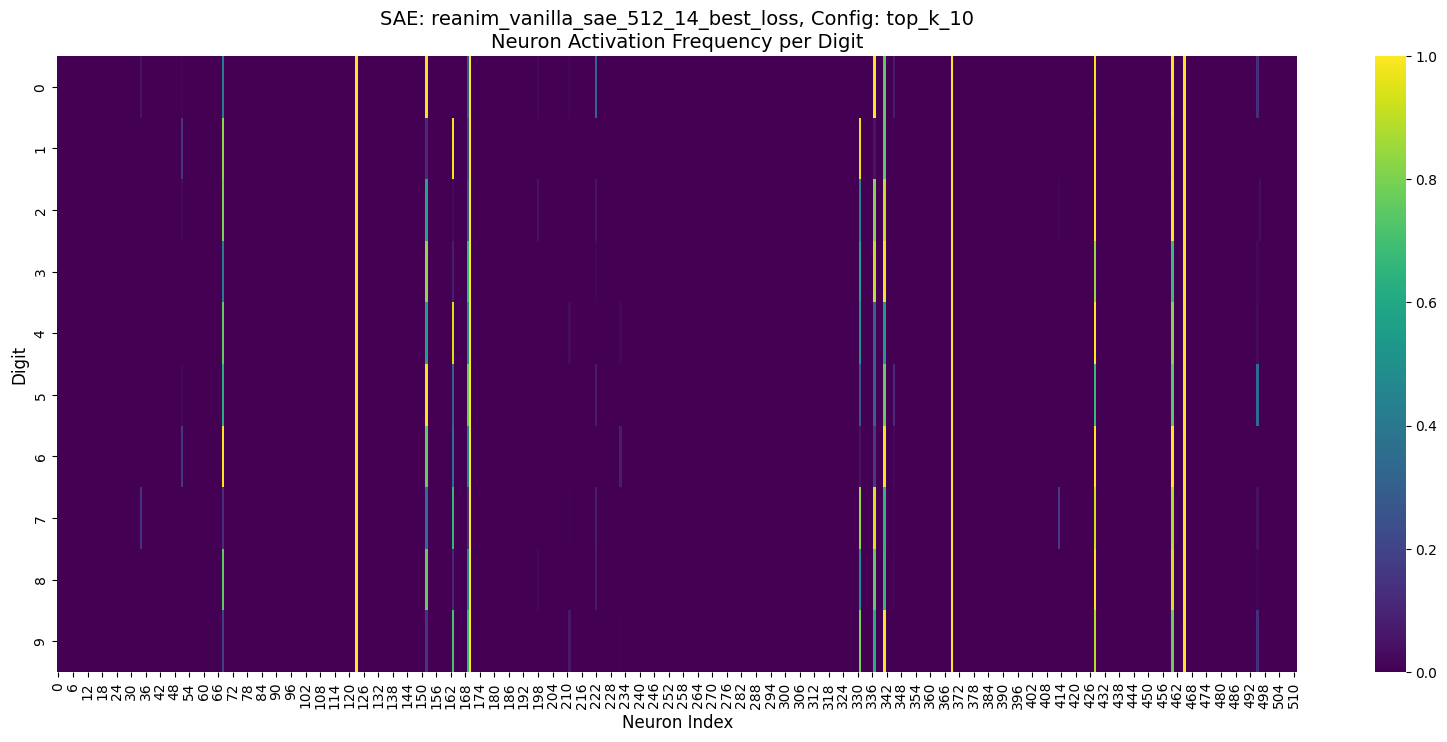

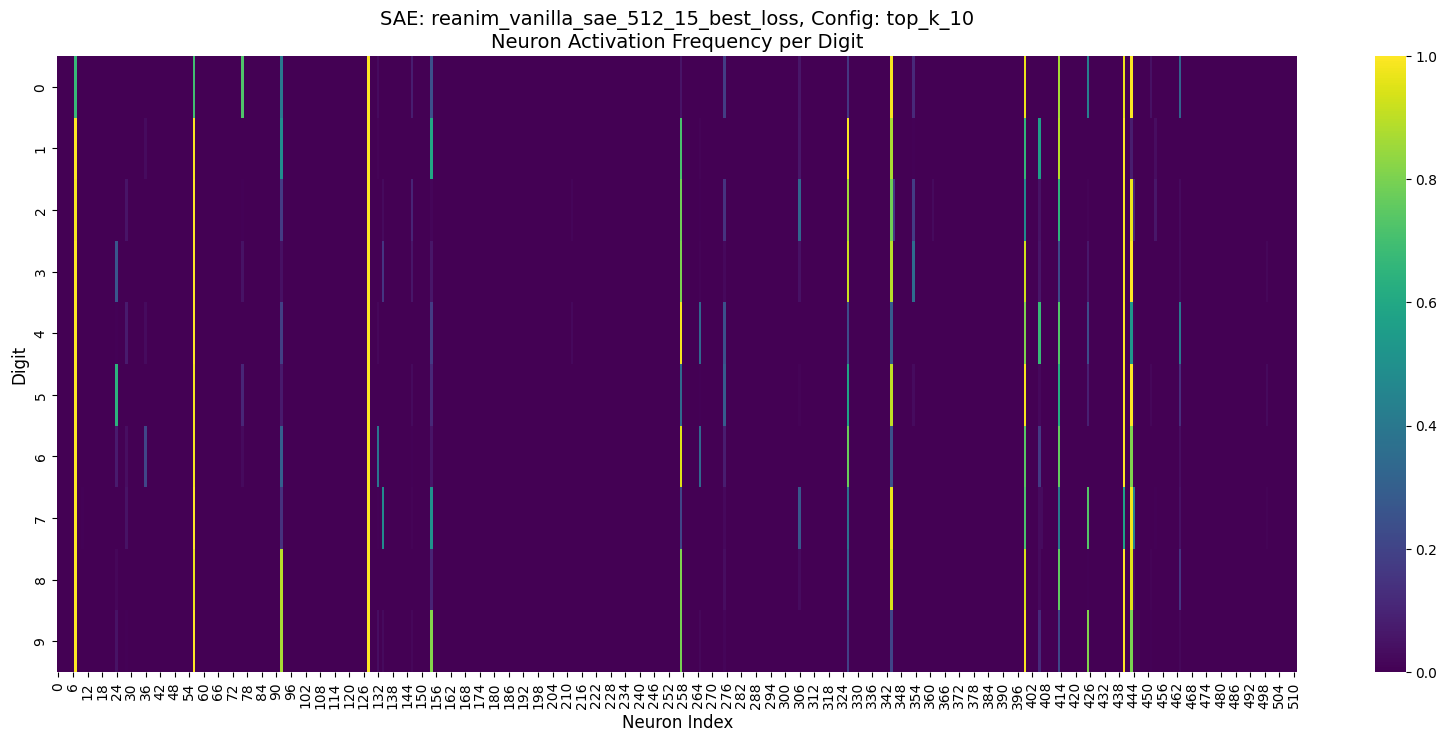

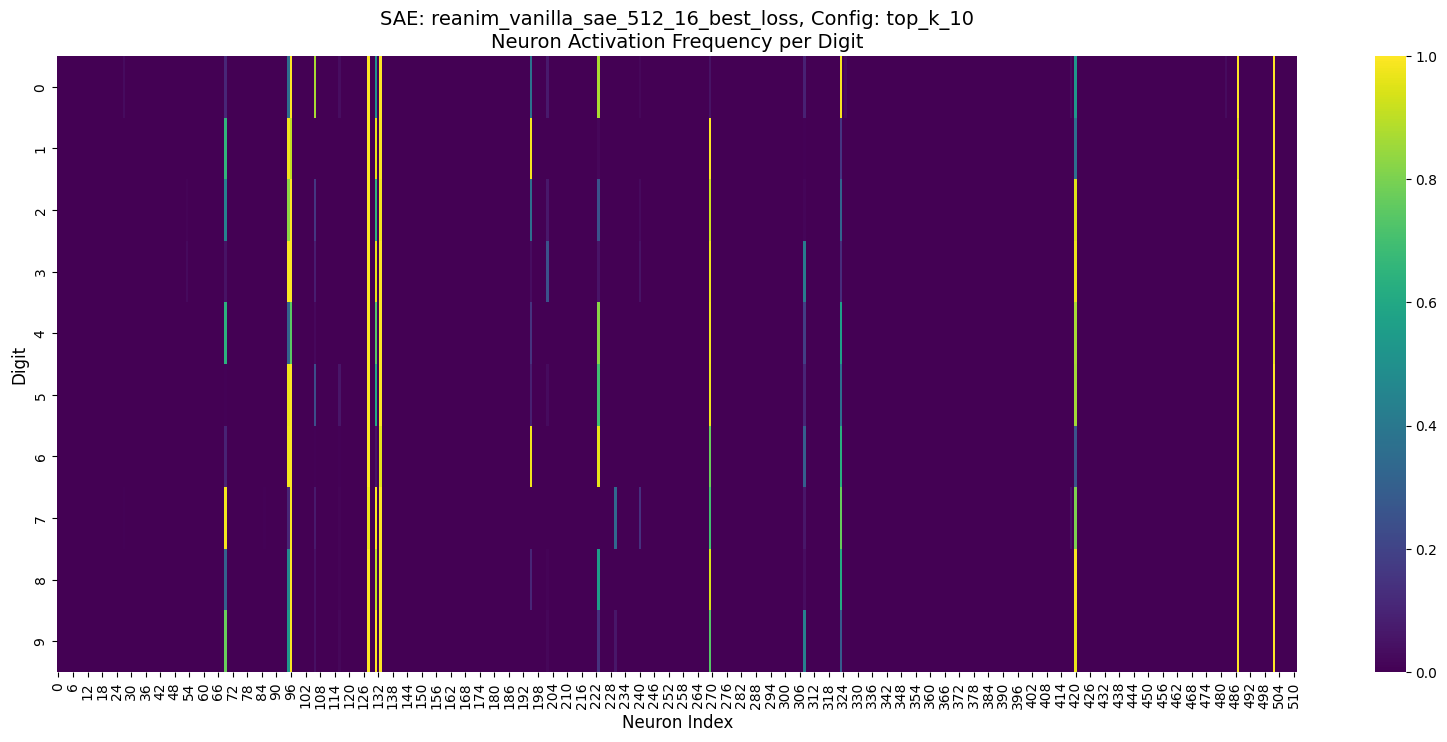

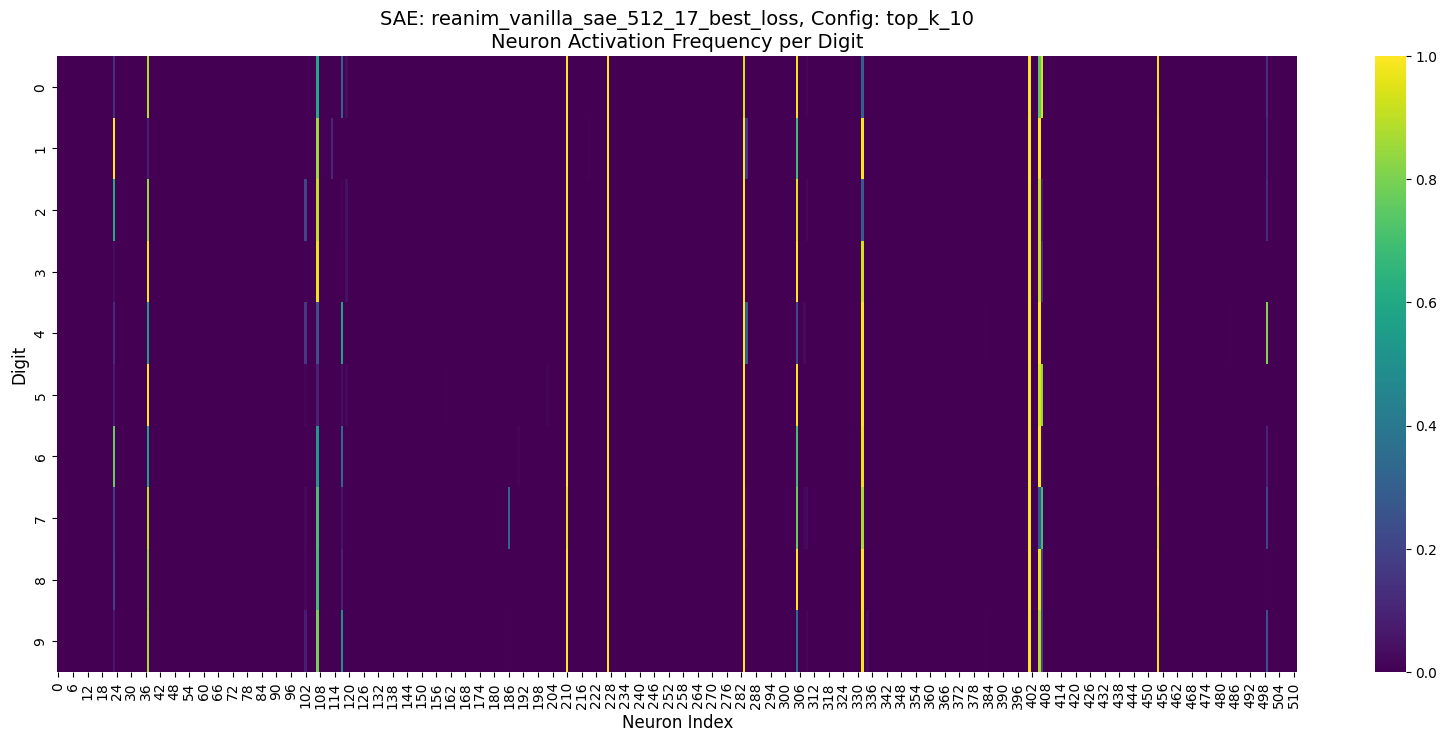

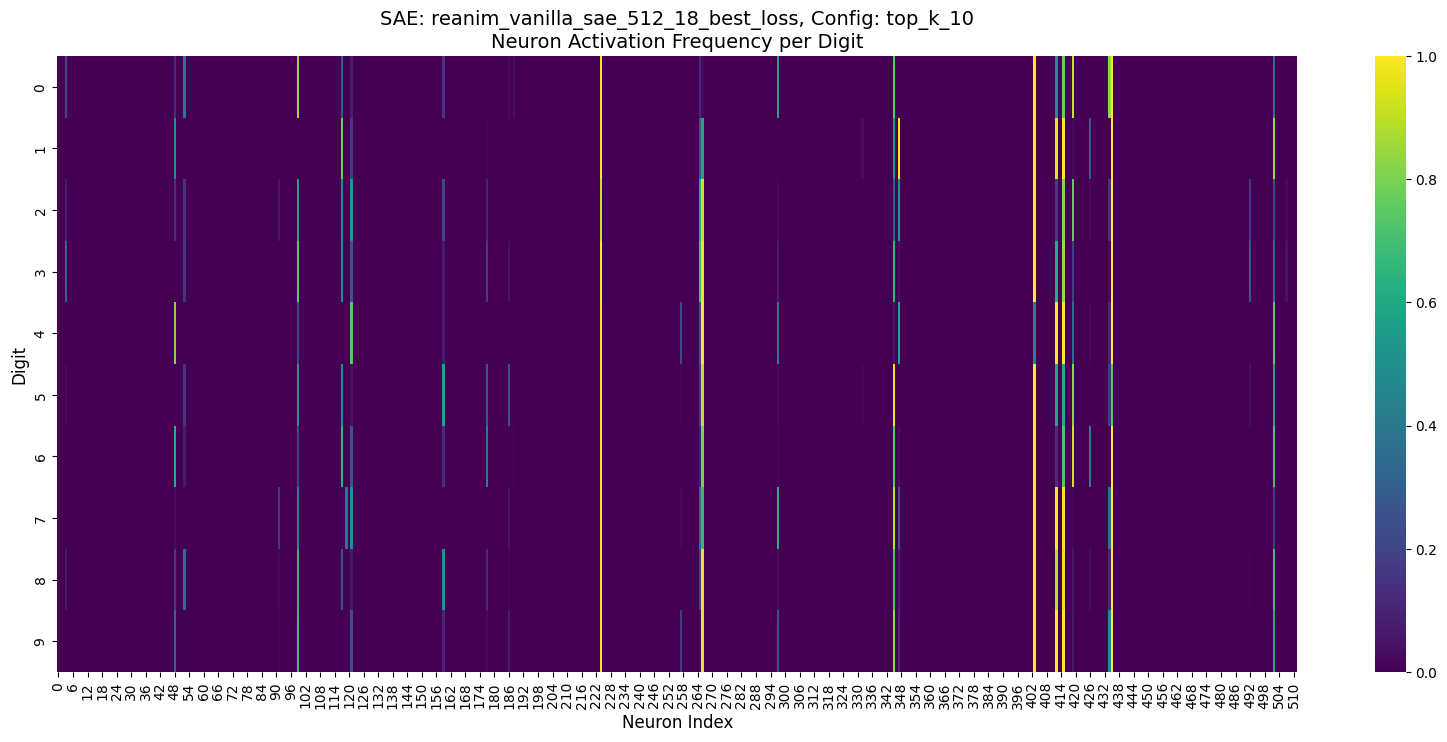

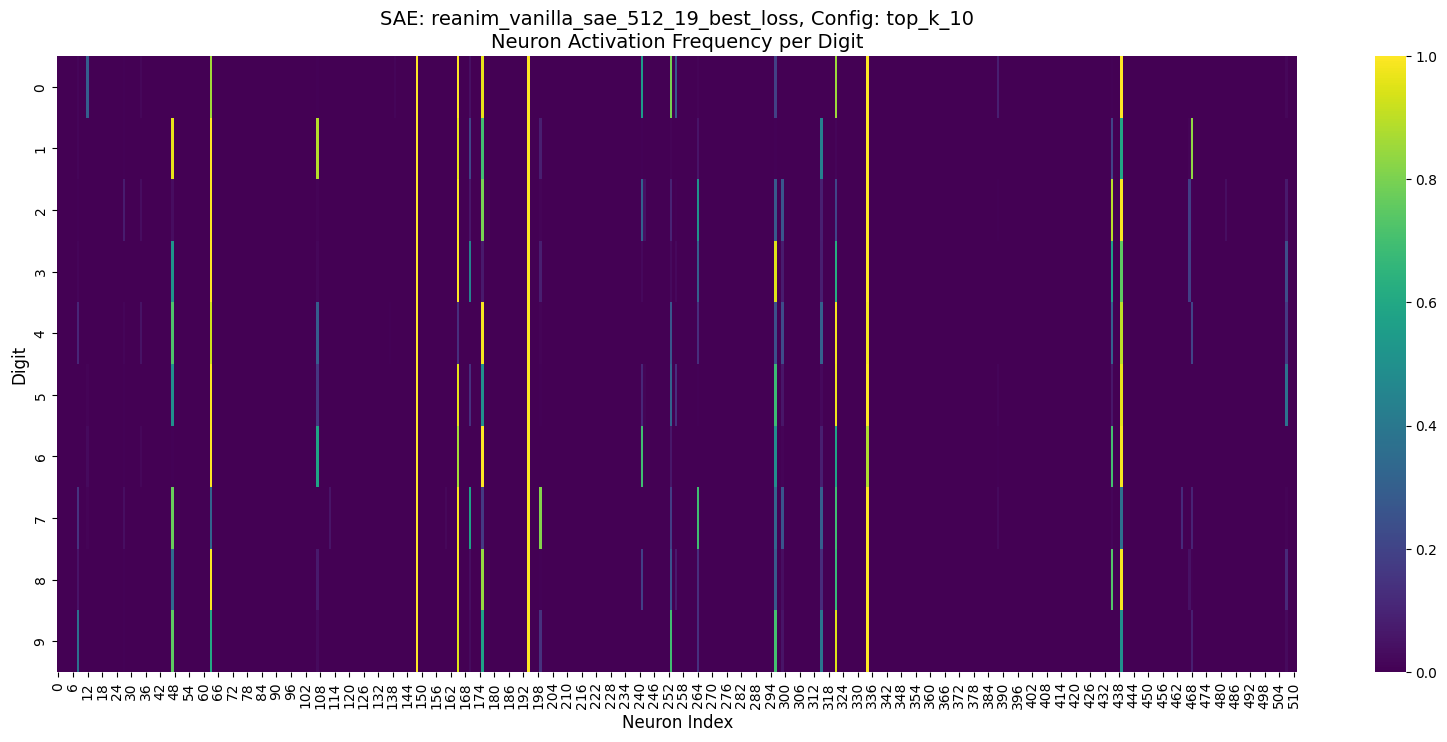

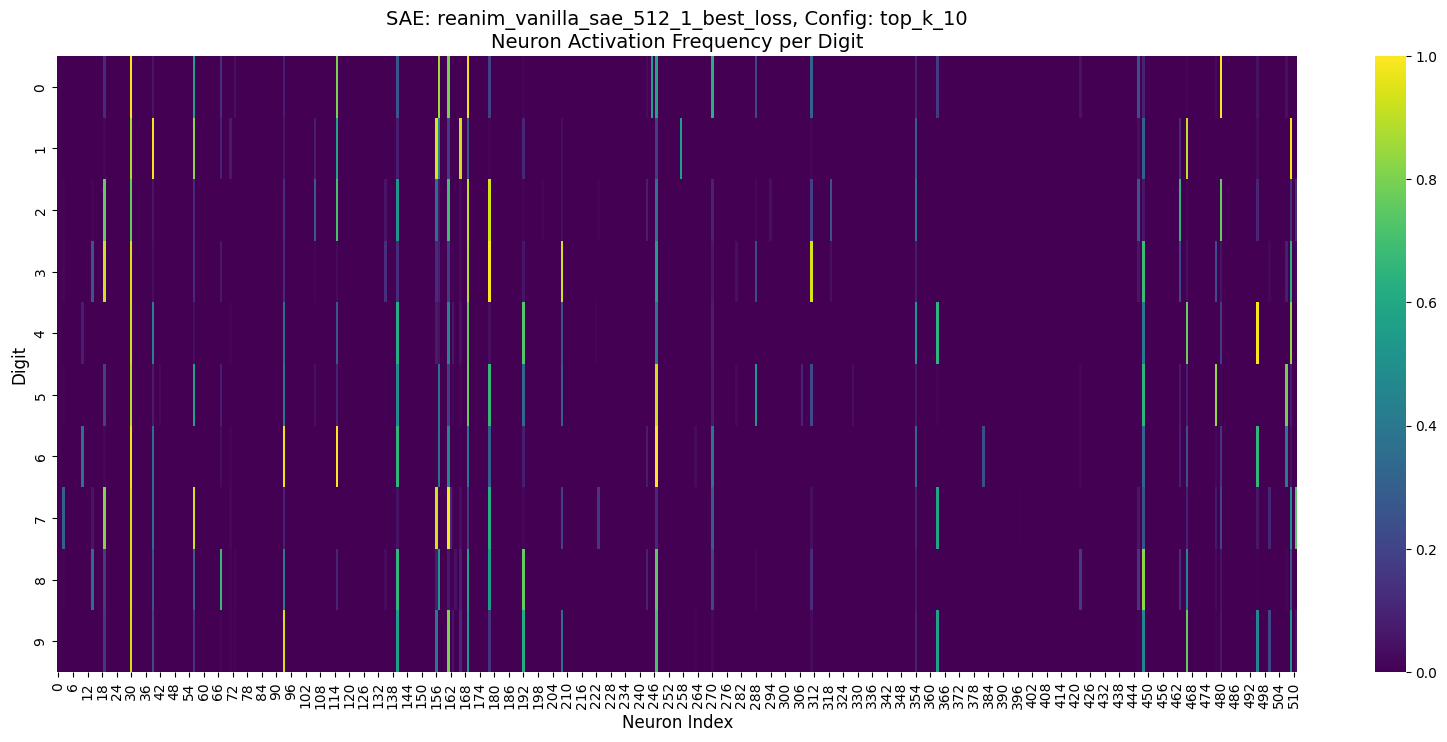

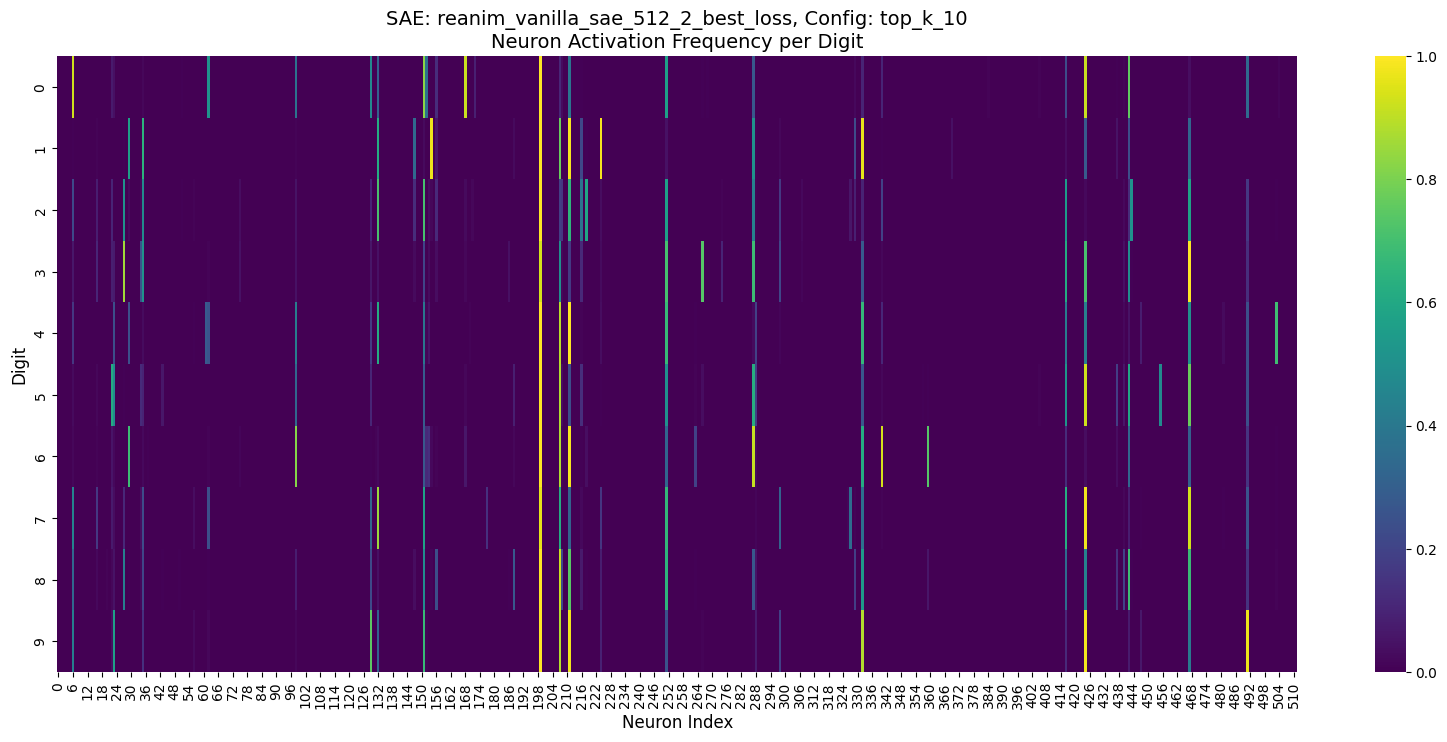

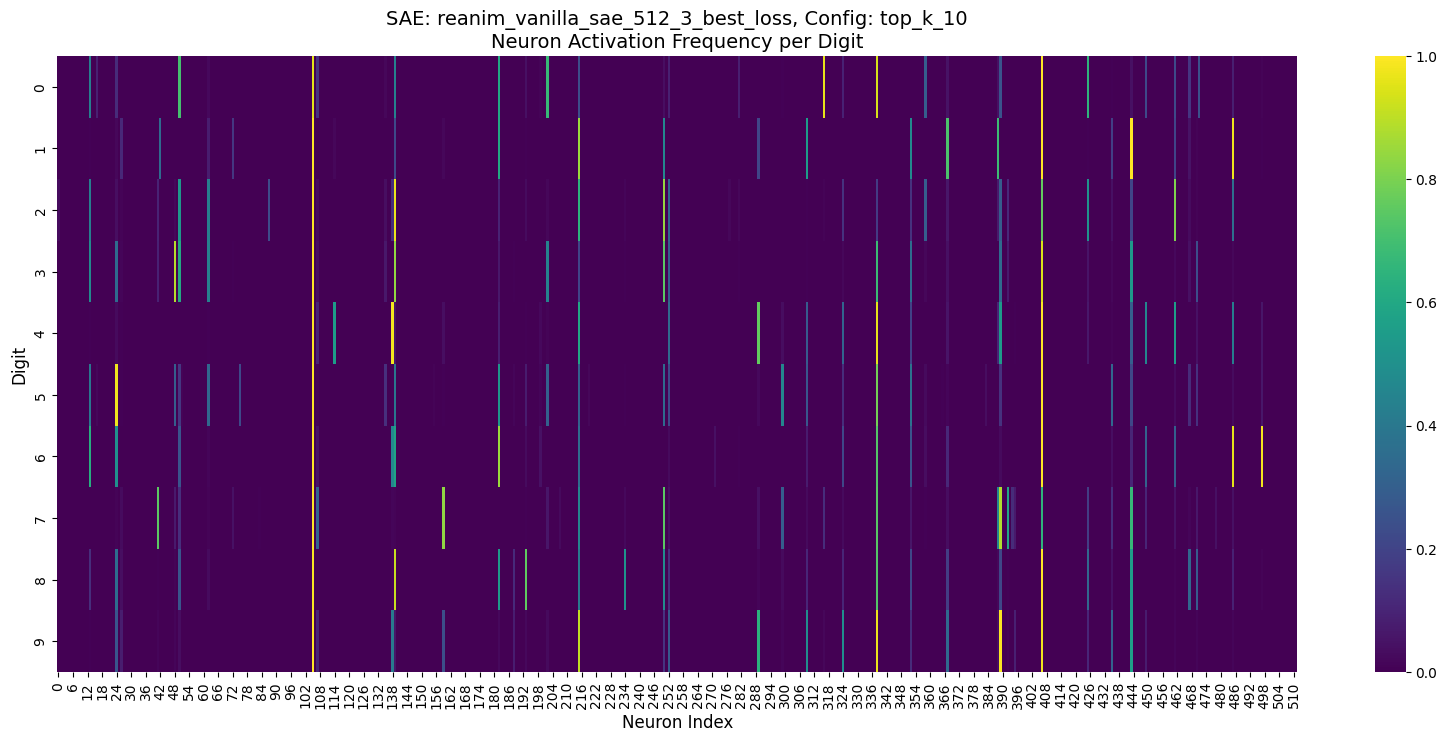

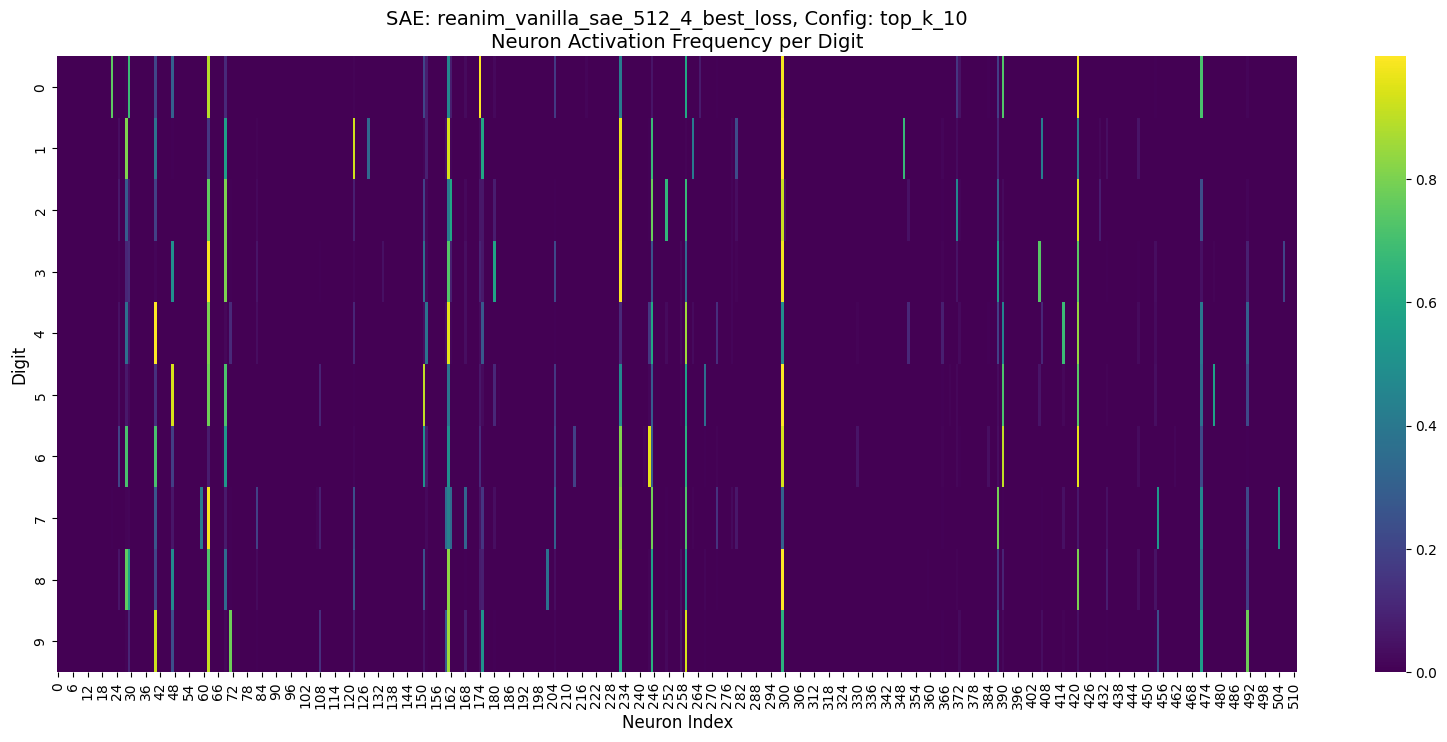

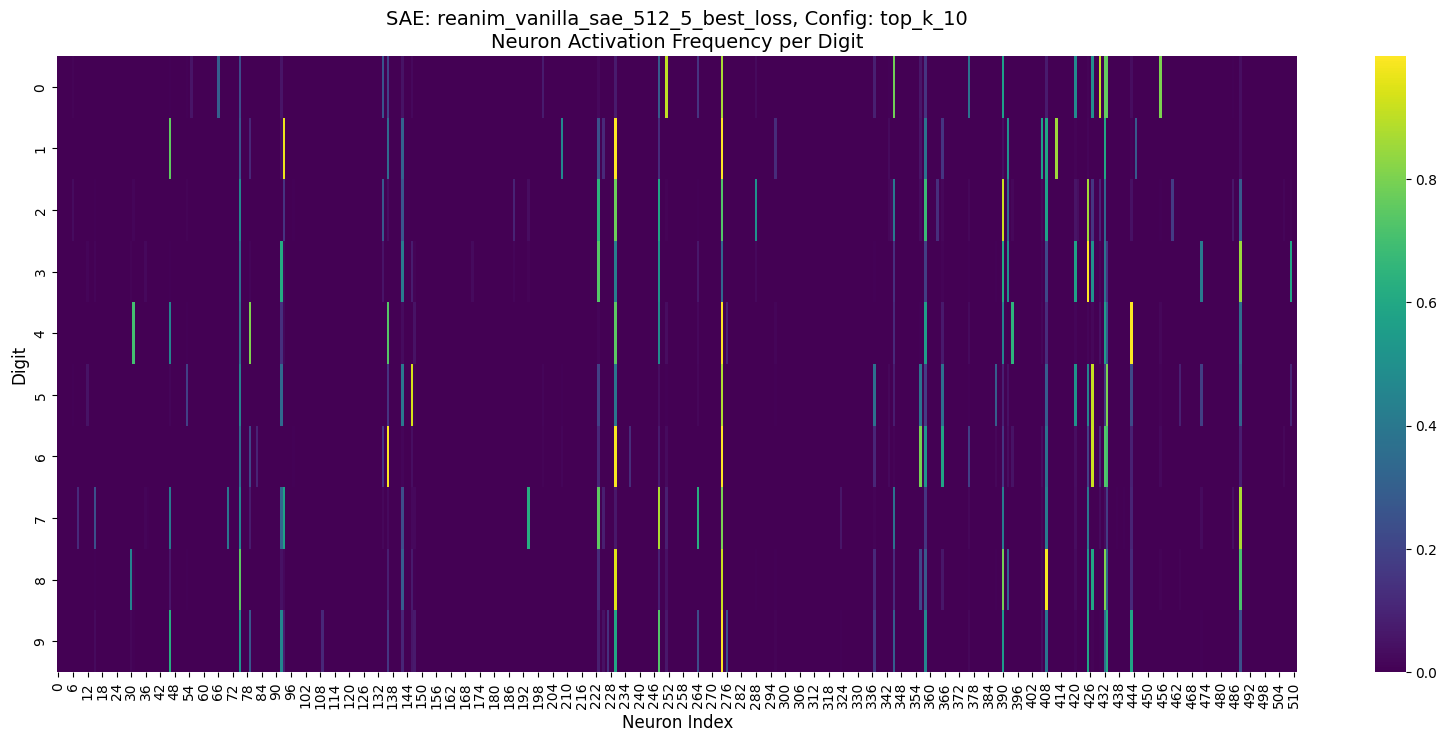

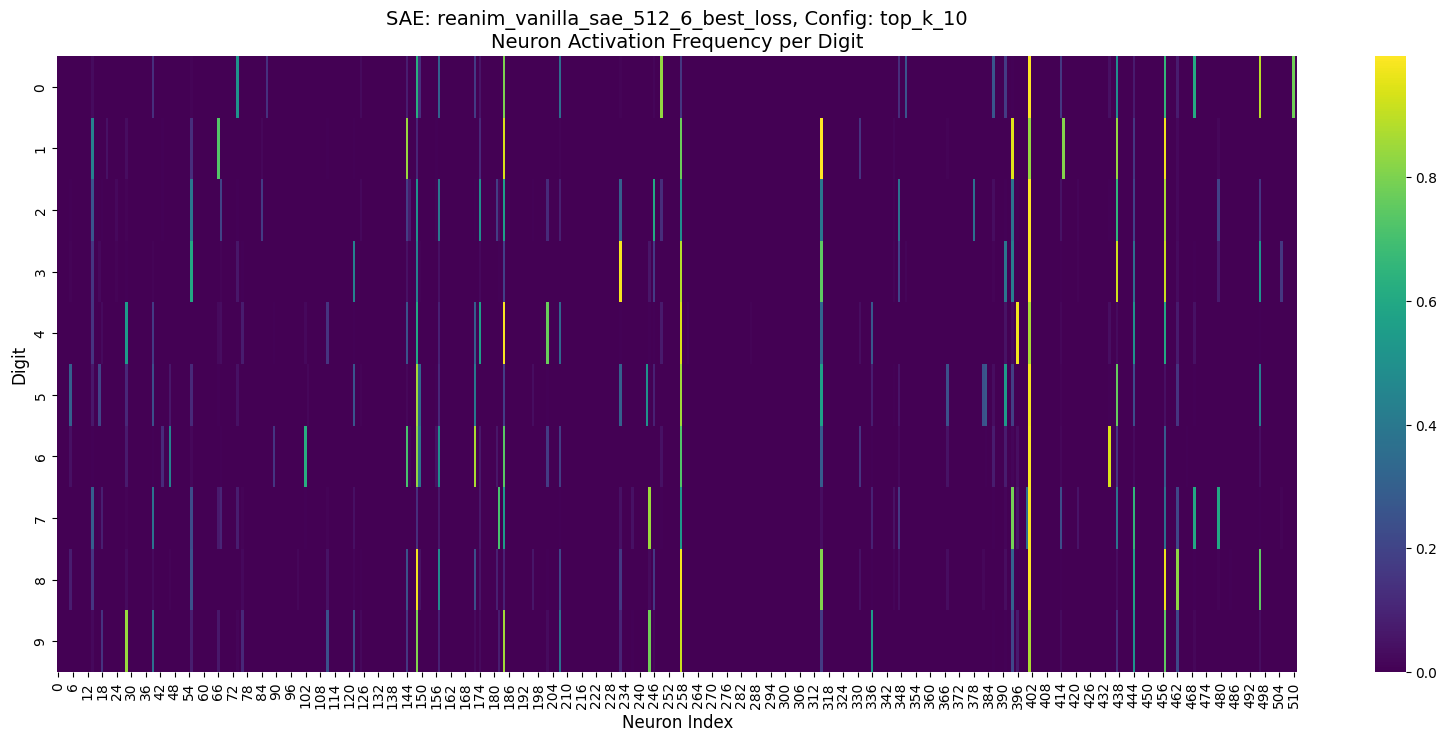

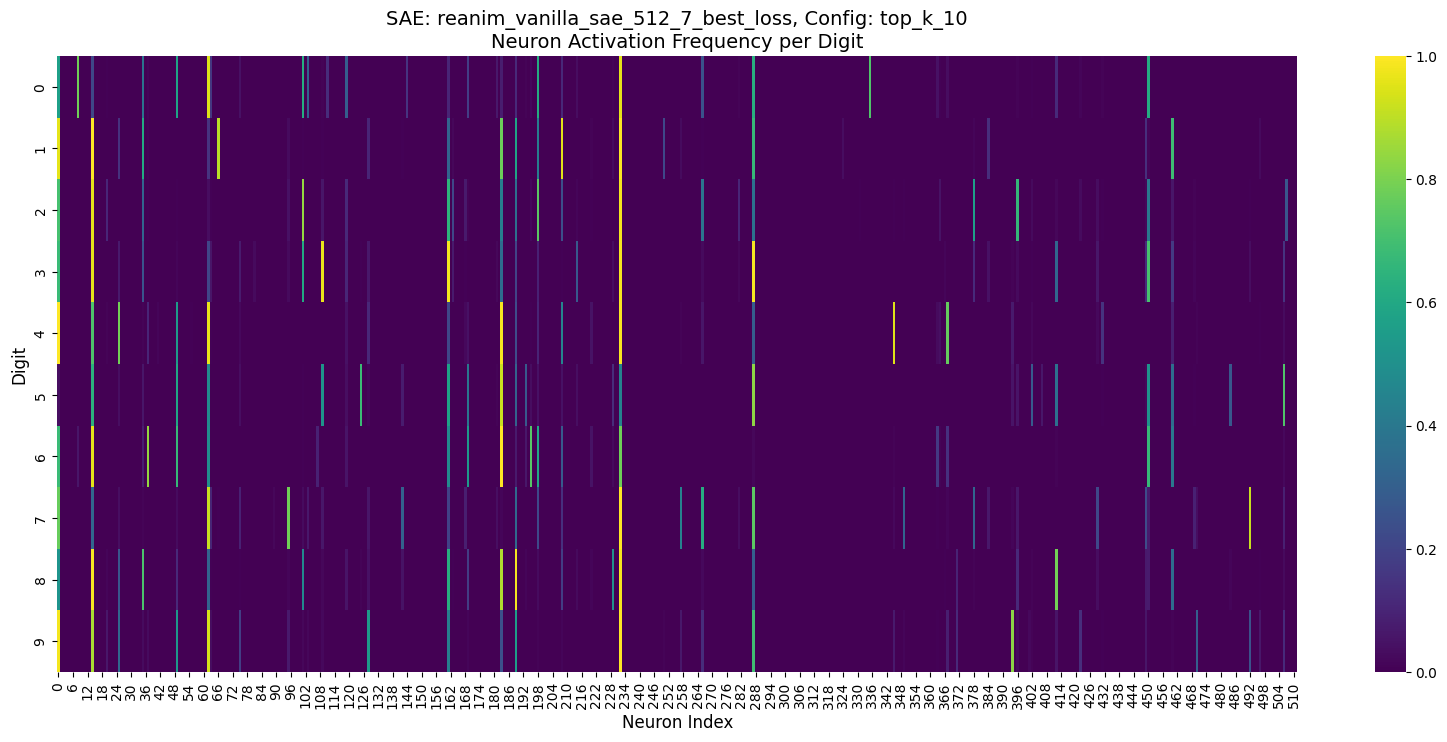

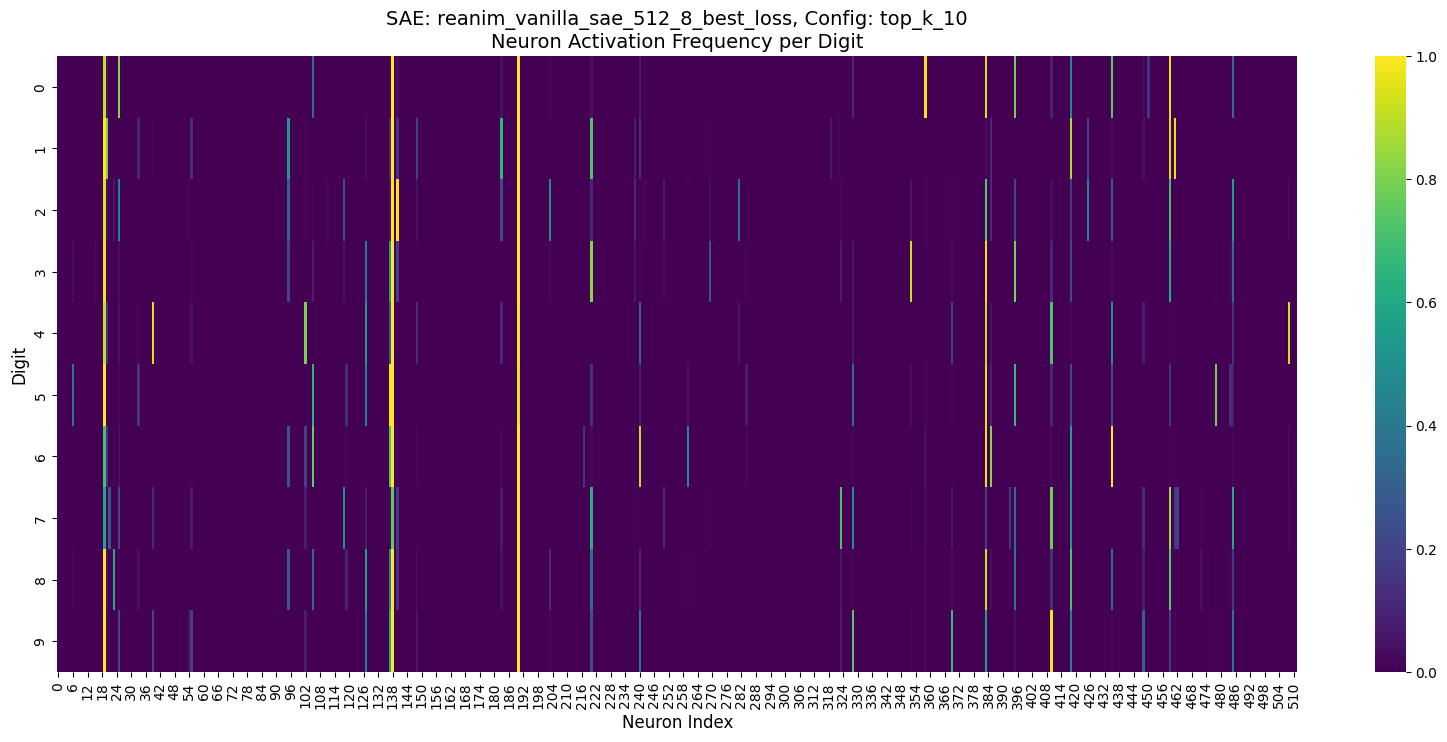

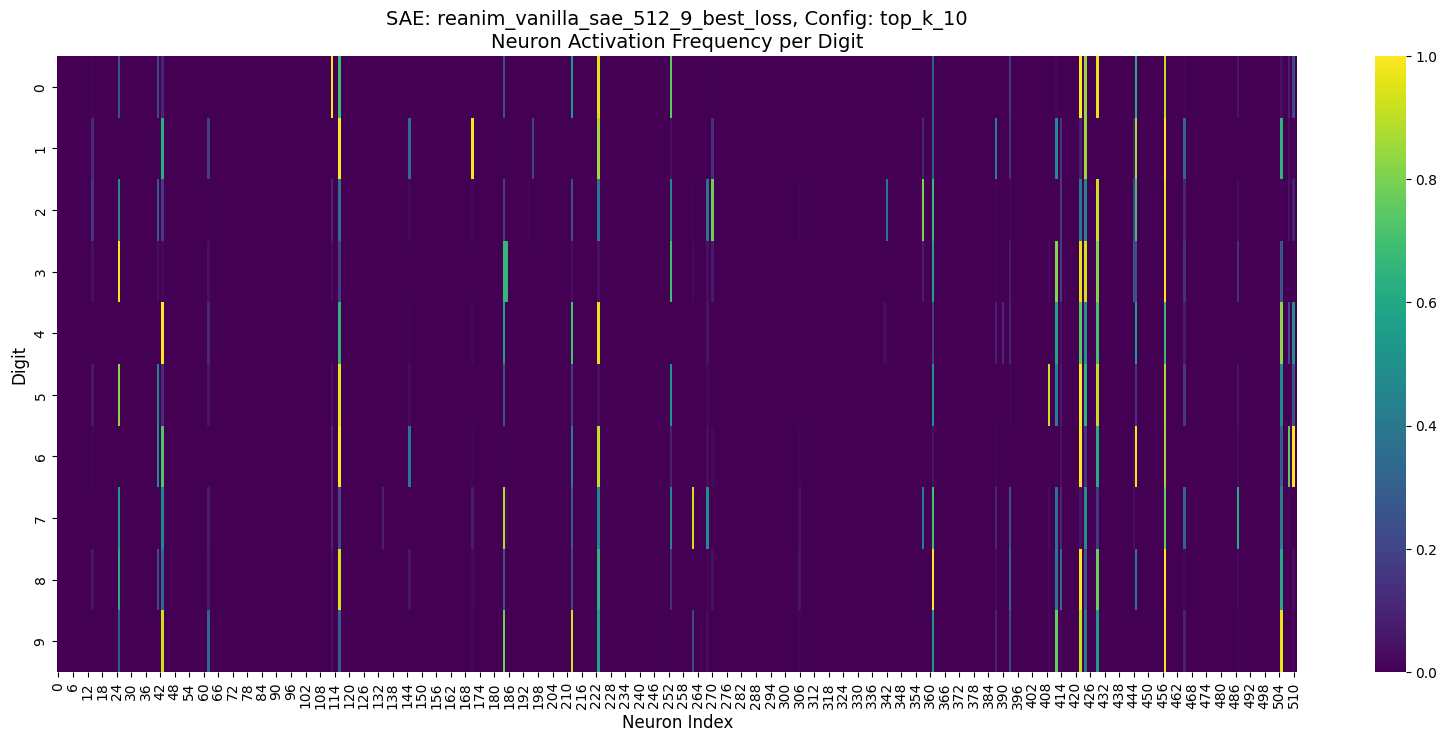

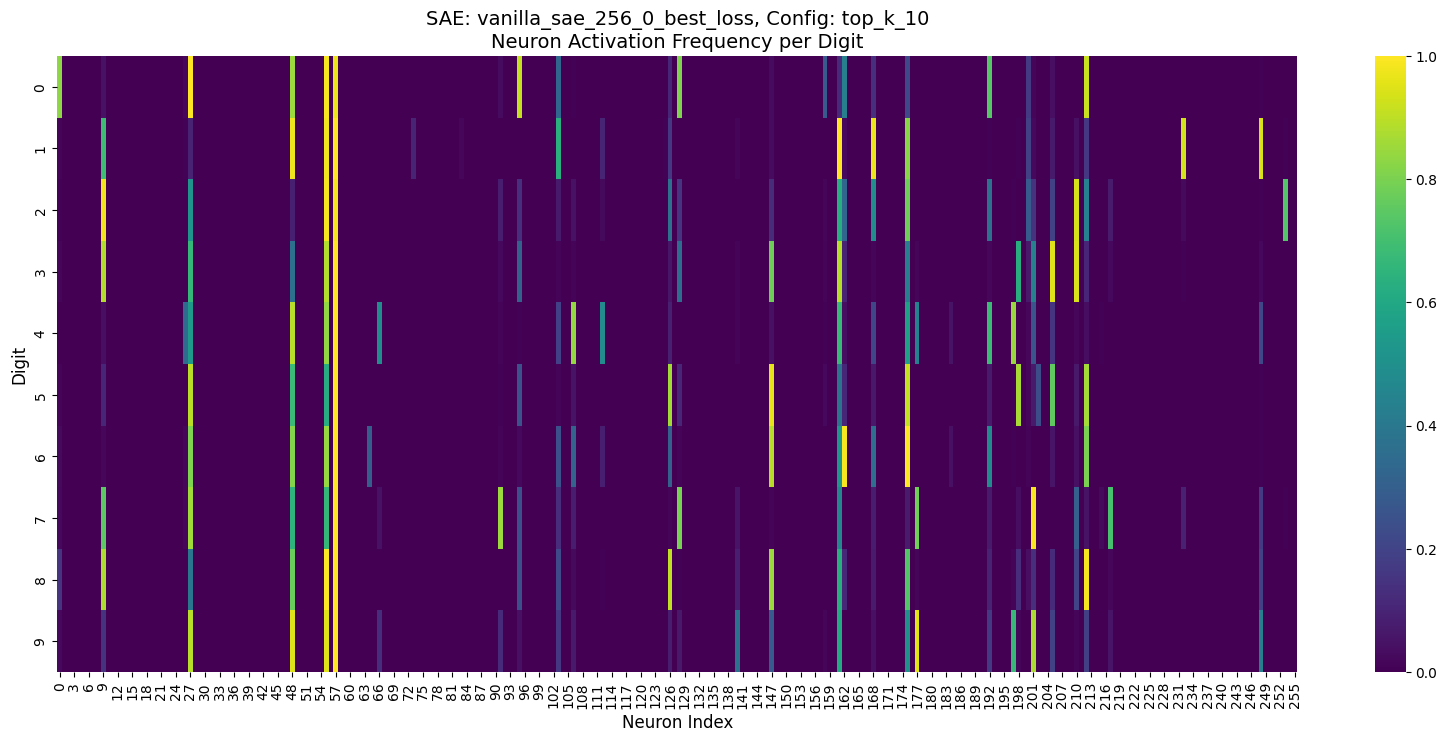

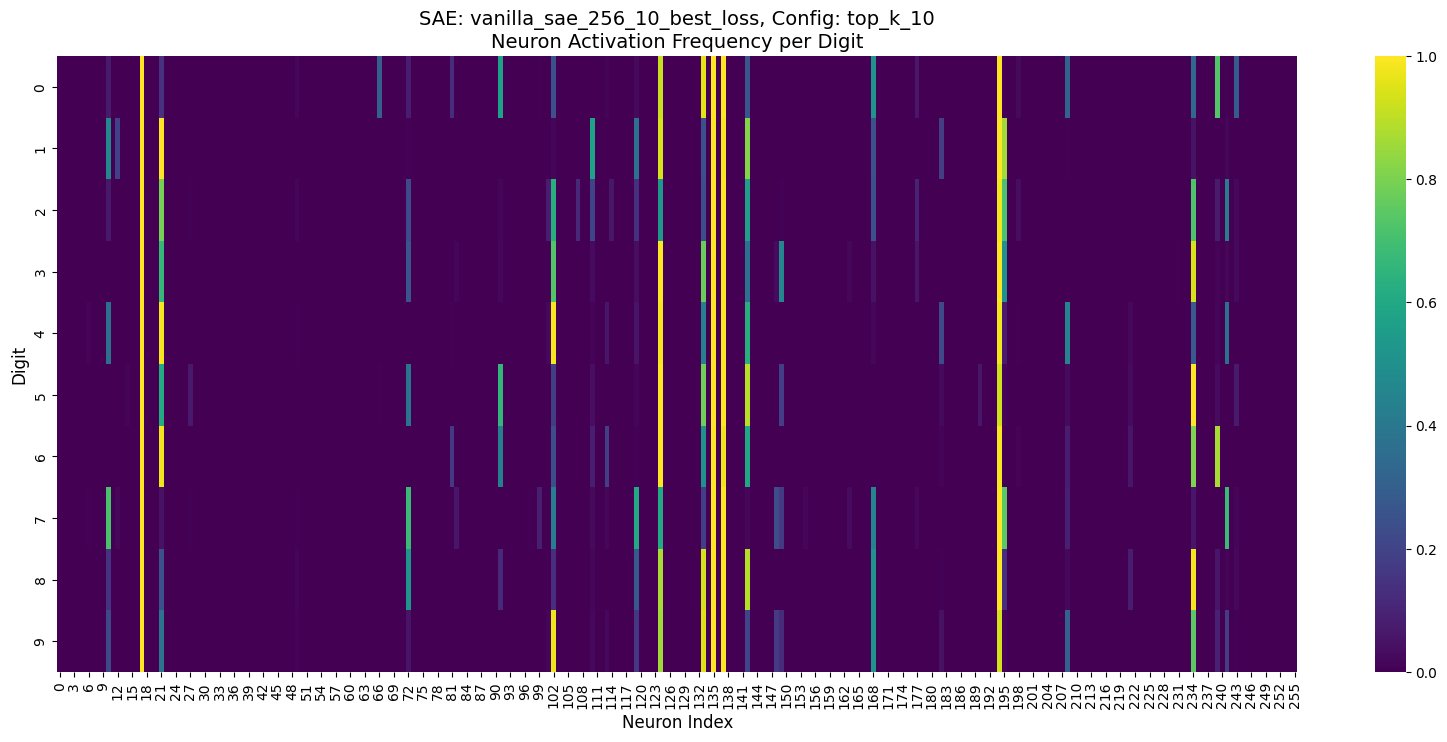

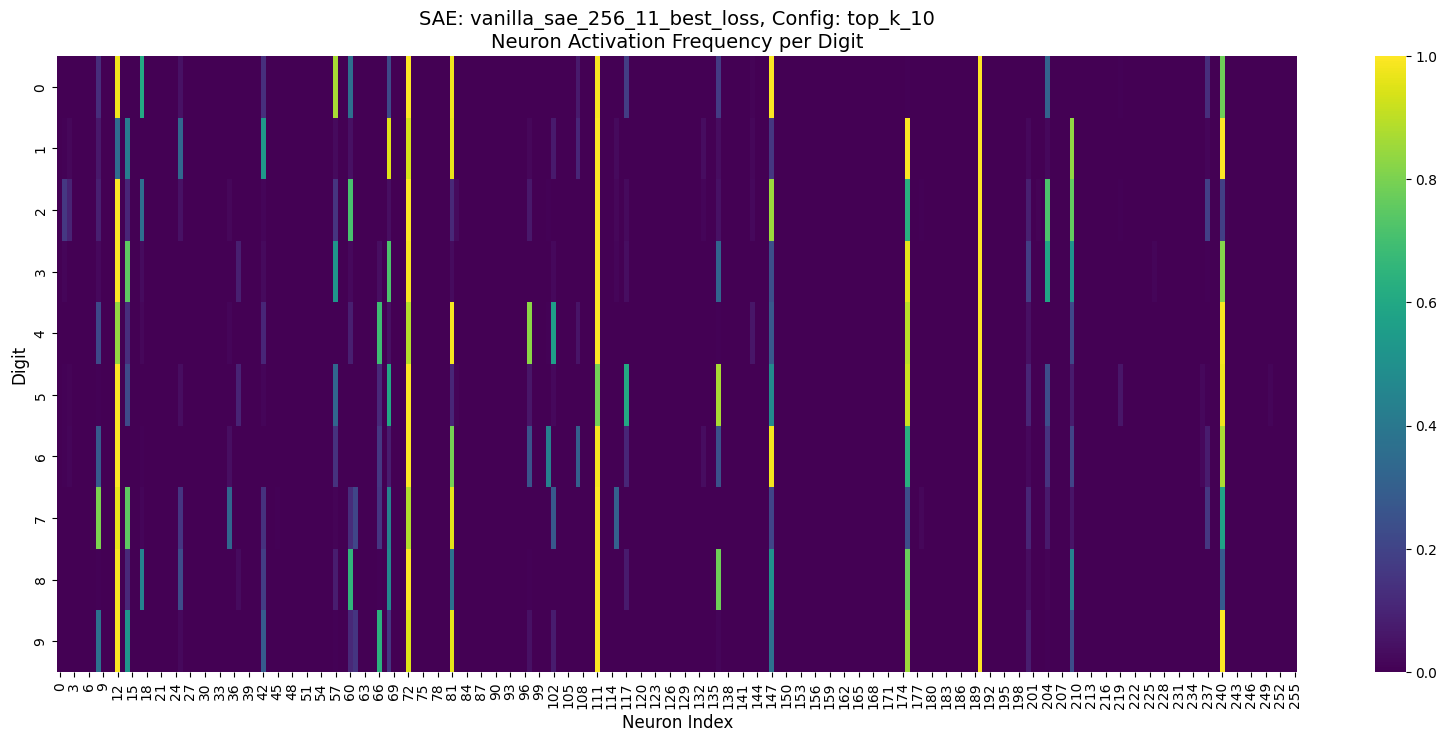

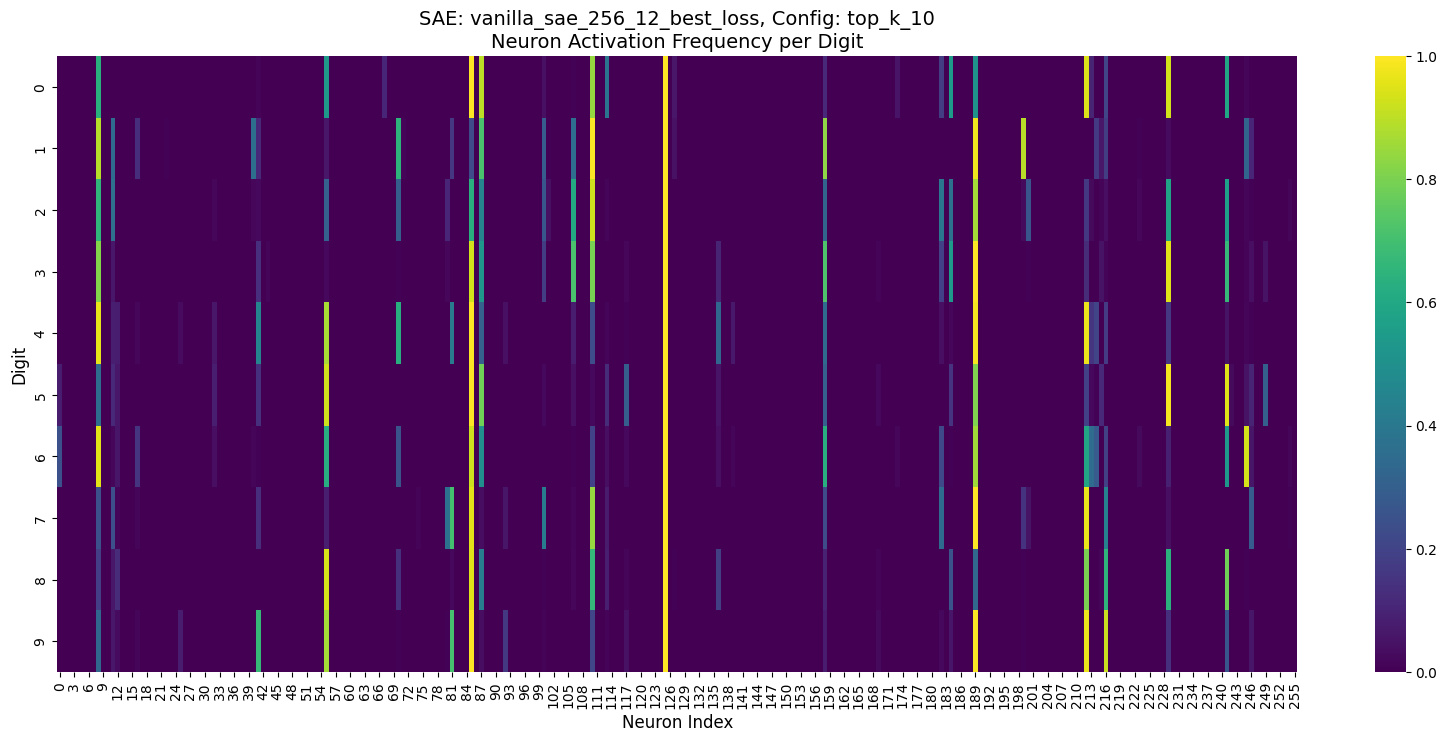

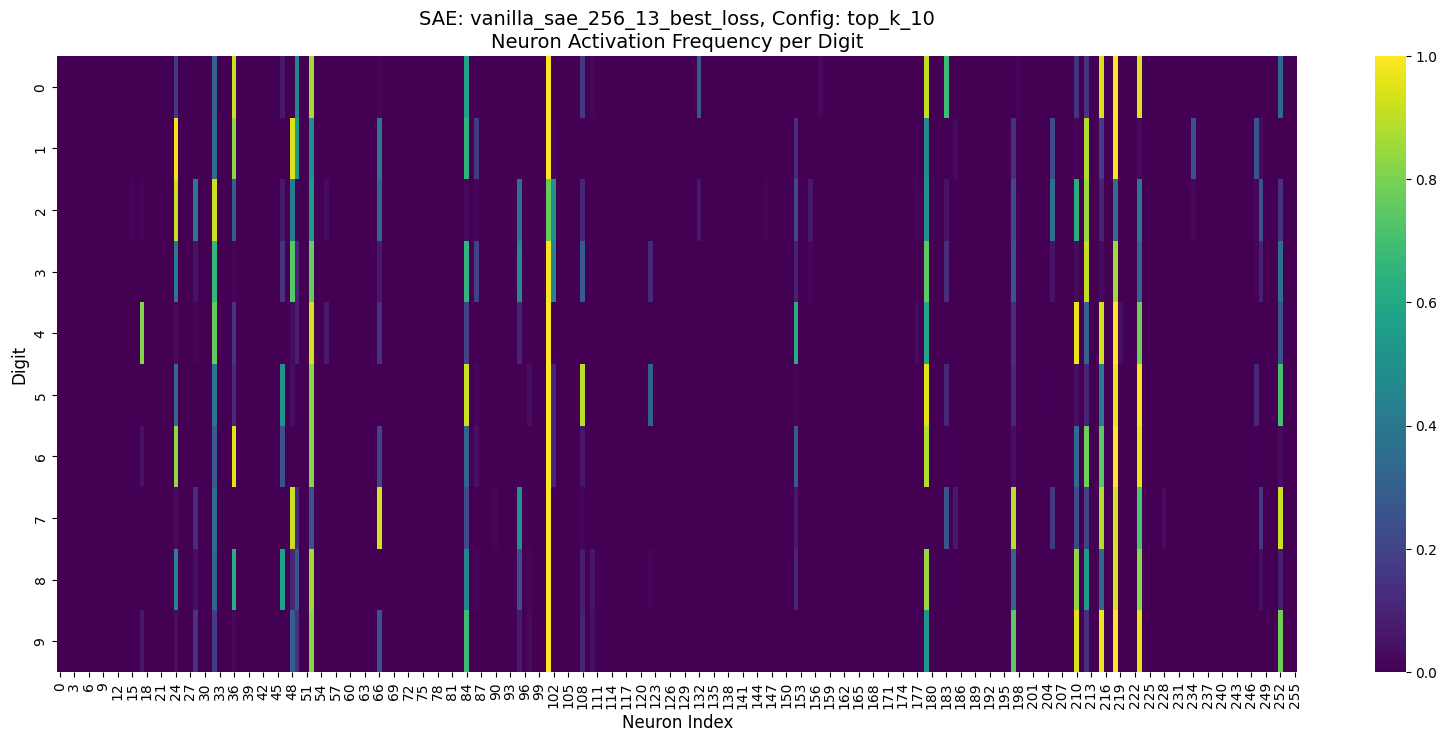

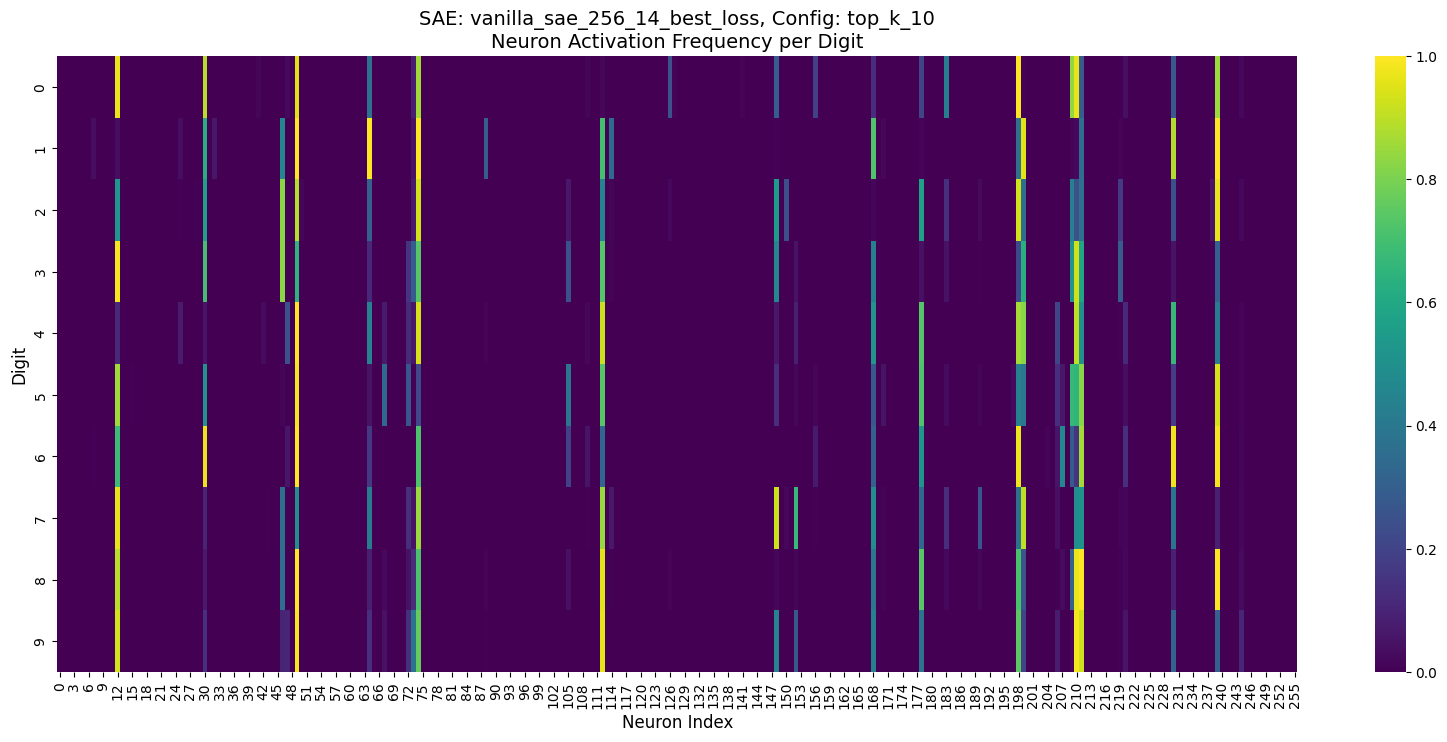

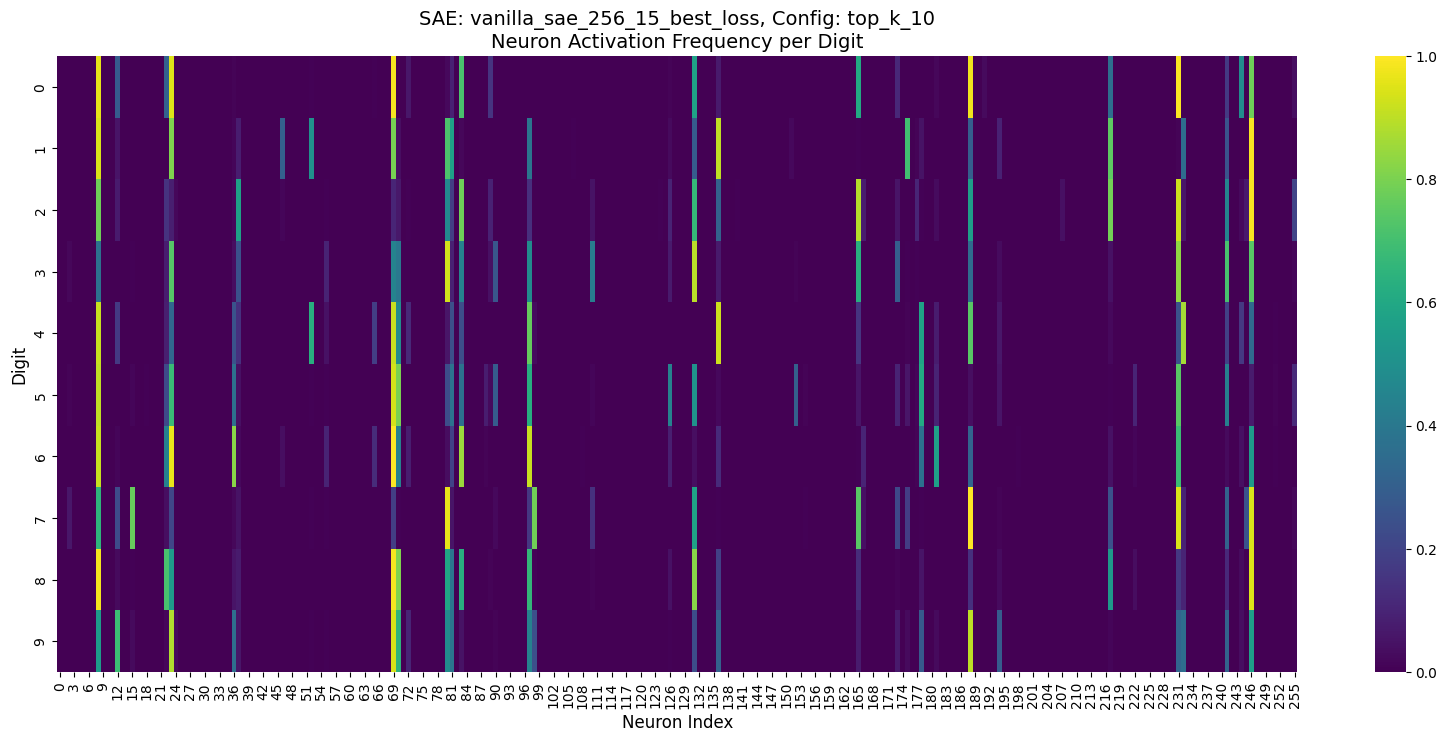

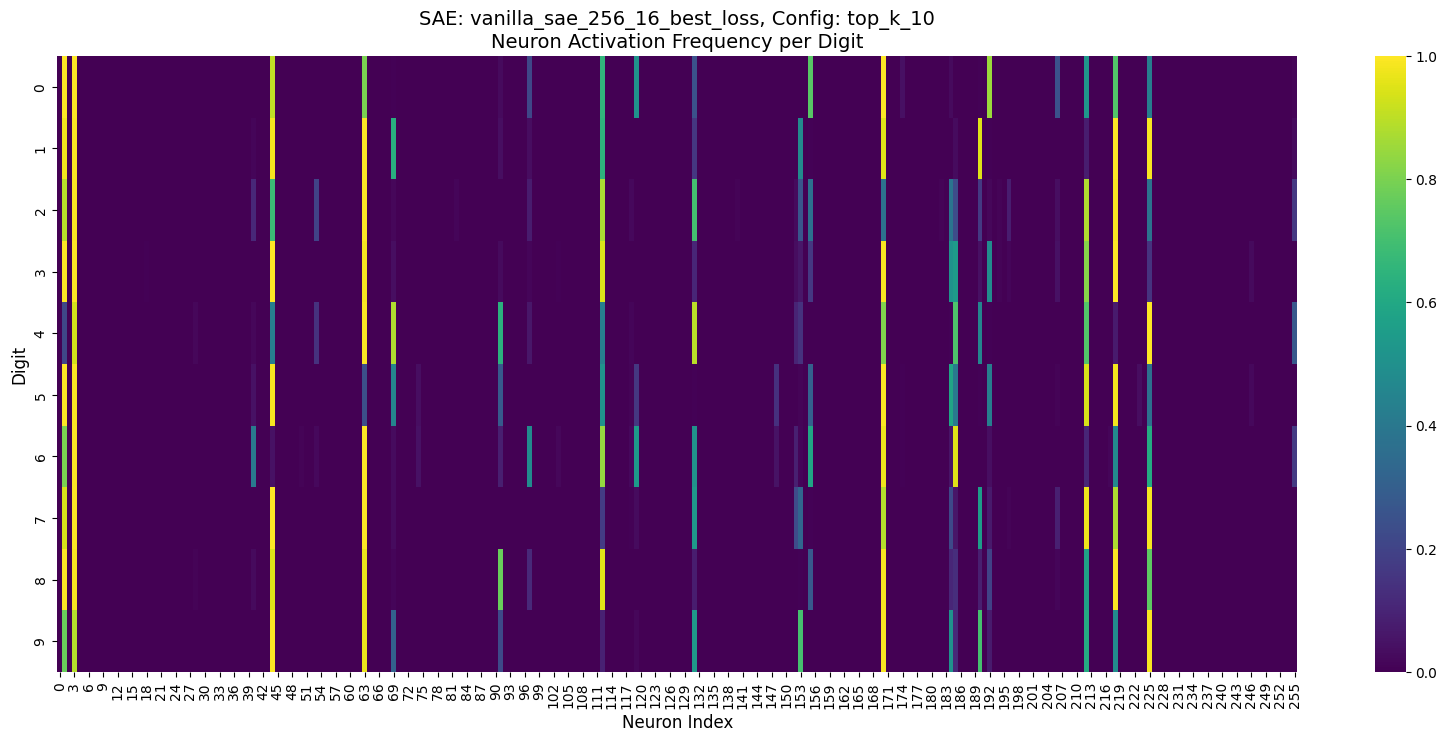

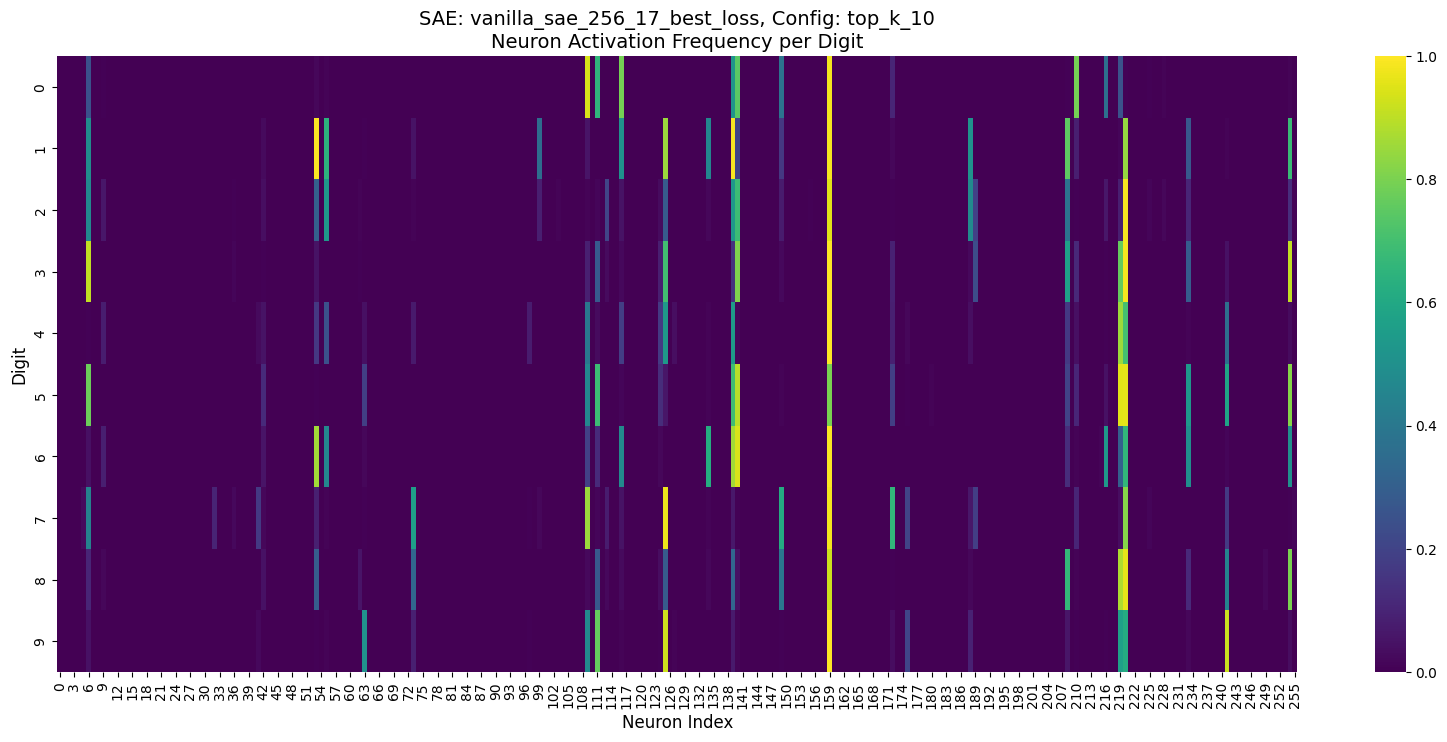

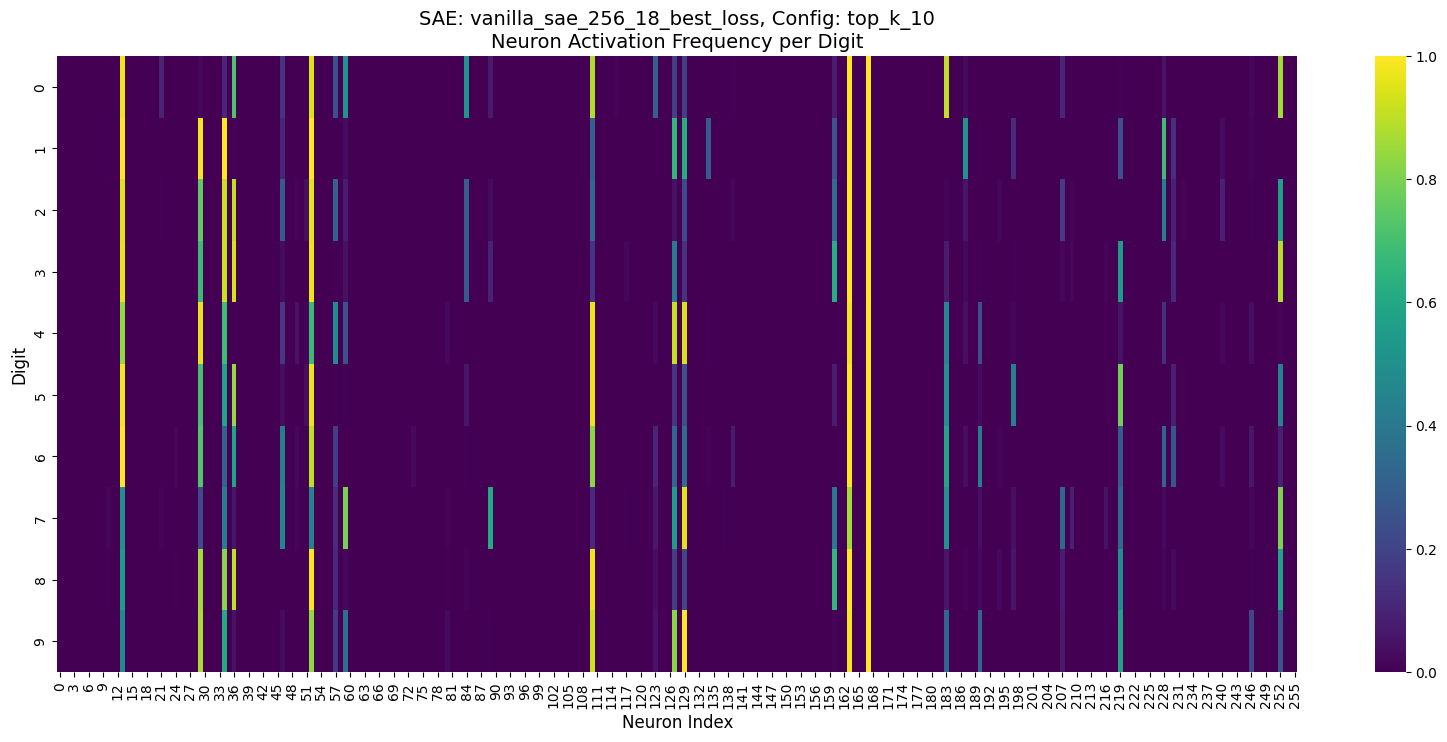

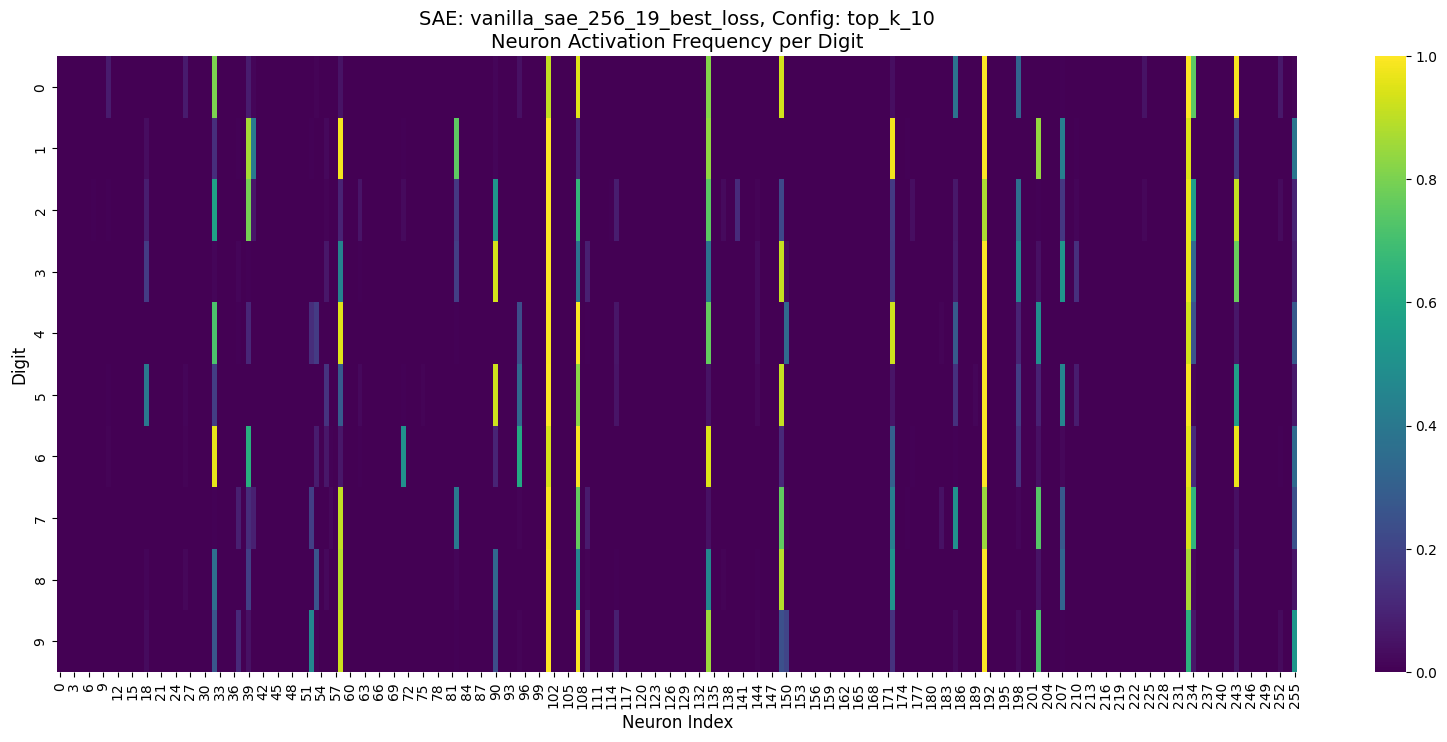

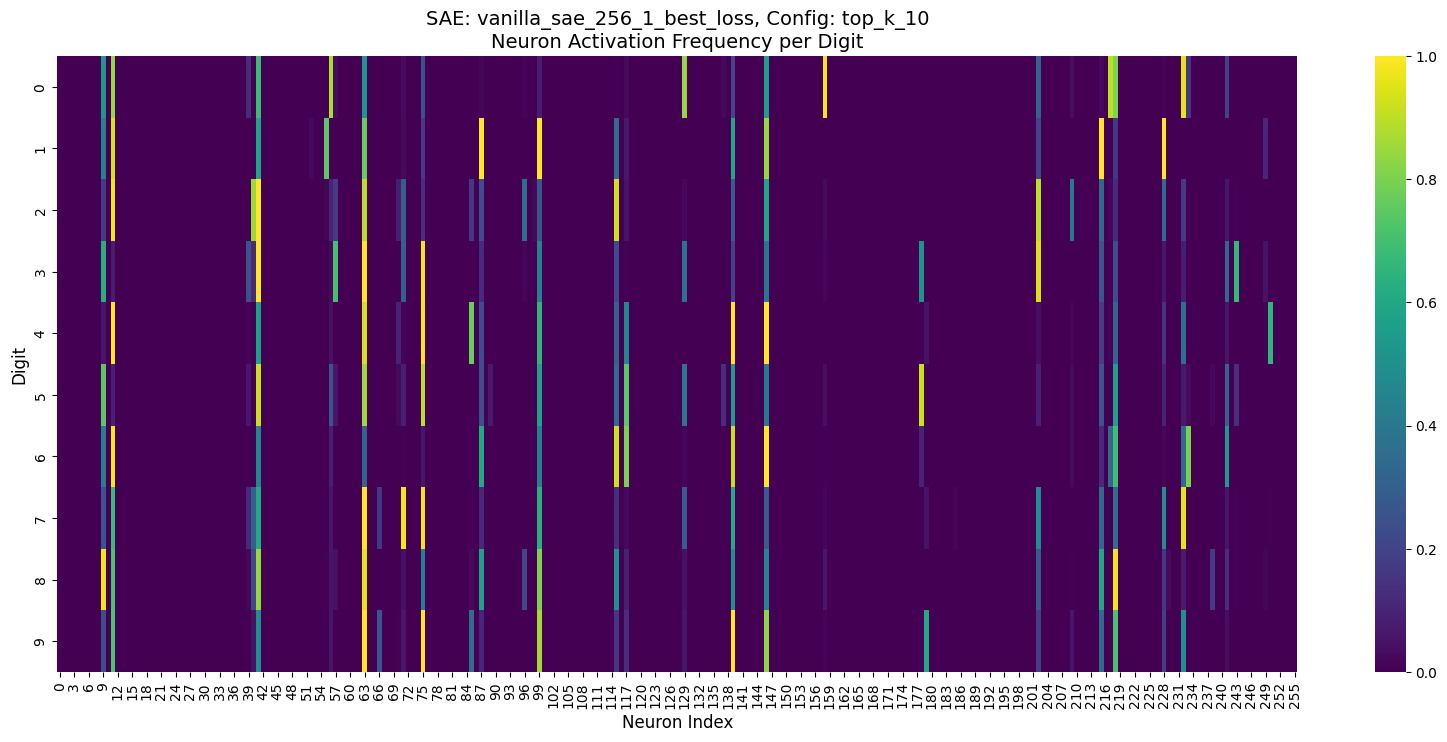

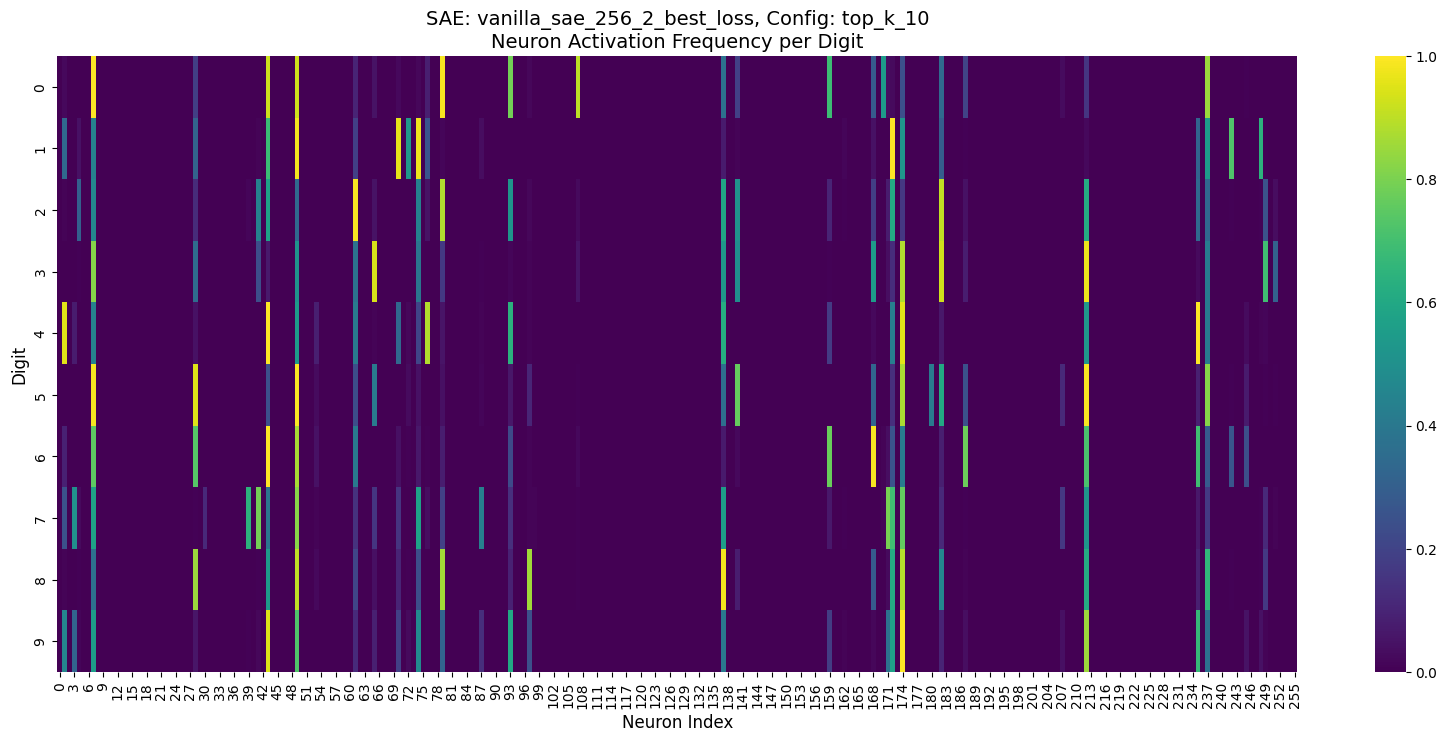

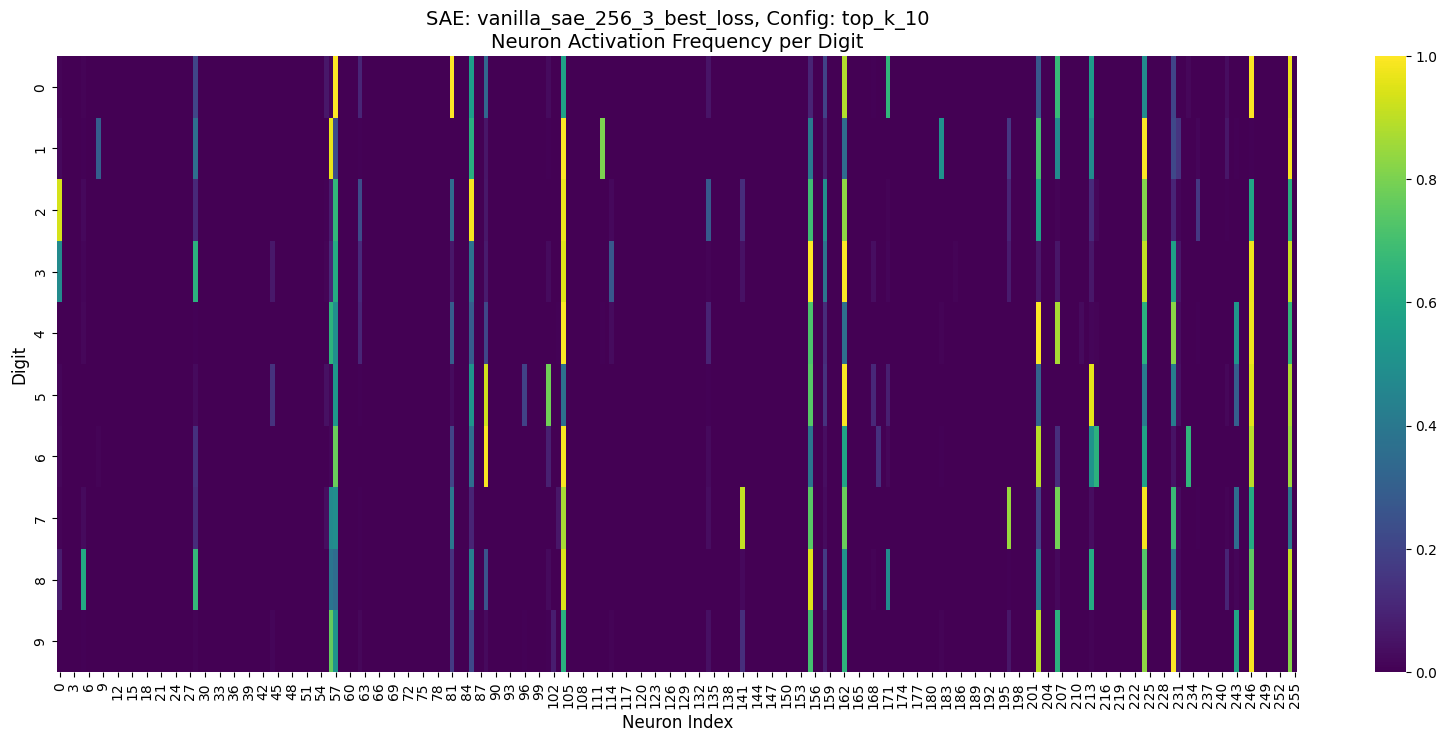

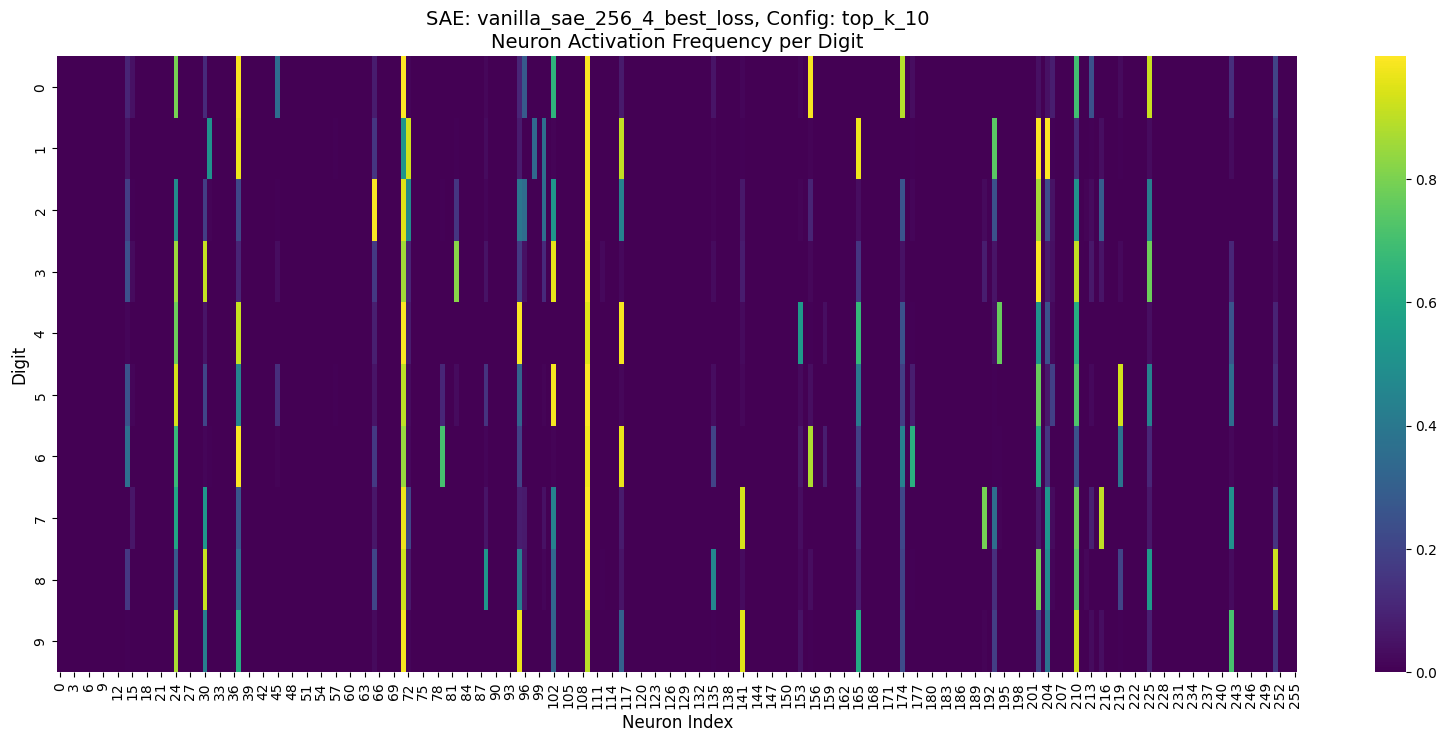

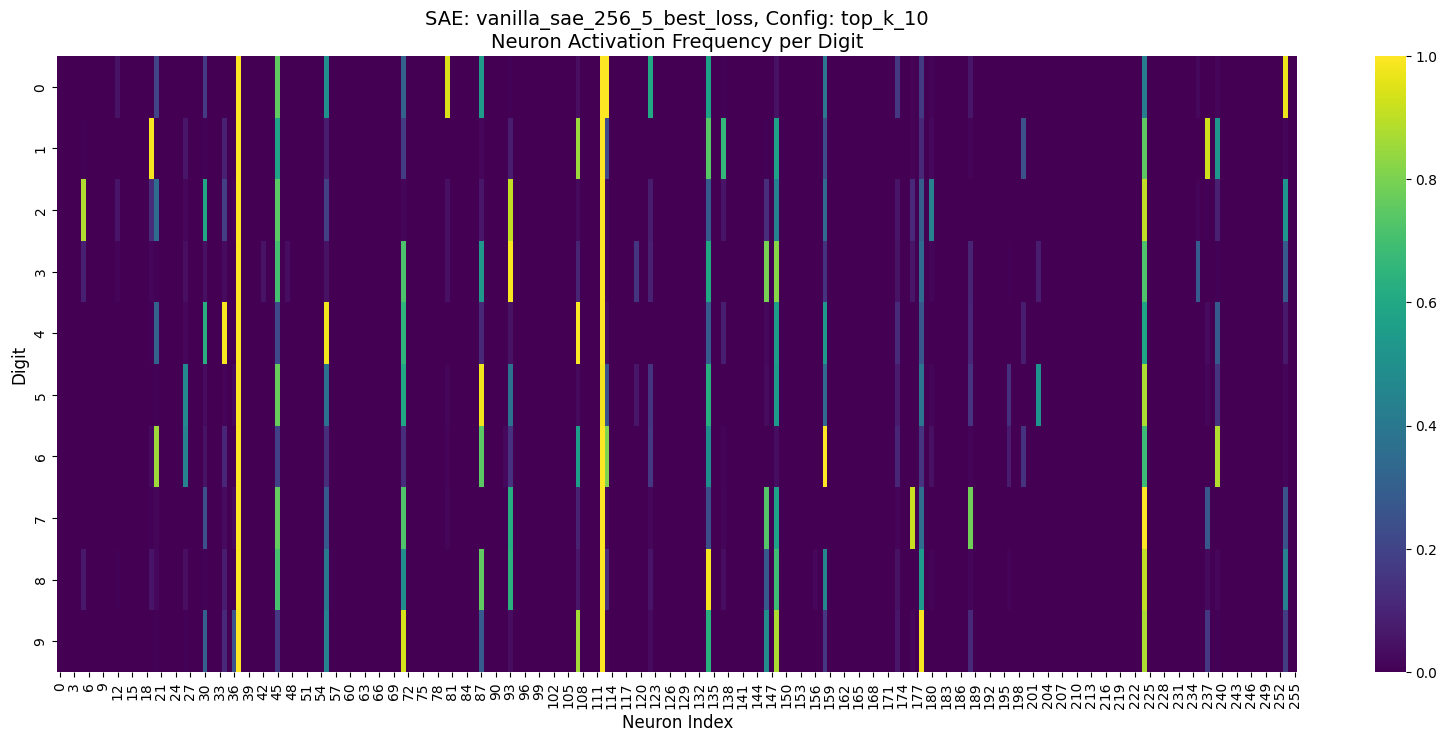

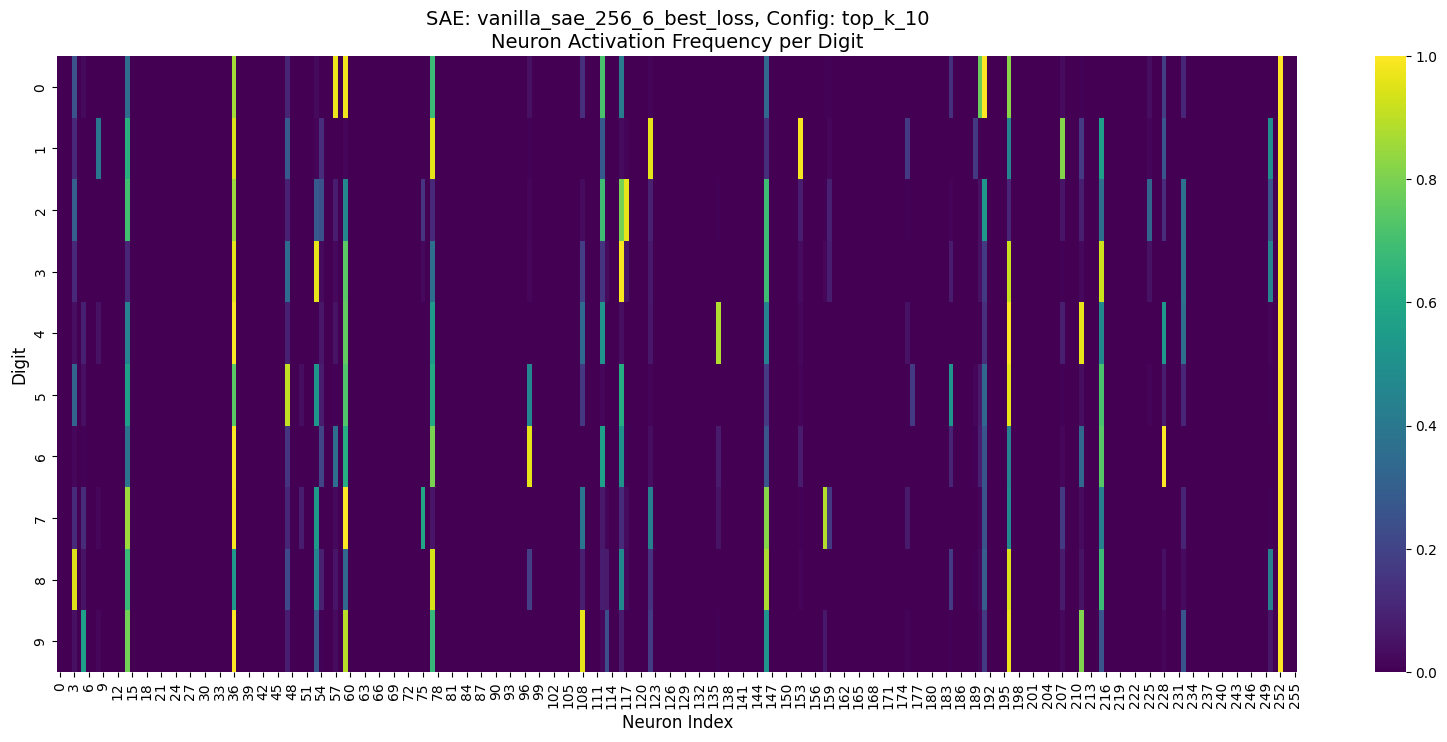

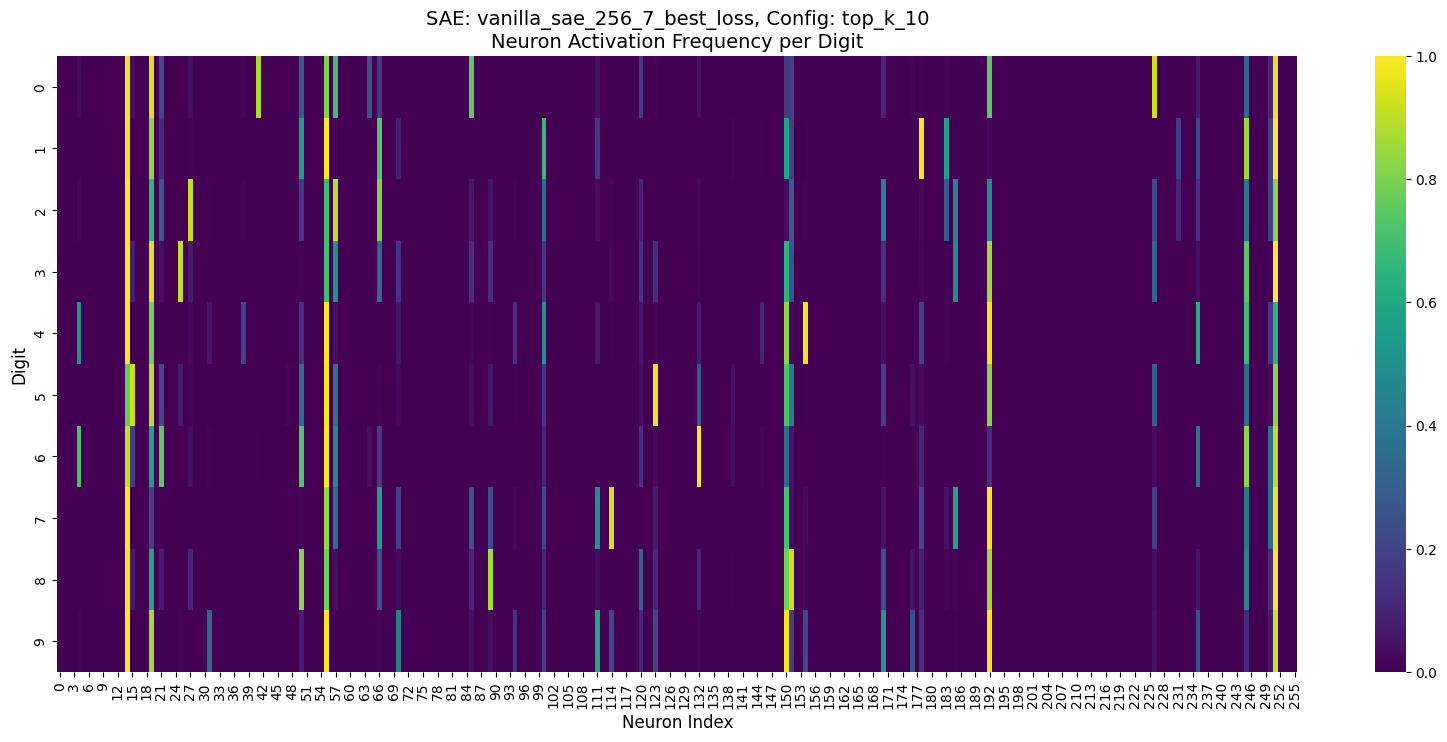

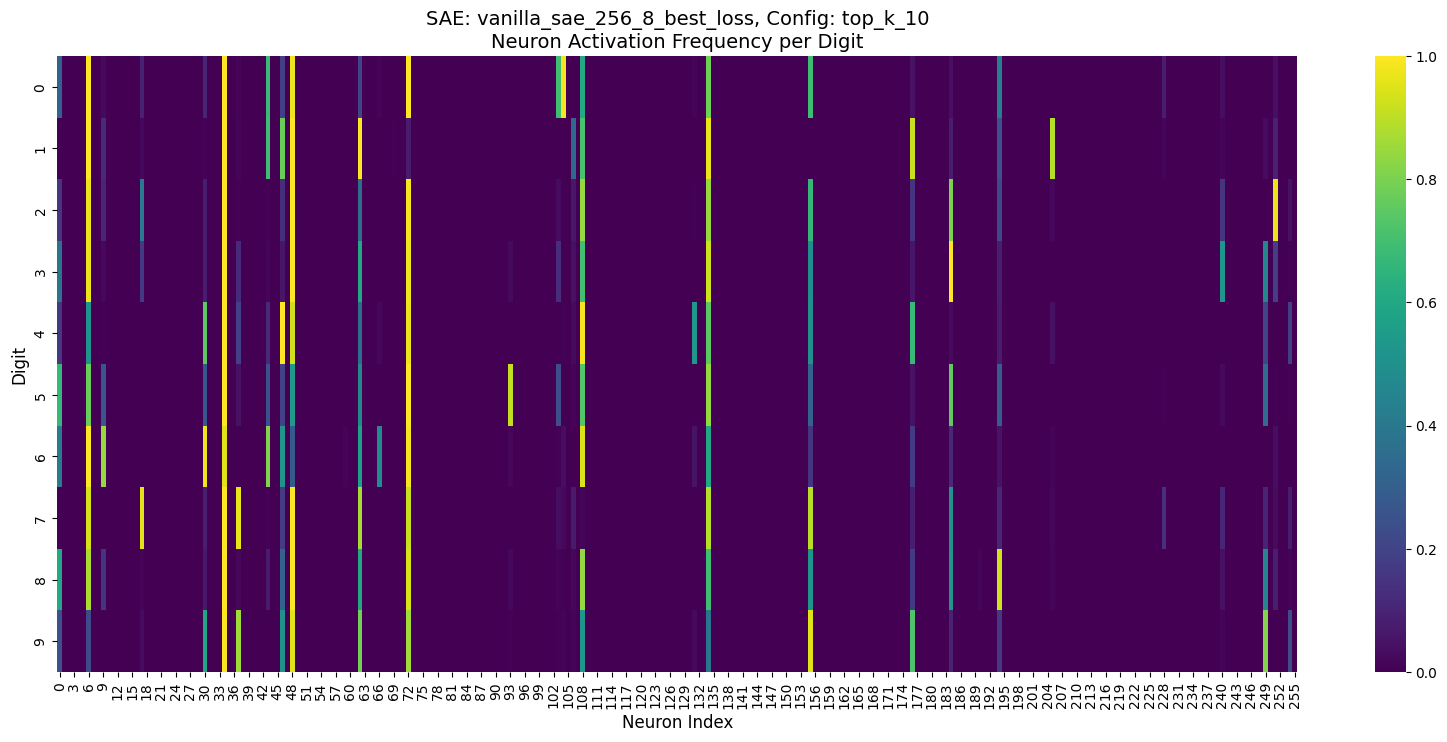

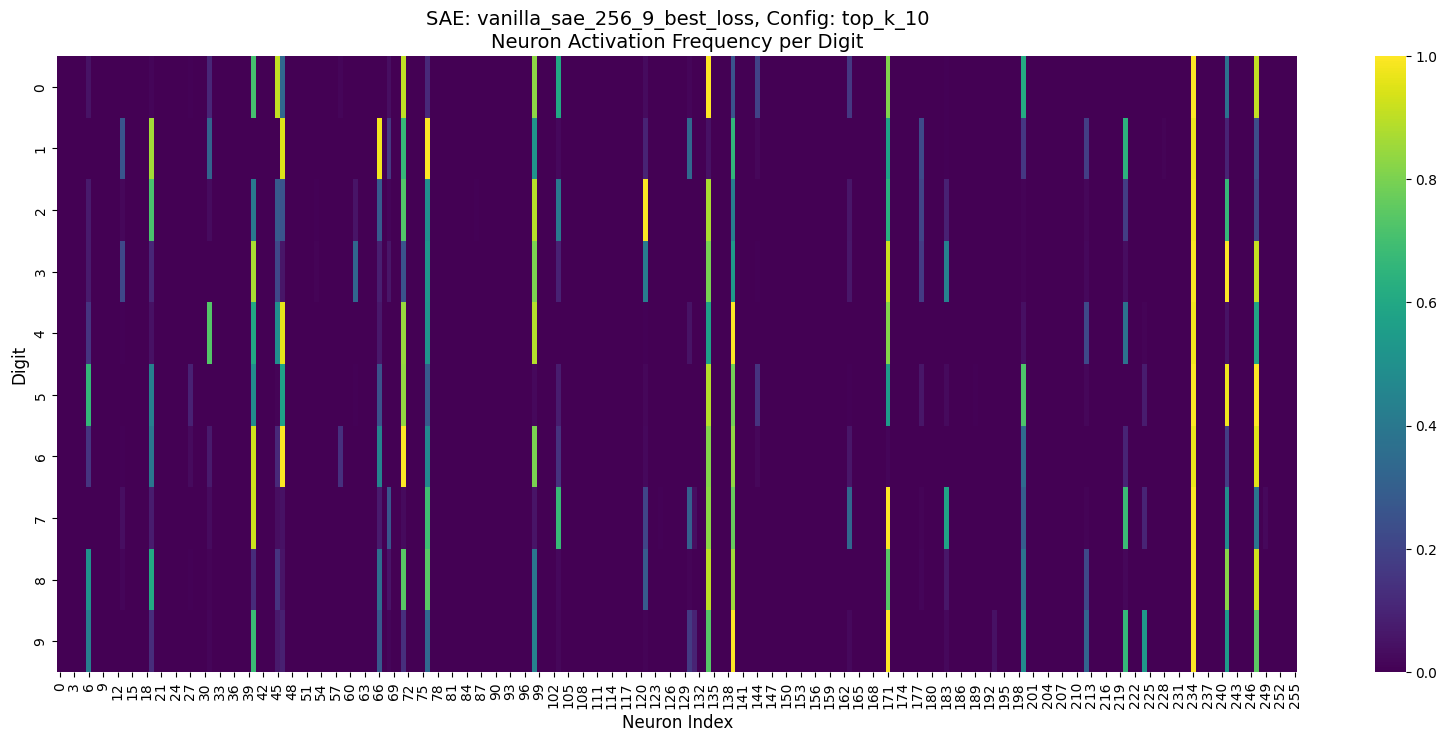

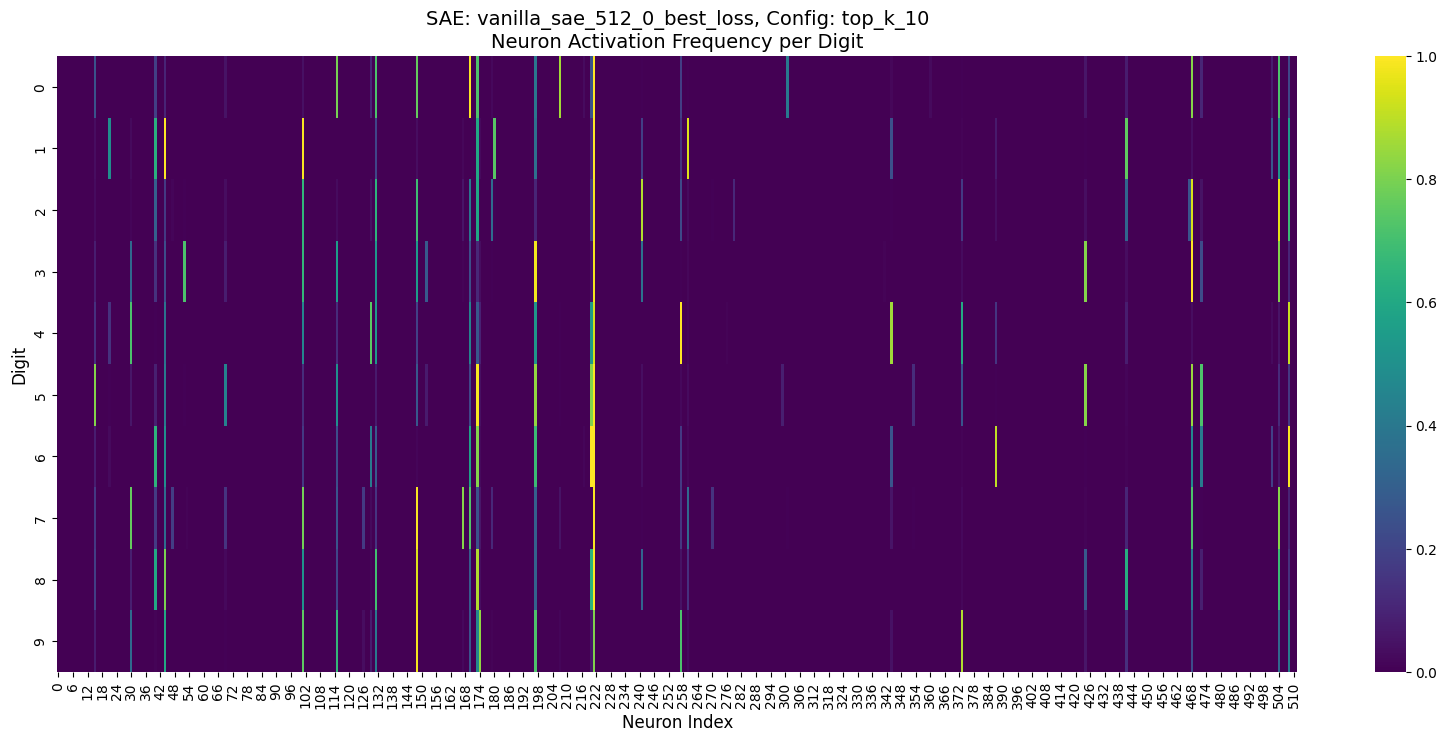

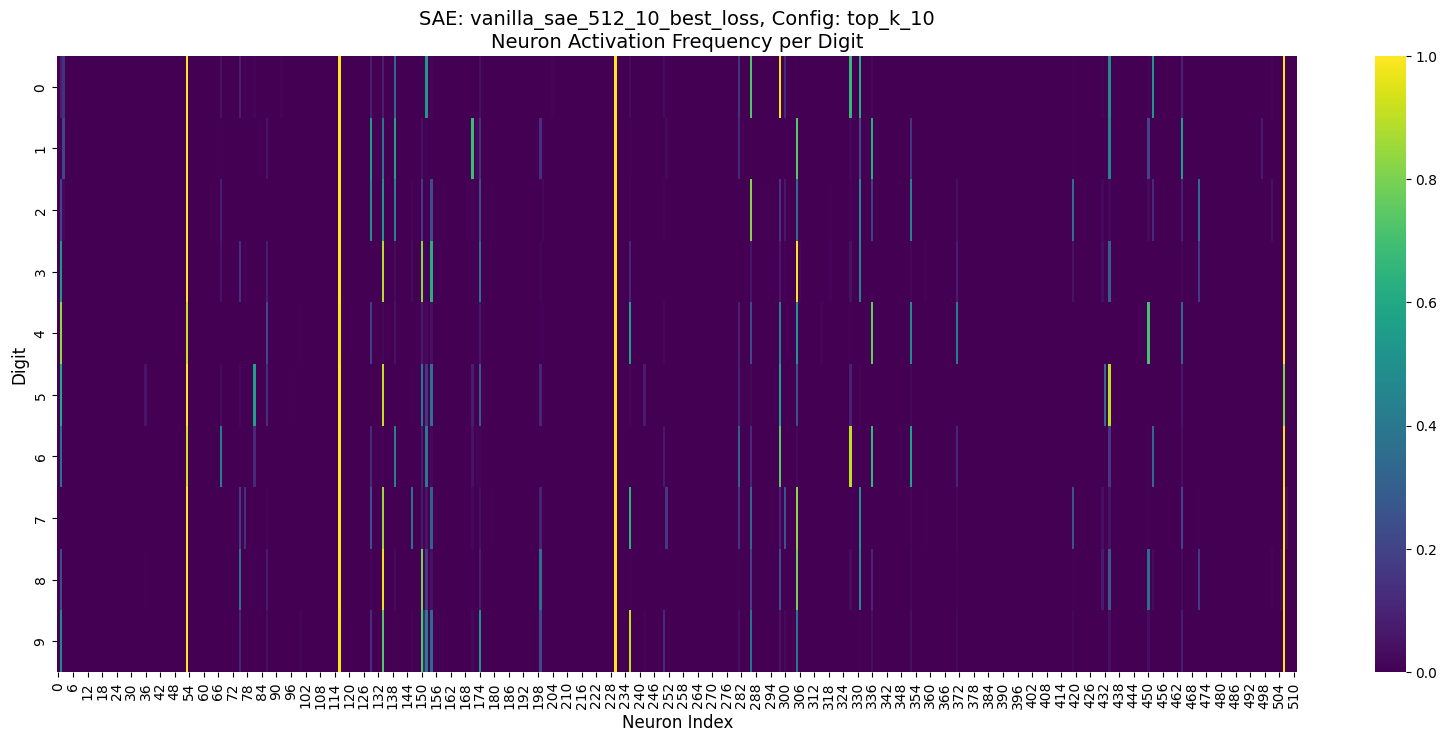

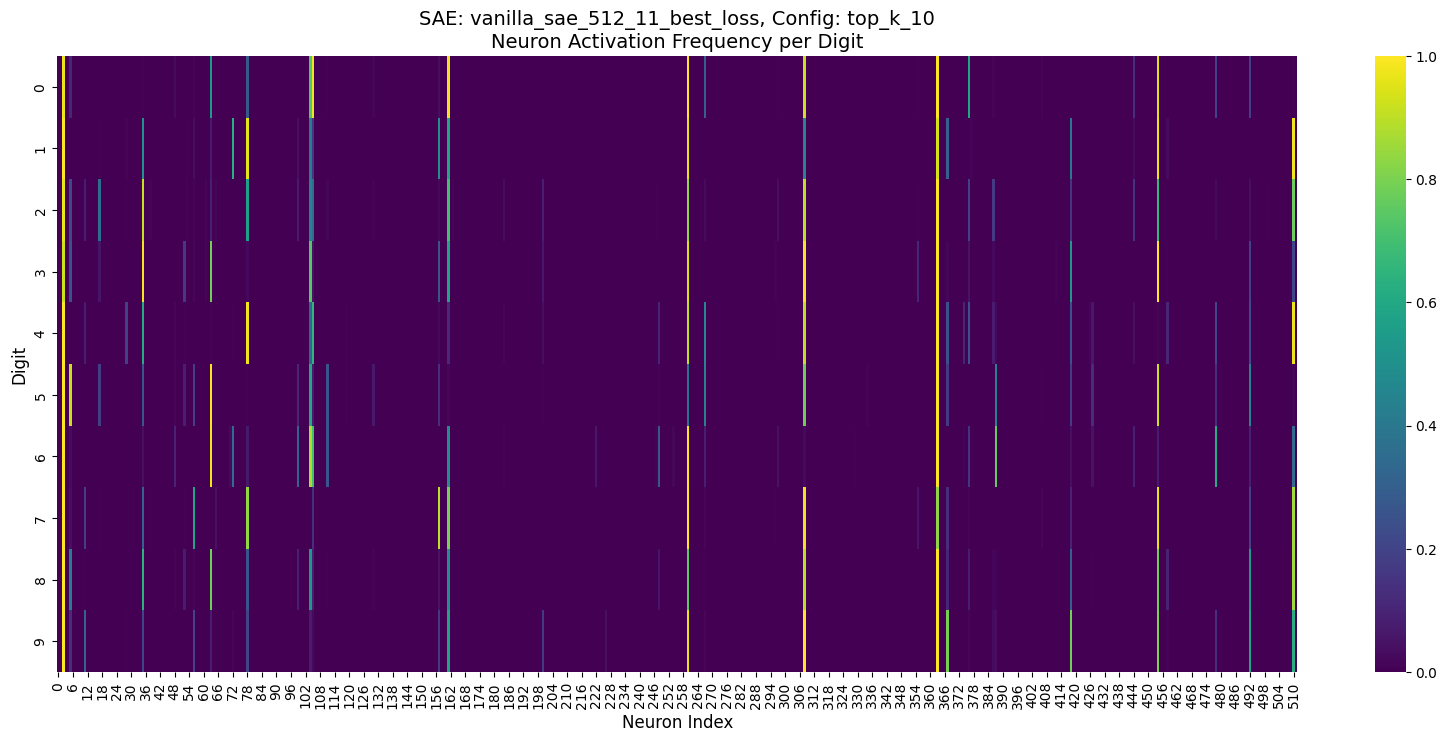

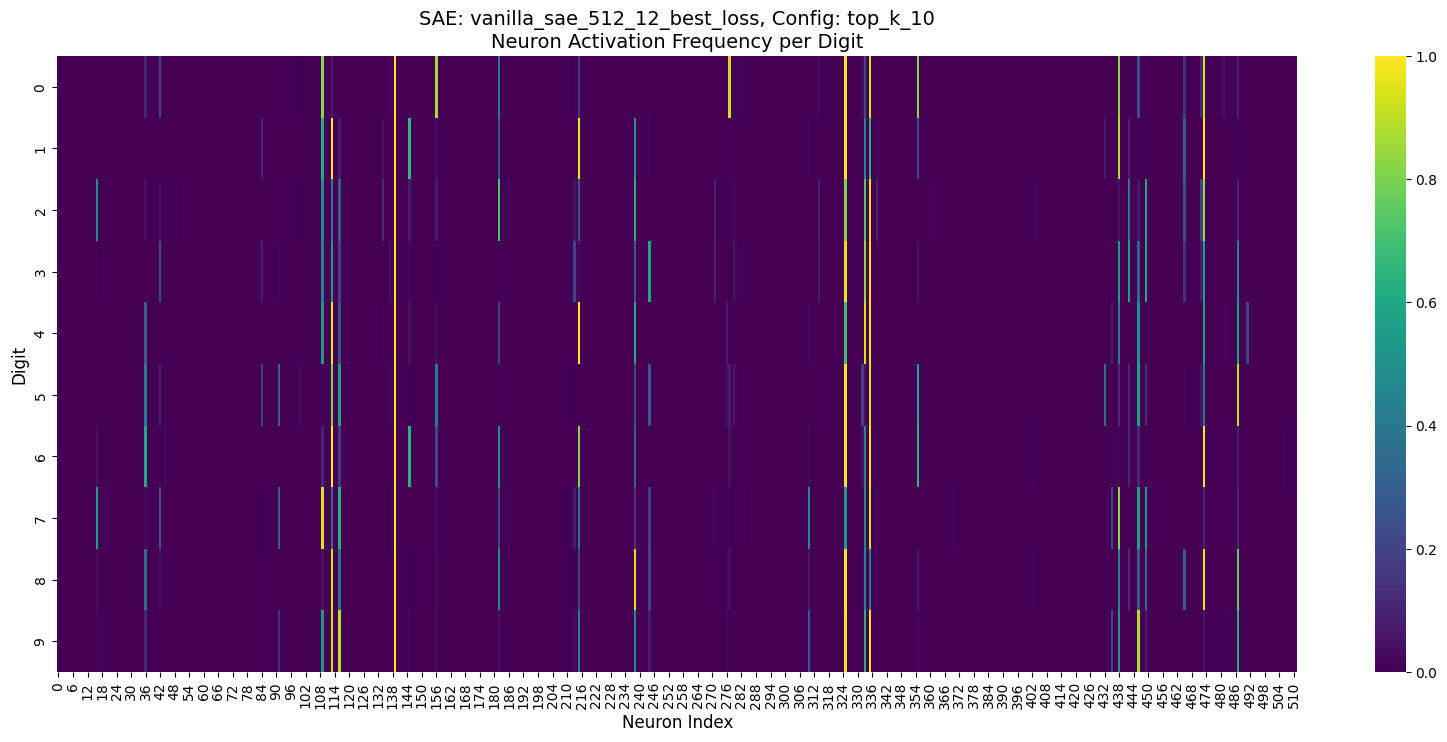

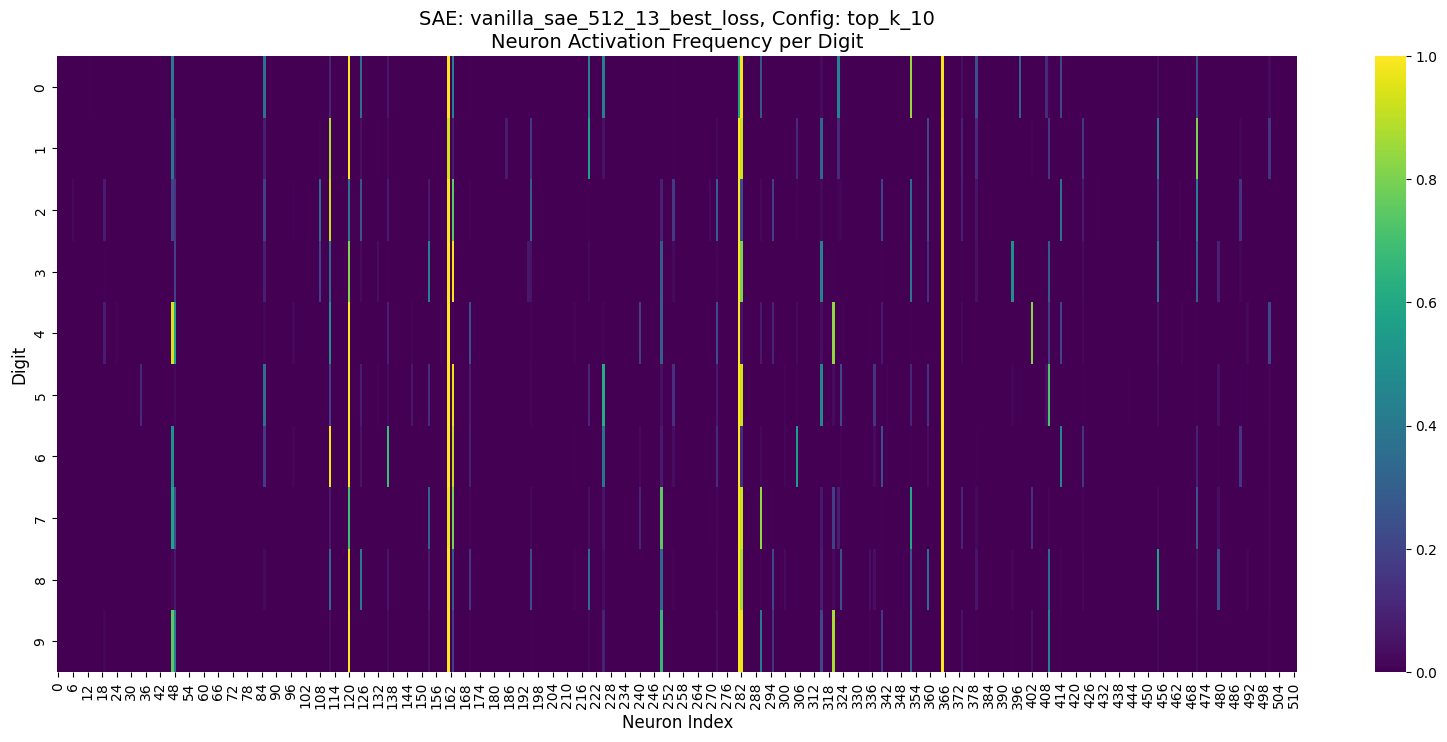

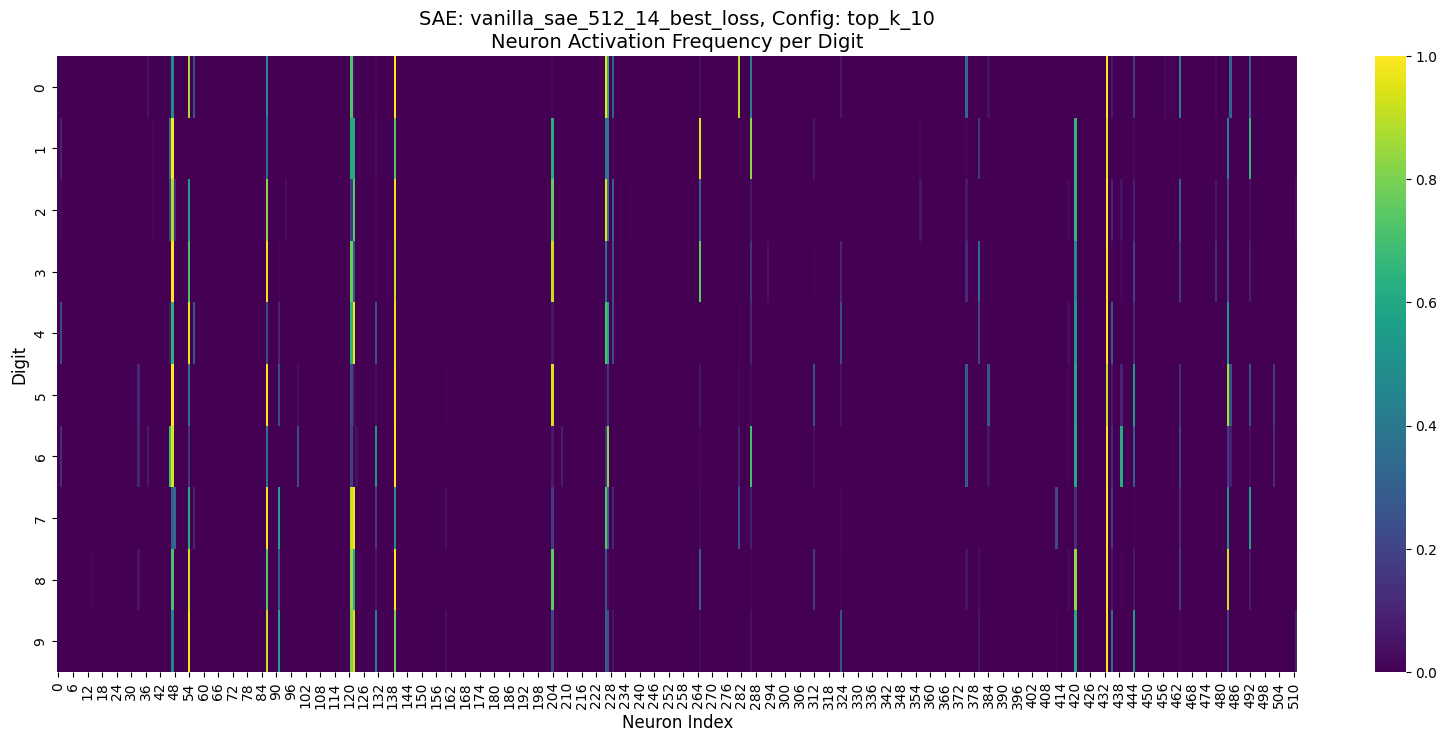

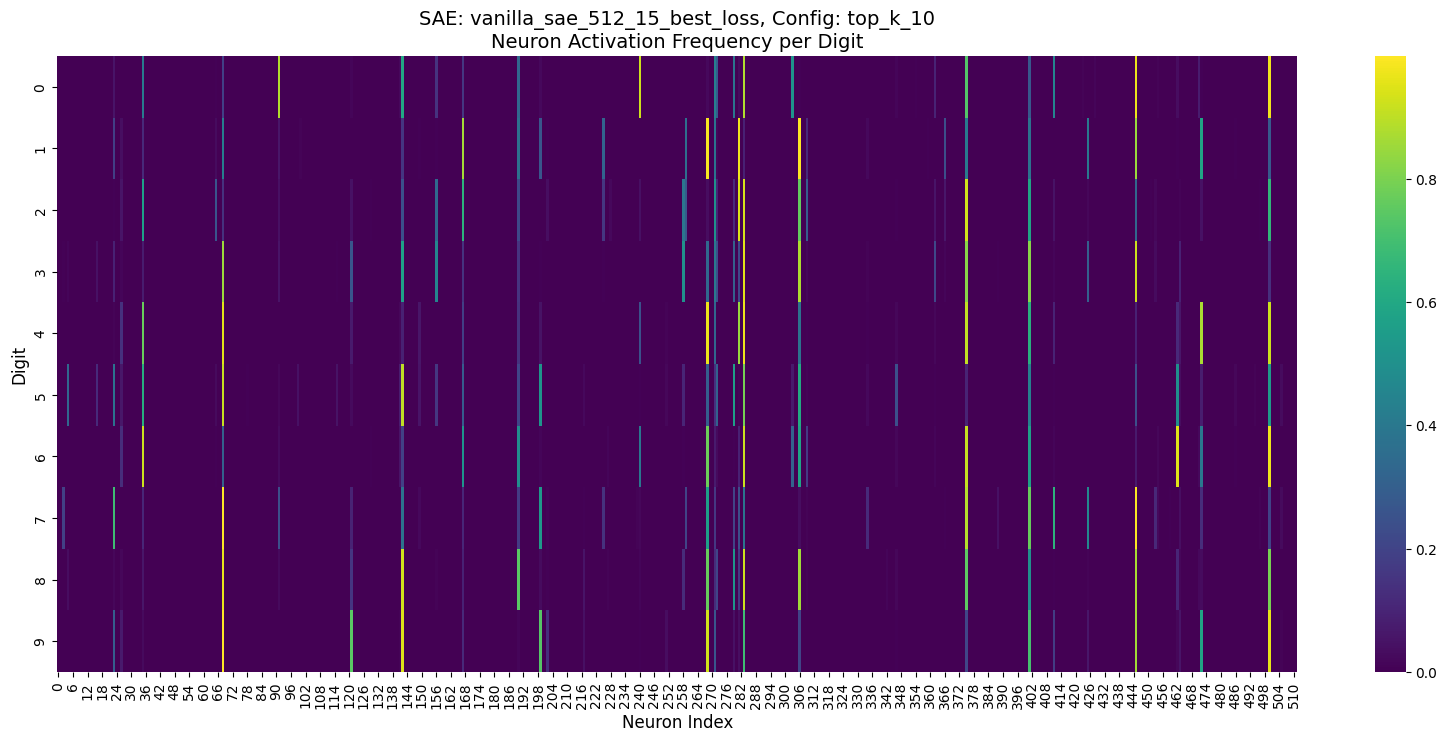

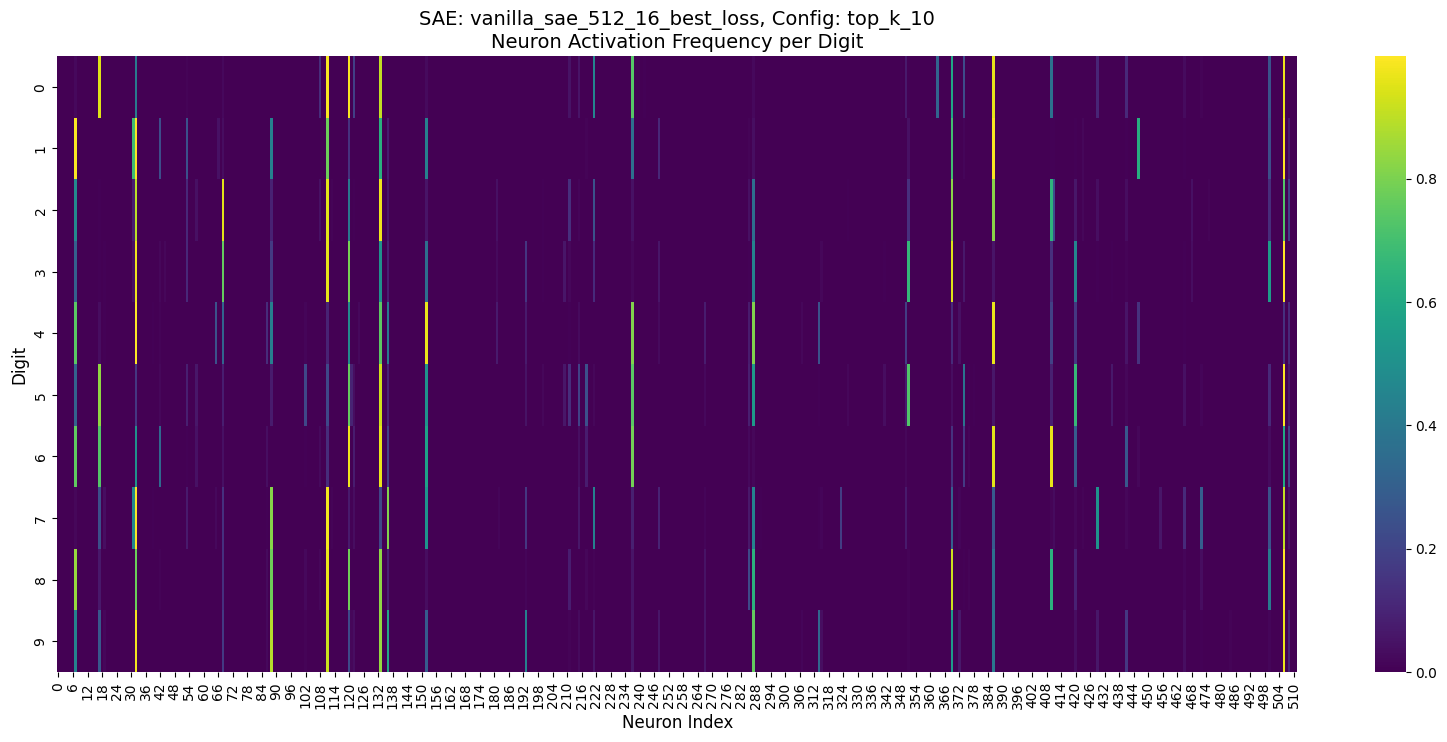

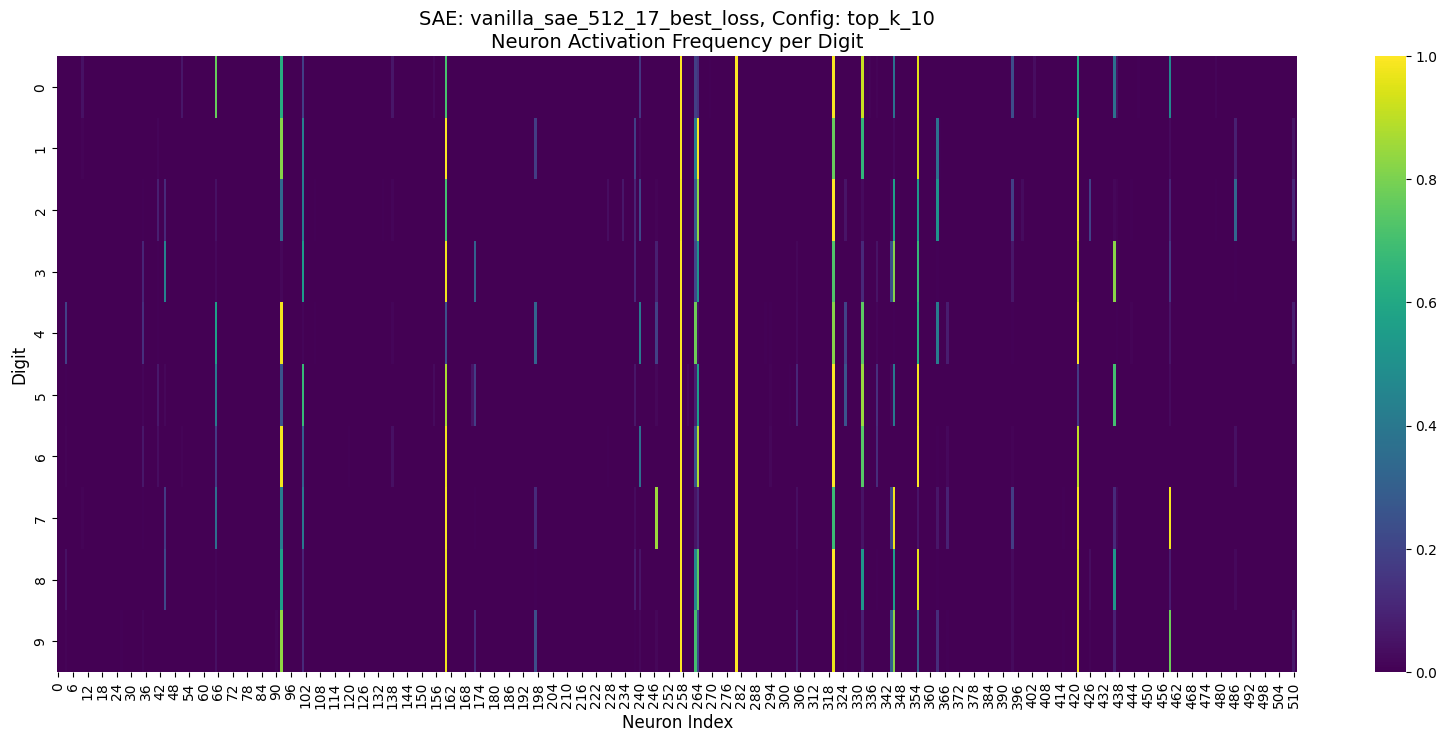

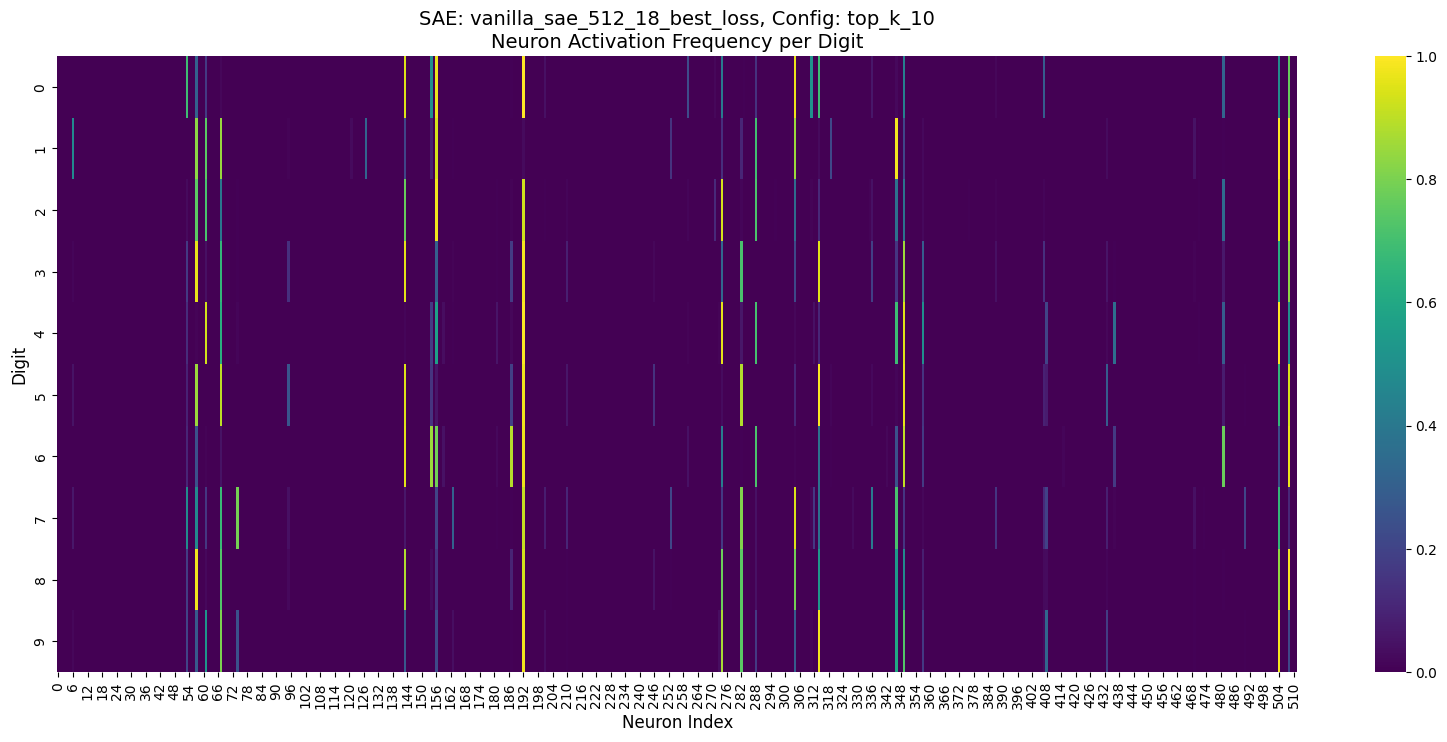

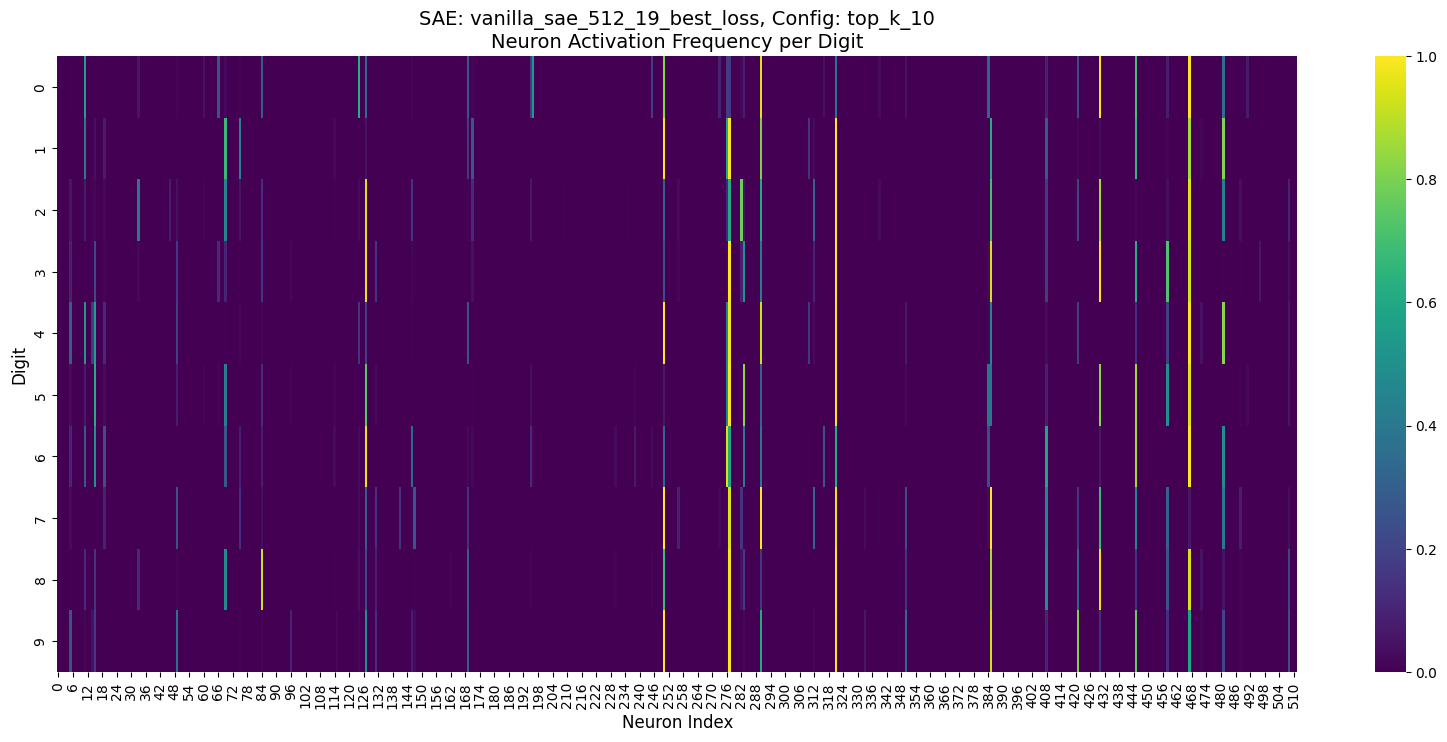

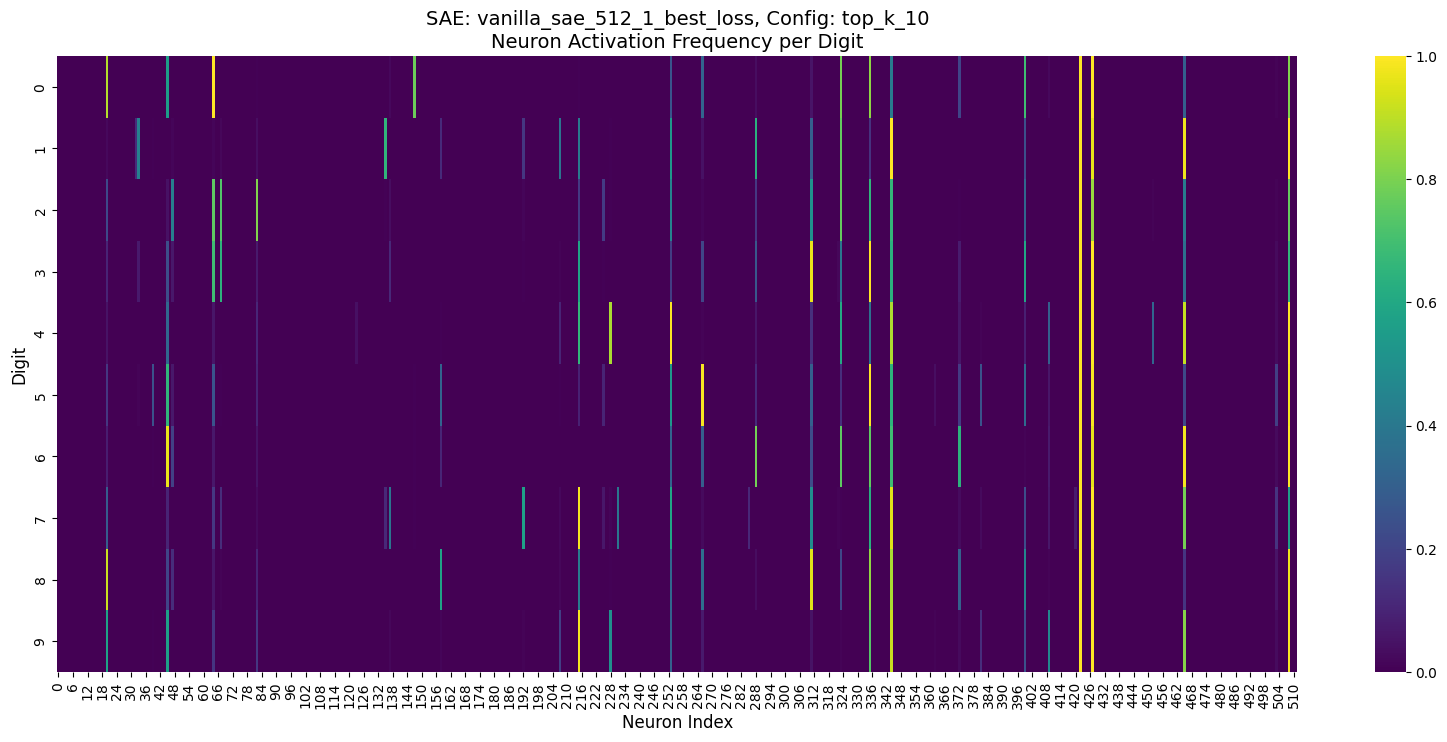

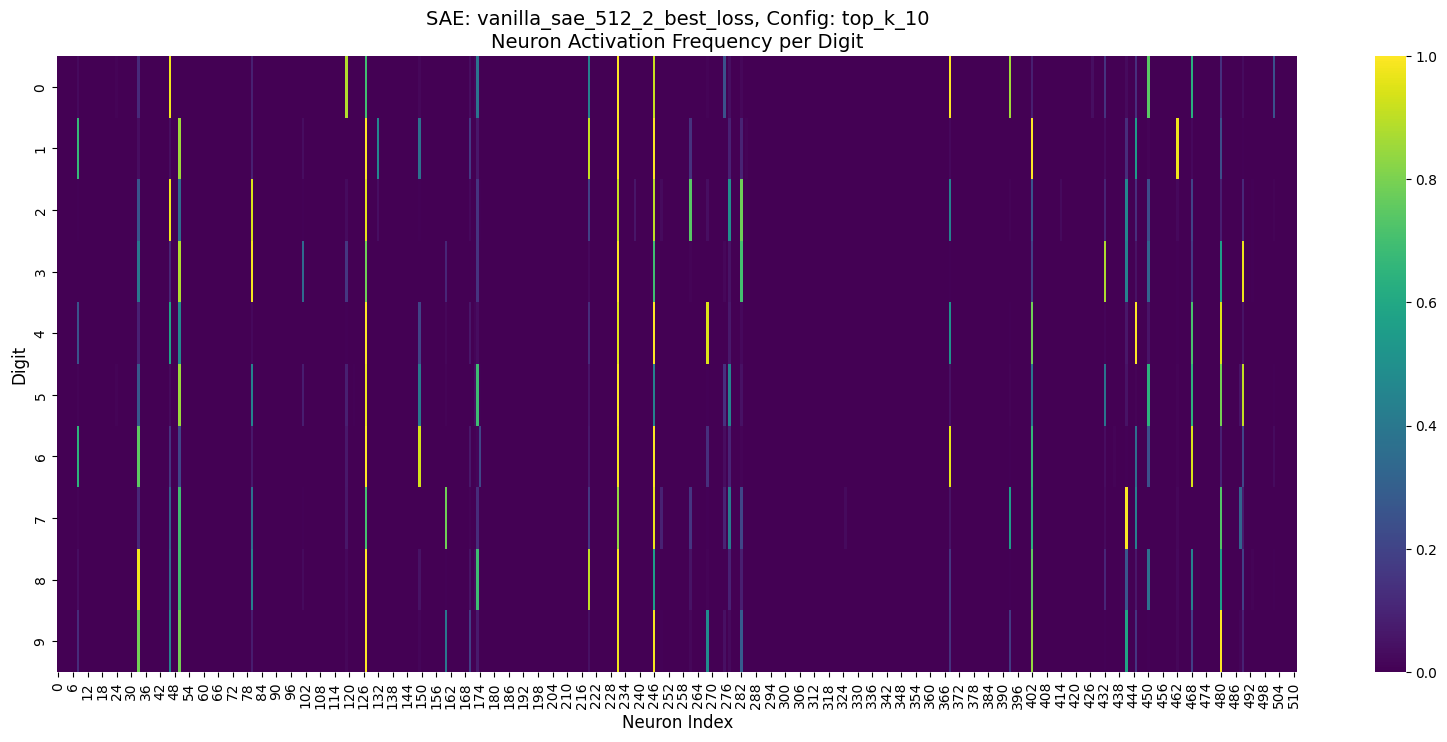

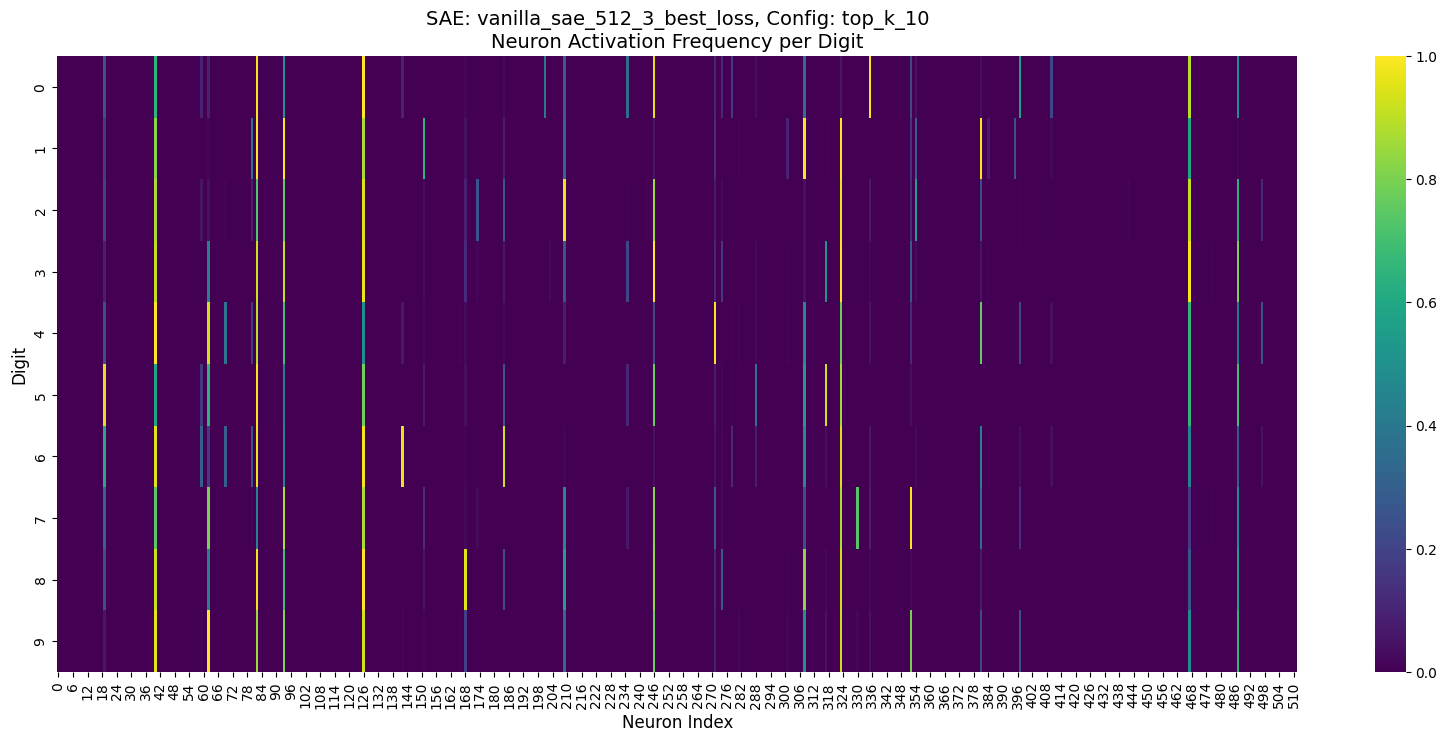

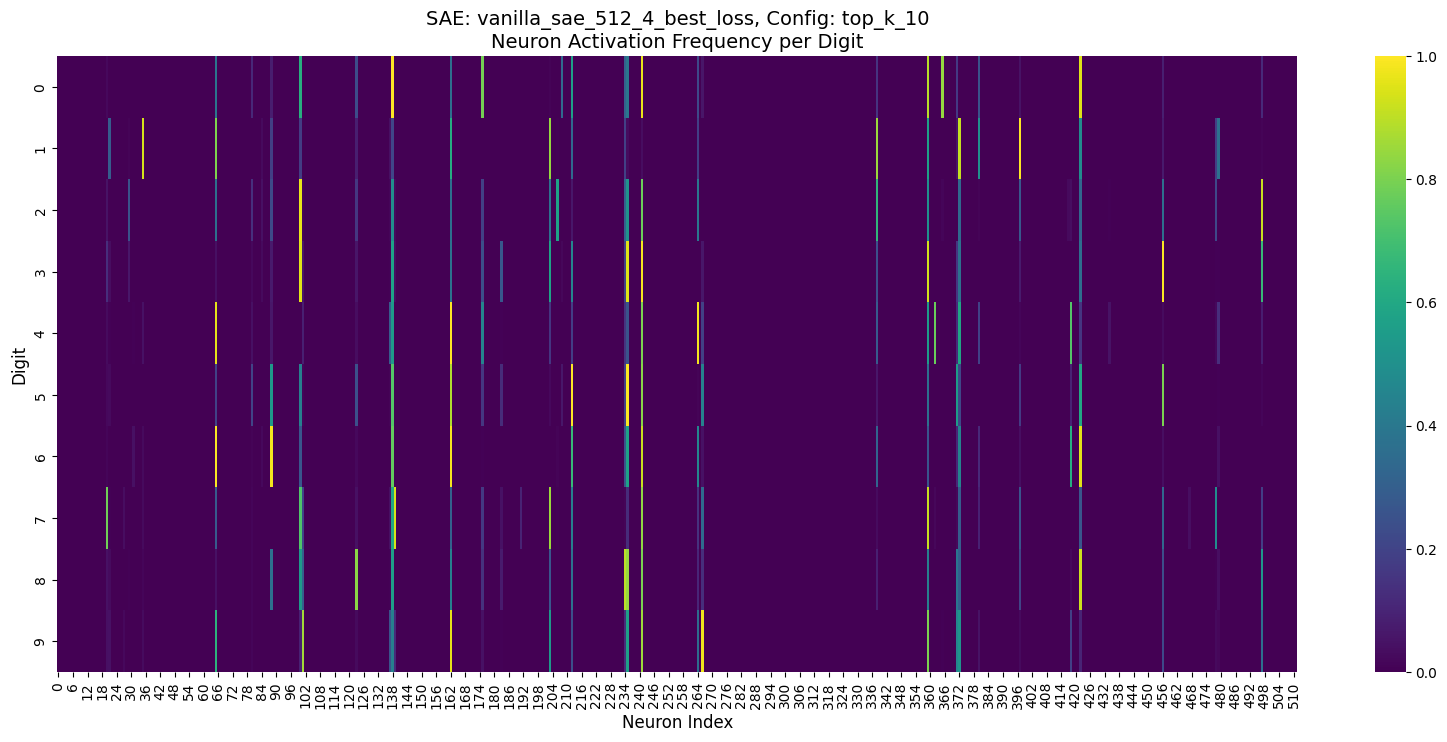

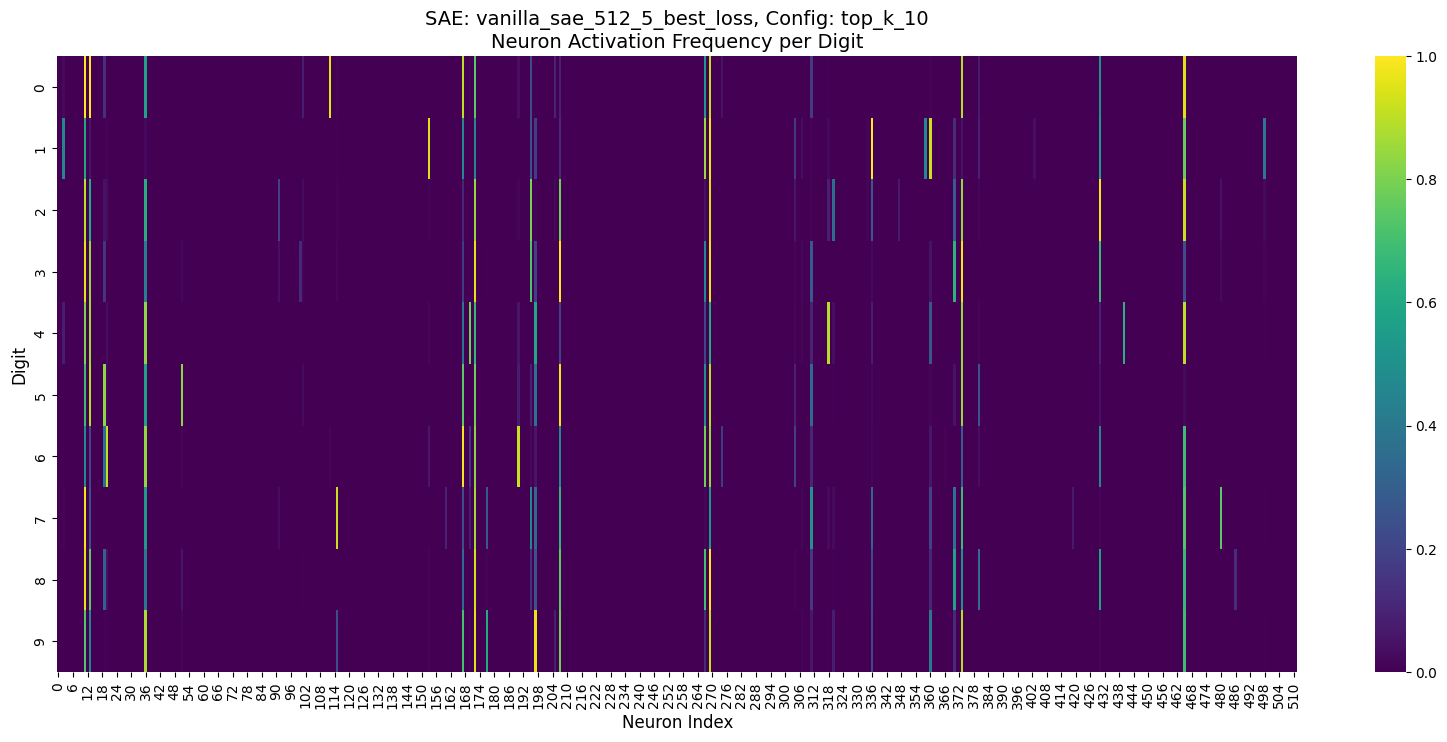

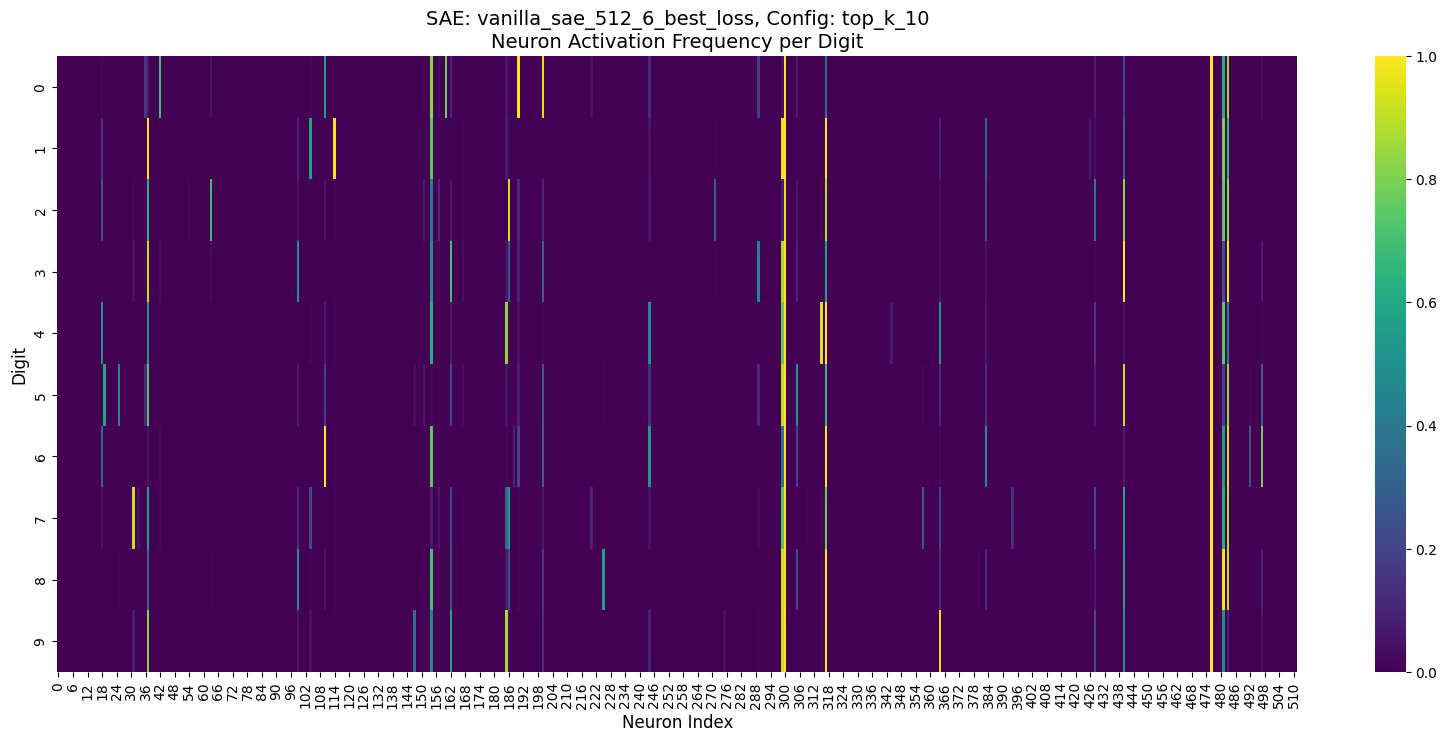

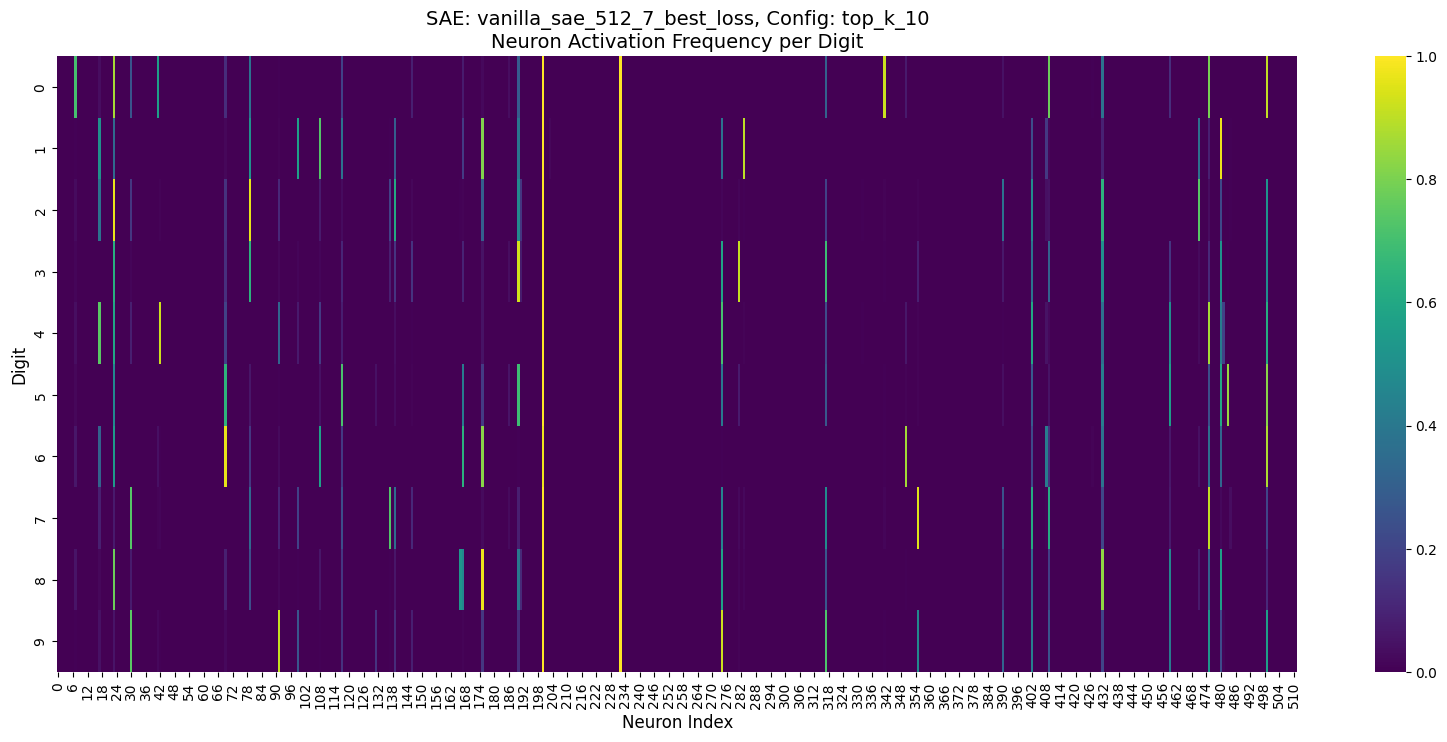

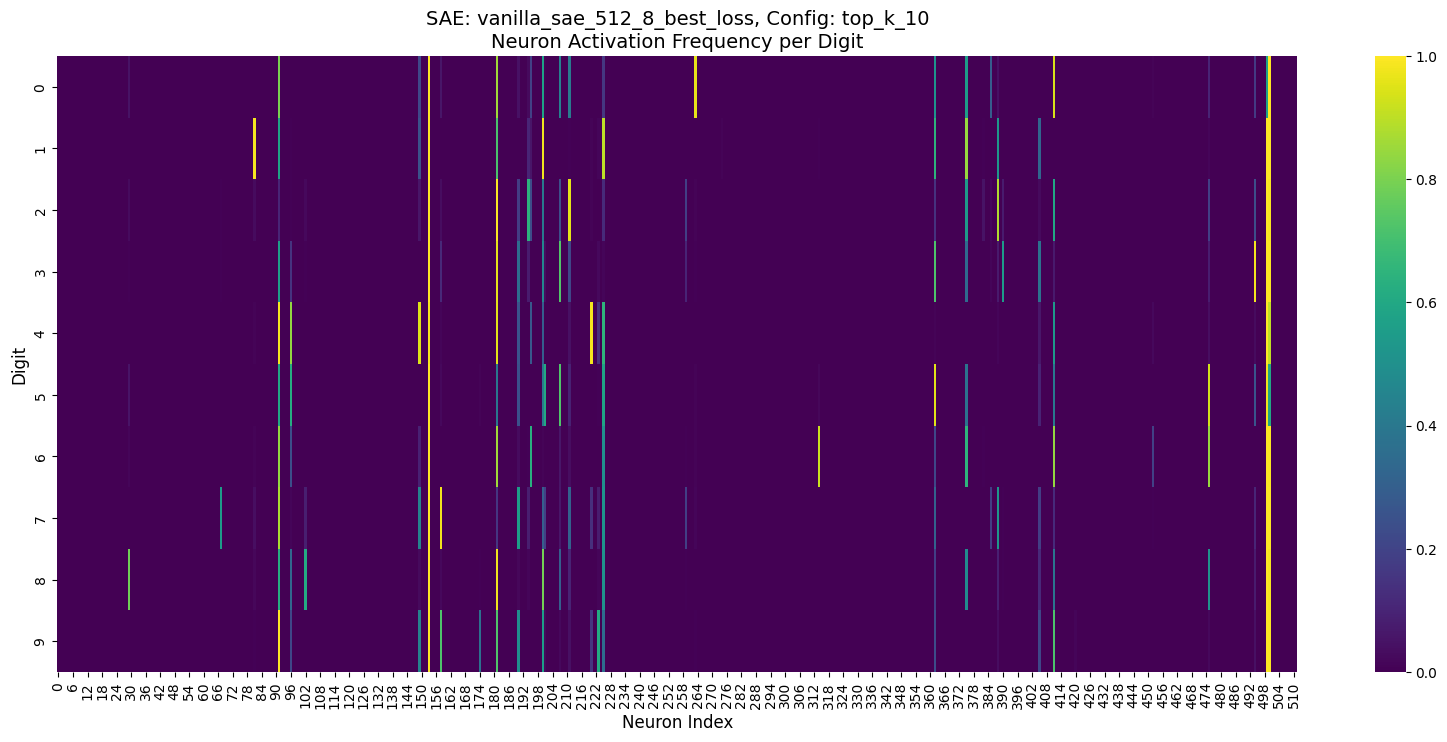

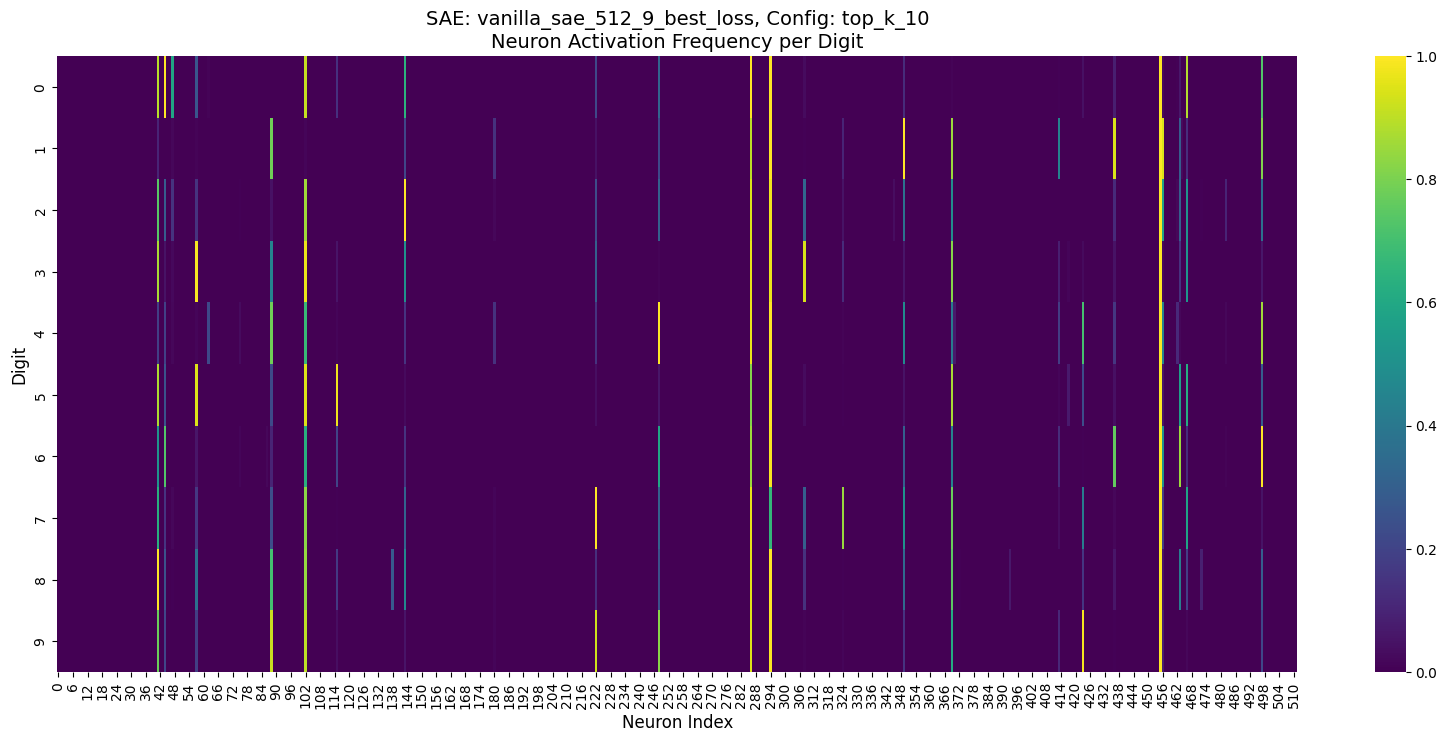

In [26]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def plot_neuron_usage_heatmap(concept_paths, summary, title_prefix=""):
    """
    Analyzes concept paths and generates a heatmap of neuron usage per digit.
    """
    num_neurons = summary.get('n_neurons', 256)
    num_classes = 10  # Assuming digits 0-9

    # Matrix to store the frequency of each neuron's activation for each class
    neuron_usage_matrix = np.zeros((num_classes, num_neurons))
    samples_per_class = defaultdict(int)

    # Populate the usage matrix
    for path in concept_paths:
        label = path.get('label')
        if label is not None and 0 <= label < num_classes:
            samples_per_class[label] += 1
            for neuron_idx in path['active_neurons']:
                if 0 <= neuron_idx < num_neurons:
                    neuron_usage_matrix[label, neuron_idx] += 1
    
    # Normalize by the number of samples to get activation frequency
    for i in range(num_classes):
        if samples_per_class[i] > 0:
            neuron_usage_matrix[i, :] /= samples_per_class[i]

    # Plotting the heatmap
    plt.figure(figsize=(20, 8))
    sns.heatmap(neuron_usage_matrix, cmap='viridis', yticklabels=range(num_classes))
    plt.xlabel('Neuron Index', fontsize=12)
    plt.ylabel('Digit', fontsize=12)
    plt.title(f'{title_prefix}\nNeuron Activation Frequency per Digit', fontsize=14)
    plt.show()


for sae_name, results_by_thresh in sorted(all_concept_paths.items()):
    for thresh_type, data in results_by_thresh.items():
        # if thresh_type != 'top_k_10':
        #     continue
        # if 'concept_paths' in data and 'summary' in data:
        #     title = f"SAE: {sae_name}, Config: {thresh_type}"
        #     plot_neuron_usage_heatmap(data['concept_paths'], data['summary'], title_prefix=title)

    

Plotting 4 specified groups:
  Vanilla, Dict Size: 256, Available penalties: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  Reanim, Dict Size: 256, Available penalties: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  Vanilla, Dict Size: 512, Available penalties: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  Reanim, Dict Size: 512, Available penalties: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


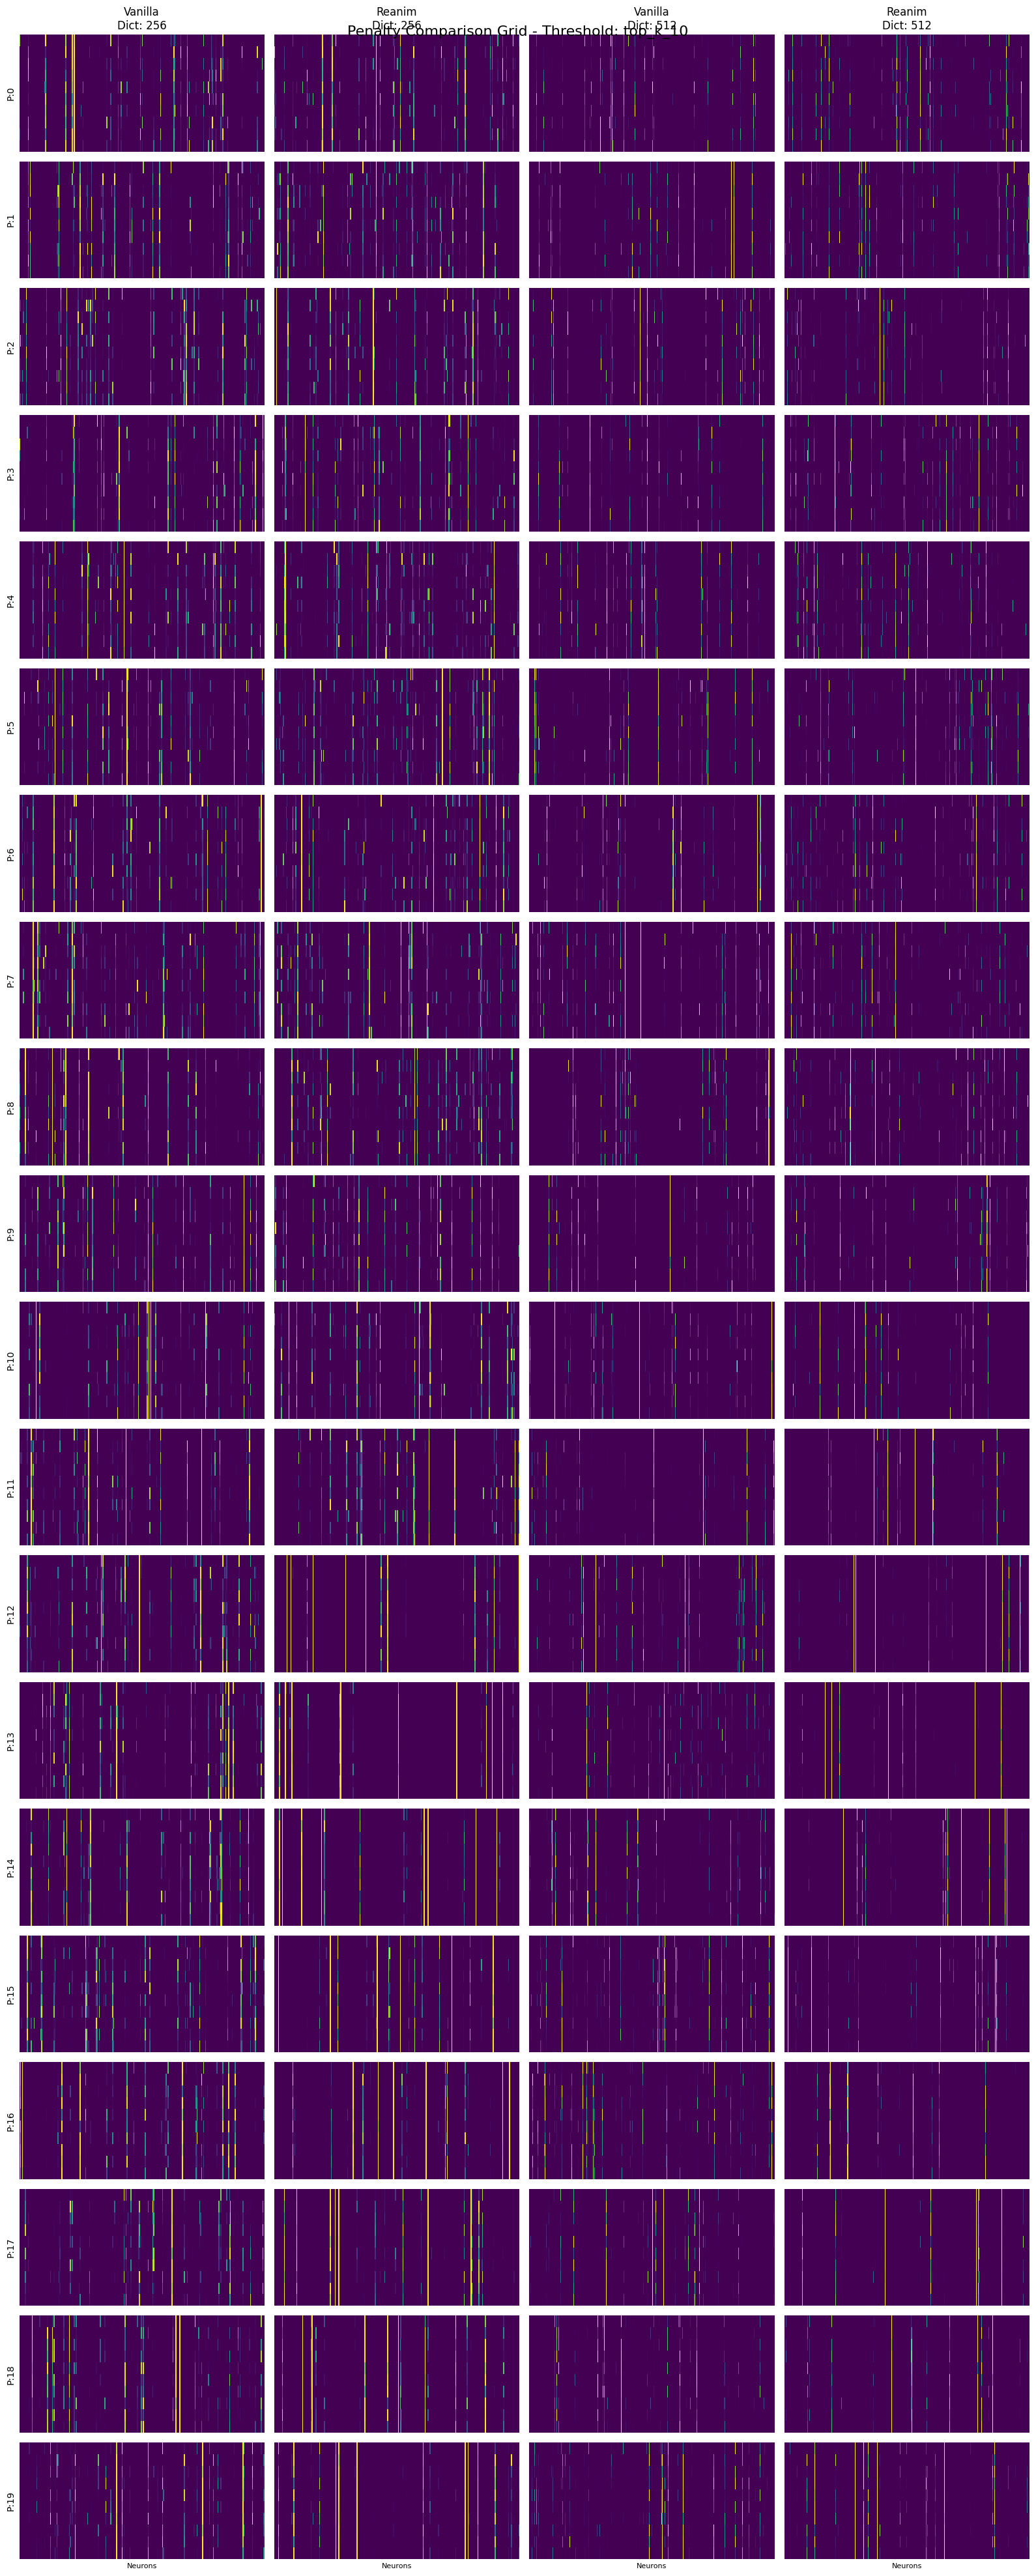

In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re

def parse_sae_name(sae_name):
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]
    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == 'vanilla' and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return has_reanim, None, None

def plot_neuron_usage_heatmap(concept_paths, summary, title_prefix=""):
    """
    Analyzes concept paths and generates a heatmap of neuron usage per digit.
    """
    num_neurons = summary.get('n_neurons', 256)
    num_classes = 10  # Assuming digits 0-9
    
    # Matrix to store the frequency of each neuron's activation for each class
    neuron_usage_matrix = np.zeros((num_classes, num_neurons))
    samples_per_class = defaultdict(int)
    
    # Populate the usage matrix
    for path in concept_paths:
        label = path.get('label')
        if label is not None and 0 <= label < num_classes:
            samples_per_class[label] += 1
            for neuron_idx in path['active_neurons']:
                if 0 <= neuron_idx < num_neurons:
                    neuron_usage_matrix[label, neuron_idx] += 1
    
    # Normalize by the number of samples to get activation frequency
    for i in range(num_classes):
        if samples_per_class[i] > 0:
            neuron_usage_matrix[i, :] /= samples_per_class[i]
    
    # Plotting the heatmap
    plt.figure(figsize=(20, 8))
    sns.heatmap(neuron_usage_matrix, cmap='viridis', yticklabels=range(num_classes))
    plt.xlabel('Neuron Index', fontsize=12)
    plt.ylabel('Digit', fontsize=12)
    plt.title(f'{title_prefix}\nNeuron Activation Frequency per Digit', fontsize=14)
    plt.show()

def group_and_plot_saes(all_concept_paths, thresh_type_filter=None):
    """
    Group SAEs by has_reanim and dictionary_size, then plot sorted by penalty_type.
    
    Args:
        all_concept_paths: Dictionary containing all SAE results
        thresh_type_filter: Optional filter for threshold type (e.g., 'top_k_10')
    """
    # Group SAEs by (has_reanim, dictionary_size)
    grouped_saes = defaultdict(list)
    
    for sae_name, results_by_thresh in all_concept_paths.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        
        if dict_size is None or penalty is None:
            continue
            
        # Store the SAE info with its results
        sae_info = {
            'sae_name': sae_name,
            'has_reanim': has_reanim,
            'dict_size': dict_size,
            'penalty': penalty,
            'results_by_thresh': results_by_thresh
        }
        
        grouped_saes[(has_reanim, dict_size)].append(sae_info)
    
    # Sort and plot for each group
    for (has_reanim, dict_size), sae_list in sorted(grouped_saes.items()):
        reanim_label = "Reanim" if has_reanim else "Vanilla"
        print(f"\nProcessing group: {reanim_label}, Dictionary Size: {dict_size}")
        
        # Sort by penalty (0 to 20)
        sae_list_sorted = sorted(sae_list, key=lambda x: x['penalty'])
        
        # Filter penalty types 0-20 if needed
        sae_list_filtered = [sae for sae in sae_list_sorted if 0 <= sae['penalty'] <= 20]
        
        print(f"Found {len(sae_list_filtered)} SAEs with penalty types 0-20")
        
        # Plot each SAE in this group
        for sae_info in sae_list_filtered:
            sae_name = sae_info['sae_name']
            penalty = sae_info['penalty']
            results_by_thresh = sae_info['results_by_thresh']
            
            for thresh_type, data in results_by_thresh.items():
                # Apply threshold filter if specified
                if thresh_type_filter and thresh_type != thresh_type_filter:
                    continue
                    
                if 'concept_paths' in data and 'summary' in data:
                    title = f"{reanim_label}, Dict Size: {dict_size}, Penalty: {penalty}, Thresh: {thresh_type}"
                    plot_neuron_usage_heatmap(data['concept_paths'], data['summary'], title_prefix=title)

def plot_penalty_comparison_grid(all_concept_paths, thresh_type='top_k_10', max_penalty=19):
    """
    Create a 20x4 grid comparison where columns are groups (has_reanim, dict_size combinations)
    and rows are penalty values (0-19).
    
    Args:
        all_concept_paths: Dictionary containing all SAE results
        thresh_type: Threshold type to use for comparison
        max_penalty: Maximum penalty value to include (default 19 for 0-19 range)
    """
    # Group SAEs by (has_reanim, dict_size)
    grouped_saes = defaultdict(dict)  # {(has_reanim, dict_size): {penalty: sae_info}}
    
    for sae_name, results_by_thresh in all_concept_paths.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        if dict_size is None or penalty is None:
            continue
        if penalty > max_penalty:
            continue
        if thresh_type not in results_by_thresh:
            continue
        
        data = results_by_thresh[thresh_type]
        if 'concept_paths' not in data or 'summary' not in data:
            continue
            
        sae_info = {
            'sae_name': sae_name,
            'penalty': penalty,
            'data': data
        }
        
        grouped_saes[(has_reanim, dict_size)][penalty] = sae_info
    
    # Get all available groups and sort them
    all_groups = sorted(grouped_saes.keys())
    n_groups = len(all_groups)
    
    if n_groups == 0:
        print("No valid SAE groups found")
        return
    
    print(f"Found {n_groups} groups:")
    for has_reanim, dict_size in all_groups:
        reanim_label = "Reanim" if has_reanim else "Vanilla"
        penalties = sorted(grouped_saes[(has_reanim, dict_size)].keys())
        print(f"  {reanim_label}, Dict Size: {dict_size}, Penalties: {penalties}")
    
    # Create the grid: 20 rows (penalties 0-19) x n_groups columns
    n_penalties = max_penalty + 1  # 0 to max_penalty inclusive
    fig, axes = plt.subplots(n_penalties, n_groups, figsize=(4*n_groups, 2*n_penalties))
    
    # Handle case where we have only one group or one penalty
    if n_groups == 1 and n_penalties == 1:
        axes = [[axes]]
    elif n_groups == 1:
        axes = [[ax] for ax in axes]
    elif n_penalties == 1:
        axes = [axes]
    
    fig.suptitle(f'Penalty Comparison Grid - Threshold: {thresh_type}', fontsize=16)
    
    # Create column labels
    for col_idx, (has_reanim, dict_size) in enumerate(all_groups):
        reanim_label = "Reanim" if has_reanim else "Vanilla"
        axes[0][col_idx].set_title(f'{reanim_label}\nDict: {dict_size}', fontsize=12)
    
    # Fill the grid
    for penalty in range(n_penalties):
        for col_idx, (has_reanim, dict_size) in enumerate(all_groups):
            ax = axes[penalty][col_idx]
            
            # Check if we have data for this penalty and group
            group_data = grouped_saes.get((has_reanim, dict_size), {})
            sae_info = group_data.get(penalty)
            
            if sae_info is not None:
                # We have data - plot the heatmap
                data = sae_info['data']
                concept_paths = data['concept_paths']
                summary = data['summary']
                
                # Calculate neuron usage matrix
                num_neurons = summary.get('n_neurons', 256)
                num_classes = 10
                neuron_usage_matrix = np.zeros((num_classes, num_neurons))
                samples_per_class = defaultdict(int)
                
                for path in concept_paths:
                    label = path.get('label')
                    if label is not None and 0 <= label < num_classes:
                        samples_per_class[label] += 1
                        for neuron_idx in path['active_neurons']:
                            if 0 <= neuron_idx < num_neurons:
                                neuron_usage_matrix[label, neuron_idx] += 1
                
                for i in range(num_classes):
                    if samples_per_class[i] > 0:
                        neuron_usage_matrix[i, :] /= samples_per_class[i]
                
                # Plot heatmap (no colorbar for individual subplots to save space)
                sns.heatmap(neuron_usage_matrix, cmap='viridis', 
                           yticklabels=False, xticklabels=False, ax=ax, cbar=False)
                
            else:
                # No data available - show empty plot
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10, alpha=0.5)
                ax.set_xticks([])
                ax.set_yticks([])
            
            # Add penalty label on the left column
            if col_idx == 0:
                ax.set_ylabel(f'P:{penalty}', fontsize=10)
            else:
                ax.set_ylabel('')
            
            # Remove x-axis labels except for bottom row
            if penalty < n_penalties - 1:
                ax.set_xlabel('')
            else:
                ax.set_xlabel('Neurons', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_penalty_comparison_grid_specific_groups(all_concept_paths, groups_to_plot, thresh_type='top_k_10', max_penalty=19):
    """
    Create a 20x4 grid for specific groups.
    
    Args:
        all_concept_paths: Dictionary containing all SAE results
        groups_to_plot: List of (has_reanim, dict_size) tuples to include
        thresh_type: Threshold type to use for comparison
        max_penalty: Maximum penalty value to include (default 19 for 0-19 range)
    """
    # Group SAEs by (has_reanim, dict_size)
    grouped_saes = defaultdict(dict)
    
    for sae_name, results_by_thresh in all_concept_paths.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        if dict_size is None or penalty is None:
            continue
        if penalty > max_penalty:
            continue
        if (has_reanim, dict_size) not in groups_to_plot:
            continue
        if thresh_type not in results_by_thresh:
            continue
            
        data = results_by_thresh[thresh_type]
        if 'concept_paths' not in data or 'summary' not in data:
            continue
            
        sae_info = {
            'sae_name': sae_name,
            'penalty': penalty,
            'data': data
        }
        
        grouped_saes[(has_reanim, dict_size)][penalty] = sae_info
    
    # Use the specified groups in order
    n_groups = len(groups_to_plot)
    n_penalties = max_penalty + 1
    
    if n_groups == 0:
        print("No groups specified")
        return
        
    print(f"Plotting {n_groups} specified groups:")
    for has_reanim, dict_size in groups_to_plot:
        reanim_label = "Reanim" if has_reanim else "Vanilla"
        penalties = sorted(grouped_saes.get((has_reanim, dict_size), {}).keys())
        print(f"  {reanim_label}, Dict Size: {dict_size}, Available penalties: {penalties}")
    
    # Create the grid
    fig, axes = plt.subplots(n_penalties, n_groups, figsize=(4*n_groups, 2*n_penalties))
    
    # Handle edge cases
    if n_groups == 1 and n_penalties == 1:
        axes = [[axes]]
    elif n_groups == 1:
        axes = [[ax] for ax in axes]
    elif n_penalties == 1:
        axes = [axes]
    
    fig.suptitle(f'Penalty Comparison Grid - Threshold: {thresh_type}', fontsize=16)
    
    # Create column labels
    for col_idx, (has_reanim, dict_size) in enumerate(groups_to_plot):
        reanim_label = "Reanim" if has_reanim else "Vanilla"
        axes[0][col_idx].set_title(f'{reanim_label}\nDict: {dict_size}', fontsize=12)
    
    # Fill the grid
    for penalty in range(n_penalties):
        for col_idx, (has_reanim, dict_size) in enumerate(groups_to_plot):
            ax = axes[penalty][col_idx]
            
            # Check if we have data for this penalty and group
            group_data = grouped_saes.get((has_reanim, dict_size), {})
            sae_info = group_data.get(penalty)
            
            if sae_info is not None:
                # We have data - plot the heatmap
                data = sae_info['data']
                concept_paths = data['concept_paths']
                summary = data['summary']
                
                # Calculate neuron usage matrix
                num_neurons = summary.get('n_neurons', 256)
                num_classes = 10
                neuron_usage_matrix = np.zeros((num_classes, num_neurons))
                samples_per_class = defaultdict(int)
                
                for path in concept_paths:
                    label = path.get('label')
                    if label is not None and 0 <= label < num_classes:
                        samples_per_class[label] += 1
                        for neuron_idx in path['active_neurons']:
                            if 0 <= neuron_idx < num_neurons:
                                neuron_usage_matrix[label, neuron_idx] += 1
                
                for i in range(num_classes):
                    if samples_per_class[i] > 0:
                        neuron_usage_matrix[i, :] /= samples_per_class[i]
                
                # Plot heatmap
                sns.heatmap(neuron_usage_matrix, cmap='viridis', 
                           yticklabels=False, xticklabels=False, ax=ax, cbar=False)
                
            else:
                # No data available
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10, alpha=0.5)
                ax.set_xticks([])
                ax.set_yticks([])
            
            # Add penalty label on the left column
            if col_idx == 0:
                ax.set_ylabel(f'P:{penalty}', fontsize=10)
            else:
                ax.set_ylabel('')
            
            # Remove x-axis labels except for bottom row
            if penalty < n_penalties - 1:
                ax.set_xlabel('')
            else:
                ax.set_xlabel('Neurons', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Usage examples:

# 1. Plot all SAEs grouped by reanim flag and dictionary size
# group_and_plot_saes(all_concept_paths, thresh_type_filter='top_k_10')

# 2. Create a 20x4 grid with all available groups (up to 4)
# plot_penalty_comparison_grid(all_concept_paths, thresh_type='top_k_10')

# 3. Create a 20x4 grid with specific groups
# Specify exactly which 4 groups you want:
groups = [(False, 256), (True, 256), (False, 512), (True, 512)]  # Vanilla+Reanim for 256 and 512
plot_penalty_comparison_grid_specific_groups(all_concept_paths, groups, thresh_type='top_k_10')

# 4. See available groups first
# print("Available SAE groups:")
# grouped_saes_summary = defaultdict(list)
# for sae_name in all_concept_paths.keys():
#     has_reanim, dict_size, penalty = parse_sae_name(sae_name)
#     if dict_size is not None and penalty is not None:
#         grouped_saes_summary[(has_reanim, dict_size)].append(penalty)

# for (has_reanim, dict_size), penalties in sorted(grouped_saes_summary.items()):
#     reanim_label = "Reanim" if has_reanim else "Vanilla"
#     penalty_range = f"{min(penalties)}-{max(penalties)}"
#     print(f"  {reanim_label}, Dict Size: {dict_size}, Penalties: {penalty_range} ({len(penalties)} SAEs)"))

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def parse_sae_name(sae_name):
    name = sae_name.replace('_best_loss', '')
    has_reanim = name.startswith('reanim_')
    if has_reanim:
        name = name[7:]
    parts = name.split('_')
    if len(parts) >= 4 and parts[0] == 'vanilla' and parts[1] == 'sae':
        try:
            dict_size = int(parts[2])
            penalty = int(parts[3])
            return has_reanim, dict_size, penalty
        except ValueError:
            pass
    return has_reanim, None, None

def plot_jaccard_by_penalty(all_concept_paths, thresh_type='top_k_10'):
    grouped_scores = defaultdict(lambda: {'penalties': [], 'scores': []})

    for sae_name, results_by_thresh in all_concept_paths.items():
        has_reanim, dict_size, penalty = parse_sae_name(sae_name)
        if dict_size is None or penalty is None:
            continue
        if thresh_type not in results_by_thresh:
            continue
        data = results_by_thresh[thresh_type]
        
        if 'overlap_analysis' in data:
            score = data['overlap_analysis']['summary']['mean_jaccard']

            key = (has_reanim, dict_size)
            grouped_scores[key]['penalties'].append(penalty)
            grouped_scores[key]['scores'].append(score)

    plt.figure(figsize=(10, 6))
    for (has_reanim, dict_size), values in grouped_scores.items():
        penalties = np.array(values['penalties'])
        scores = np.array(values['scores'])

        # Sort by penalty in descending order
        sort_idx = np.argsort(-penalties)
        penalties = penalties[sort_idx]
        scores = scores[sort_idx]

        label = f"{'Reanim' if has_reanim else 'Vanilla'} SAE {dict_size}"
        plt.plot(penalties, scores, marker='o', label=label)

    plt.title("Mean Jaccard Score vs Penalty")
    plt.xlabel("Penalty")
    plt.ylabel("Mean Jaccard Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

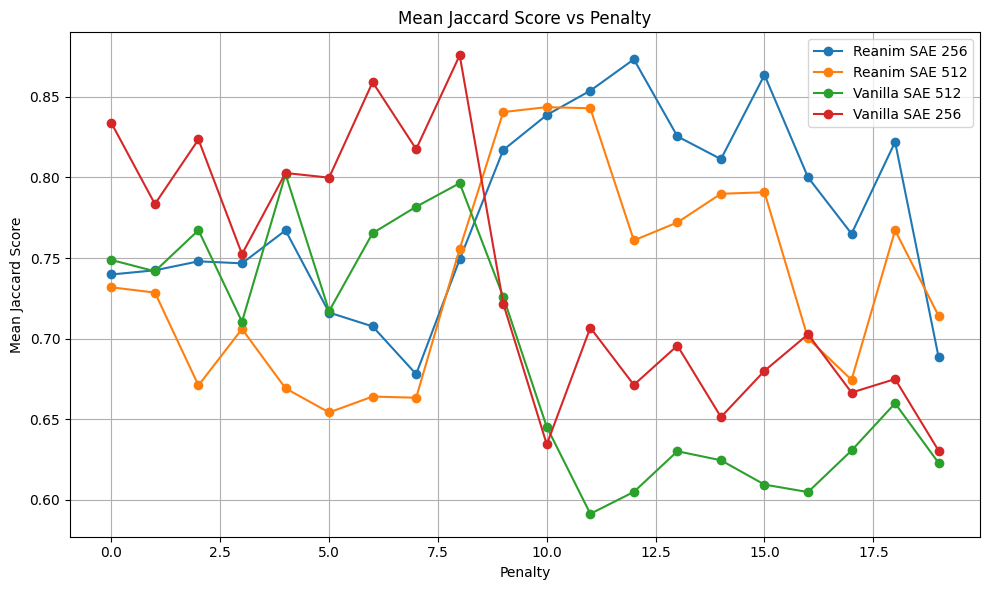

In [47]:
plot_jaccard_by_penalty(all_concept_paths, thresh_type='top_k_10')

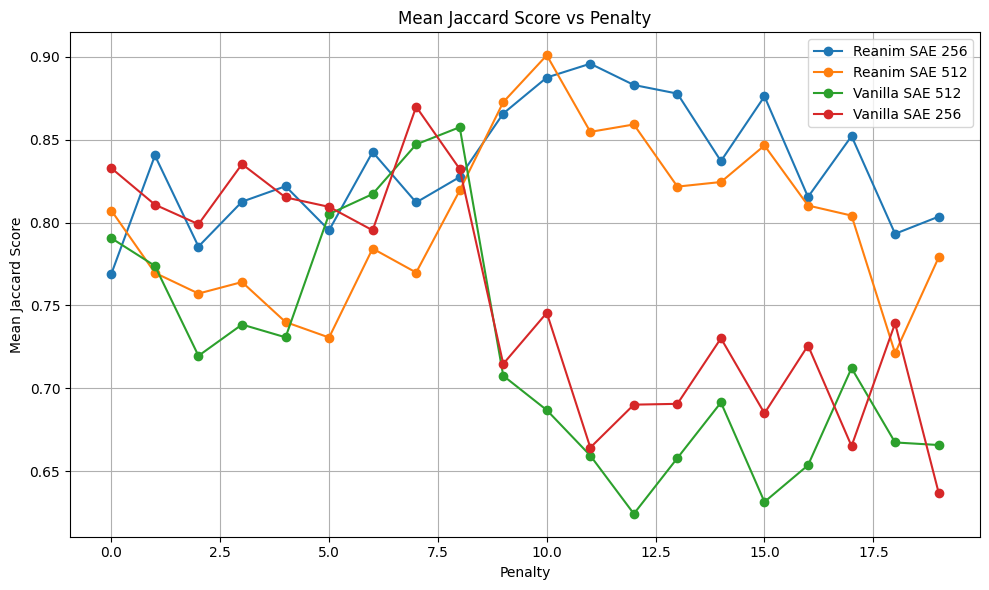

In [48]:
plot_jaccard_by_penalty(all_concept_paths, thresh_type='top_k_20')